In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as io
import scipy.signal as signal
from scipy.optimize import curve_fit
import logging
import importlib
import os


import ephys_extractor as efex
import ephys_features as ft
sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from sklearn import linear_model
ransac = linear_model.RANSACRegressor()

%matplotlib inline

In [2]:
# Normally you don't change modules though
importlib.reload(efex)
importlib.reload(ft)

<module 'ephys_features' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py'>

# Load and process data

Make sure that in os.walk('') you specify the correct directory with the data!

In [3]:
# L4 Neuro data .mat files
# Check out all directories with its subdirectories and files. Every step in the for-loop checks the root, all the
# subdirectories and the files in the current directory (with name root). Save the file if .mat extension.
L4_Neurolucida = []
L4_names_Neurolucida = []
for root, dirs, files in os.walk('../L4 Neurolucida/L4 morph'):
    if files:
        for file in files:
            if file.endswith('.mat'):
                L4_Neurolucida.append(io.loadmat(root + '/' + file))
                L4_names_Neurolucida.append(root + '/' + file)

In [4]:
L4_names_Neurolucida

['../L4 Neurolucida/L4 morph/SC/04 28 2017 slice 1 cell 3.mat',
 '../L4 Neurolucida/L4 morph/SC/09 12 2017 slice 1 cell 7.mat',
 '../L4 Neurolucida/L4 morph/SC/03 17 2017 slice 3 cell 3.mat',
 '../L4 Neurolucida/L4 morph/SC/06 27 2017 slice 1 cell 2.mat',
 '../L4 Neurolucida/L4 morph/SC/04 17 2017 slice 1 cell 2.mat',
 '../L4 Neurolucida/L4 morph/SC/06 16 2017 slice 1 cell 3.mat',
 '../L4 Neurolucida/L4 morph/SC/10 09 2017 slice 2 cell 2.mat',
 '../L4 Neurolucida/L4 morph/SC/01 19 2017 slice 1 cell 2.mat',
 '../L4 Neurolucida/L4 morph/SC/01 23 2017 slice 3 cell 2.mat',
 '../L4 Neurolucida/L4 morph/SC/06 28 2017 slice 3 cell 2.mat',
 '../L4 Neurolucida/L4 morph/SC/06 28 2017 slice 3 cell 6.mat',
 '../L4 Neurolucida/L4 morph/SC/03 29 2017 slice 4 cell 2.mat',
 '../L4 Neurolucida/L4 morph/SC/03 28 2017 slice 6 cell 2.mat',
 '../L4 Neurolucida/L4 morph/SC/08 31 2017 slice 1 cell 2.mat',
 '../L4 Neurolucida/L4 morph/SC/02 10 2017 slice 4 cell 3.mat',
 '../L4 Neurolucida/L4 morph/SC/03 06 20

In [7]:
len(L4_names_Neurolucida)

255

In [6]:
CurrStarts = pd.read_excel('../L4 Neurolucida/L4 Neurolucida Data/stimulation-currents.xlsx', header = 0)
CurrStarts = CurrStarts.set_index(['Cell ID'])
index_for_curr_starts = ['{}'.format(g.split('/')[-1].split('.')[0]) for g in L4_names_Neurolucida]
traces_but_no_labels = []
ind = []
print('traces available but no starting currents nor labels: \n')
for i, g in enumerate(index_for_curr_starts):
    if g in CurrStarts.index:
        ind.append(i)
    if g not in CurrStarts.index:
        print(g)       
L4_names_Neurolucida = np.array(L4_names_Neurolucida)[ind].tolist()
L4_Neurolucida = np.array(L4_Neurolucida)[ind].tolist()
index_for_curr_starts = np.array(index_for_curr_starts)[ind].tolist()
print('\nRemaining cells with current start/hold values but no traces: ')
ind_for_removal = []
for g in CurrStarts.index:
    if g not in index_for_curr_starts:
        print(g)
        ind_for_removal.append(g)
CurrStarts = CurrStarts.drop(ind_for_removal, axis = 0)
CurrStarts = CurrStarts.reindex(index_for_curr_starts)
current_hold_list = CurrStarts['Current start (pA)'].tolist()
current_stim_start_list = CurrStarts['inj current'].tolist()
CurrStarts.to_csv('../L4 Neurolucida/L4 Neurolucida Data/CurrentAndLabelInfo.csv')

traces available but no starting currents nor labels: 


Remaining cells with current start/hold values but no traces: 


In [8]:
def data_preparation(data, data_name, current_start, el_num = 2, current_step = 20):
    """Analyse the data in dictionary format (assumes a certain outlook of the data) and return the voltage traces, 
    stimulus current magnitudes for all traces, the time and the current index for which the current magnitude equals 0 pA.

    Parameters
    ----------
    data : dictionary full of voltage (V) and time (s) traces
    data_name : String, name of the cell we are investigating
    current_start: the magnitude of the injection current the experiment started with
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    voltage : numpy 2D array of voltage traces (mV)
    time : numpy 1D array of time points (s)
    current : numpy 1D array of current stimulus magnitudes
    curr_index_0 : integer of current index where the current is approximately 0 pA (i.e. the variance of the voltage
                   trace should be the lowest here)
    """
    
    
    
    # All the keys in the dictionary should have the form "Trace_1_j_c_el" where j represents a certain number which could
    # be different between cells/samples, therefore we will store this number as num. c represents the current stimulus
    # magnitude index, el the electrode number. They usually always record from electrode number el = 2.
    
    # Random initialisations
    num = 2
    n_samp = 22500
    dt = 4e-05
    for key in list(data)[1:6]:
        if key.split('_')[0] == "Trace":
            num = key.split('_')[2]
            n_samp = data[key].shape[0] # Amount of timepoints
            dt = data[key][1, 0] - data[key][0, 0] # Time step
            break
    time = np.arange(0,n_samp*dt,dt)
    
    # We pick random voltage traces to look for the resting membrane voltage
    Vm_tuple = []
    
    # Check whether we have hyperpolarisation in the beginning, otherwise the electrode where spikes have been recorded must have
    # been a different one
    object_ephys = efex.EphysSweepFeatureExtractor(t = time, \
                                                   v = 1000*data['Trace_{}_{}_{}_{}'.format(1, num, 1, el_num)][:, 1], \
                                                   start = 0.1, end = 0.7, filter = 10)
    voltage_deflection_v, _ = object_ephys.voltage_deflection()
    Vm = object_ephys._get_baseline_voltage()
    V_defl = voltage_deflection_v
    
    if  np.abs(Vm - V_defl) < 5: # We have the wrong el_num in the dictionary, find a new one for which proper traces exit
        el_num = 1
        while not np.abs(Vm - V_defl) > 10:
            object_ephys = efex.EphysSweepFeatureExtractor(t = time, \
                                            v = 1000*data['Trace_{}_{}_{}_{}'.format(1, num, 1, el_num)][:, 1], \
                                            start = 0.1, end = 0.7, filter = 10)
            Vm = object_ephys._get_baseline_voltage()
            V_defl, _ = object_ephys.voltage_deflection()
            if el_num == 1:
                el_num = 3
            else: el_num += 1
        el_num = el_num - 1
        
    # Some cells might just be hard to estimate the el_num for (e.g. a noisy peak before stimulation start, then
    # the difference can be larger than 10 but it's due to the noisy peak!). So here you can specify an el_num for
    # certain cells if you know the name for them and figured it out manually:
    if data_name == '../L4 Neurolucida/L4 morph/MC/12 05 2016 slice 5 cell 7.mat':
        el_num = 7
    
    Amount_Of_Electrodes = np.max([int(g.split('_')[-1]) if (g.split('_')[0] == 'Trace') else 0 for g in list(data.keys())])
    
    
    # stim_paradigm_num is the number of current stimulus magnitudes that were used
    stim_paradigm_num = (np.array(list(data)).size - 3)/Amount_Of_Electrodes
                                    # 3 keys should just be '__globals__', '__header__', and '__version__'
    
    start_current_impulse = current_start # - 1 since in the dictionary we start at 1 (not at zero)    
    stop_current_impulse = start_current_impulse + (current_step*stim_paradigm_num)
    current = np.arange(start_current_impulse, stop_current_impulse, current_step)
    
    # voltage will give us the voltage response for all different current steps
    voltage = np.zeros((n_samp,len(current)))
    for c, C in enumerate(current):
        voltage[:,c] = 1000*data['Trace_1_{}_{}_{}'.format(num, c+1, el_num)][:,1] # c+1: goes from 1 to end of possible current
                                                                                   # stimulation magnitudes
    
    return time, current, voltage

In [19]:
# Here is an example to experiment with
time, current, voltage = data_preparation(L4_Neurolucida[116], L4_names_Neurolucida[116], \
                                          current_stim_start_list[116], el_num = 2)
print('time: ', time)
print('\n\ncurrent: ', current)
print('\n\nvoltage: ', voltage)

time:  [0.0000e+00 4.0000e-05 8.0000e-05 ... 8.9988e-01 8.9992e-01 8.9996e-01]


current:  [-100.  -80.  -60.  -40.  -20.    0.   20.   40.   60.   80.  100.  120.
  140.  160.  180.  200.  220.  240.  260.  280.  300.  320.  340.]


voltage:  [[-70.34932822 -69.99737024 -69.7273016  ... -73.64313304 -73.60299677
  -73.61485809]
 [-70.33095509 -69.98185068 -69.7337091  ... -73.66110384 -73.61180335
  -73.65921885]
 [-70.3067854  -69.96376067 -69.74622607 ... -73.67901504 -73.6278221
  -73.70407879]
 ...
 [-69.91165876 -69.25070286 -69.12067533 ... -73.37529957 -73.73322546
  -73.71801138]
 [-69.94389743 -69.28910315 -69.08862293 ... -73.4096691  -73.74495268
  -73.77073914]
 [-69.96835768 -69.33664531 -69.05096769 ... -73.45293462 -73.75462353
  -73.81958514]]


In [23]:
L4_names_Neurolucida[116]

'../L4 Neurolucida/L4 morph/PYR/02 24 2017 slice 1 cell 3.mat'

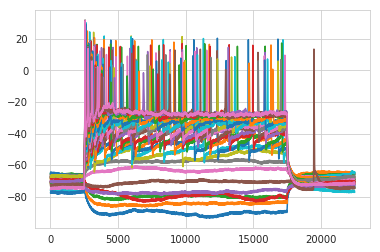

In [28]:
plt.plot(voltage)

# Analysing spikes

In [10]:
def extract_spike_features(time, current, voltage, current_hold, start = 0.1, end = 0.7, fil = 10):
    """ Analyse the voltage traces and extract information for every spike (returned in df), and information for all the spikes
    per current stimulus magnitude.

    Parameters
    ----------
    time : numpy 1D array of the time (s)
    current : numpy 1D array of all possible current stimulation magnitudes (pA)
    voltage : numpy ND array of all voltage traces (mV) corresponding to current stimulation magnitudes
    current_hold : current injection magnitude with which the experiment started
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    df : DataFrame with information for every detected spike (peak_v, peak_index, threshold_v, ...)
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    """
    
    df = pd.DataFrame()
    df_related_features = pd.DataFrame()
    for c, curr in enumerate(current):
        current_array = curr*np.ones_like(time)
        start_index = (np.abs(time - start)).argmin() # Find closest index where the injection current starts
        end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
        current_array[:start_index] = 0
        current_array[end_index:len(current_array)] = 0
        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = start, \
                                                      end = end, filter = fil)
        EphysObject.process_spikes()
        #if EphysObject._spikes_df.size:
        #    #Random threshold 15 for now but:
        #    if np.abs(EphysObject._get_baseline_voltage() - np.mean(EphysObject._spikes_df['threshold_v'].values)) < 15:
        #        print('Too steep depolarisation here.')
        #        EphysObject = efex.EphysSweepFeatureExtractor(t = time, v = voltage[:, c], i = current_array, start = 0.1005, \
        #                                                     end = end, filter = fil)
        
        # Adding peak_height (mV) + code for maximum frequency determination (see further)
        spike_count = 0
        if EphysObject._spikes_df.size:
            EphysObject._spikes_df['peak_height'] = EphysObject._spikes_df['peak_v'].values - \
                                                   EphysObject._spikes_df['threshold_v'].values
            spike_count = EphysObject._spikes_df['threshold_i'].values.size
        df = pd.concat([df, EphysObject._spikes_df], sort = True)

        # Some easily found extra features
        df_features = EphysObject._sweep_features

        # Adding spike count
        df_features.update({'spike_count': spike_count})
        
        # Adding current (pA)
        df_features.update({'current': curr})

        # Adding membrane voltage (mV)
        df_features.update({'resting_membrane_potential': EphysObject._get_baseline_voltage()})

        # Adding voltage deflection to steady state (mV)
        voltage_deflection_SS = ft.average_voltage(voltage[:, c], time, start = end - 0.1, end = end)
        #voltage_deflection_v, voltage_deflection_i = EphysObject.voltage_deflection() # = old way: max deflection
        df_features.update({'voltage_deflection': voltage_deflection_SS})
        
        # Adding input resistance (MOhm)
        # How to calculate the input resistance is not clear yet but this could be an option (although in function
        # get_cell_features it is being calculated differently)
        input_resistance = np.nan
        if not ('peak_i' in EphysObject._spikes_df.keys()) and not curr==0: # We only calculate input resistances 
                                                                            # from traces without peaks
            input_resistance = (np.abs(voltage_deflection_SS - EphysObject._get_baseline_voltage())*1000)/np.abs(curr)
            if input_resistance == np.inf:
                input_resistance = np.nan
        df_features.update({'input_resistance': input_resistance})

        # Adding membrane time constant (s) and voltage plateau level for hyperpolarisation paradigms after stimulus onset
        tau = np.nan
        E_plat = np.nan
        sag_ratio = np.nan
        if curr < current_hold: # We use hyperpolarising steps as required in the object function to estimate the
                                # membrane time constant and E_plateau
            while True:
                try:
                    tau = EphysObject.estimate_time_constant()  # Result in seconds!
                    break
                except TypeError: # Probably a noisy bump for this trace, just keep it to be np.nan
                    break
            E_plat = ft.average_voltage(voltage[:, c], time, start = end - 0.1, end = end)
            sag, sag_ratio = EphysObject.estimate_sag()
        df_features.update({'tau': tau})
        df_features.update({'E_plat': E_plat})
        df_features.update({'sag_ratio': sag_ratio})

        df_related_features = pd.concat([df_related_features, pd.DataFrame([df_features])], sort = True)
    
    return df, df_related_features

In [20]:
df, df_related_features = extract_spike_features(time, current, voltage, current_hold_list[116])

In [13]:
df_related_features

,E_plat,adapt,adaptation_index,avg_rate,current,cv,fano_factor,first_isi,input_resistance,isi_cv,...,latency,mean_isi,median_isi,norm_sq_isis,resting_membrane_potential,sag_ratio,spike_count,tau,v_baseline,voltage_deflection
0,-89.970639,NaN,NaN,0.000000,-280.0,NaN,NaN,NaN,78.507534,NaN,...,NaN,NaN,NaN,NaN,-67.988530,1.128745,0,0.011392,-67.988530,-89.970639
0,-83.949878,NaN,NaN,0.000000,-260.0,NaN,NaN,NaN,62.817324,NaN,...,NaN,NaN,NaN,NaN,-67.617374,1.122439,0,0.013580,-67.617374,-83.949878
0,-80.370225,NaN,NaN,0.000000,-240.0,NaN,NaN,NaN,59.409348,NaN,...,NaN,NaN,NaN,NaN,-66.111982,1.100118,0,0.016599,-66.111982,-80.370225
0,-81.196660,NaN,NaN,0.000000,-220.0,NaN,NaN,NaN,66.195903,NaN,...,NaN,NaN,NaN,NaN,-66.633561,1.105638,0,NaN,-66.633561,-81.196660
0,-76.047616,NaN,NaN,0.000000,-200.0,NaN,NaN,NaN,23.665079,NaN,...,NaN,NaN,NaN,NaN,-71.314600,1.470192,0,0.019349,-71.314600,-76.047616
0,NaN,NaN,NaN,0.000000,-180.0,NaN,NaN,NaN,1.841757,NaN,...,NaN,NaN,NaN,NaN,-70.462286,NaN,0,NaN,NaN,-70.793802
0,NaN,NaN,NaN,0.000000,-160.0,NaN,NaN,NaN,45.695078,NaN,...,NaN,NaN,NaN,NaN,-69.780212,NaN,0,NaN,NaN,-62.468999
0,NaN,NaN,NaN,0.000000,-140.0,NaN,NaN,NaN,70.604304,NaN,...,NaN,NaN,NaN,NaN,-68.014267,NaN,0,NaN,NaN,-58.129664
0,NaN,0.151293,135.652487,5.000000,-120.0,0.151293,0.002993,0.11096,NaN,0.151293,...,0.02684,0.130740,0.13074,0.022889,-68.692013,NaN,3,NaN,NaN,-51.613024
0,NaN,0.207109,186.274510,10.000000,-100.0,0.571276,0.037299,0.04284,NaN,0.571276,...,0.01520,0.114288,0.09500,0.054829,-69.724860,NaN,6,NaN,NaN,-48.177876


In [14]:
df

,adp_i,adp_index,adp_t,adp_v,clipped,downstroke,downstroke_index,downstroke_t,downstroke_v,fast_trough_i,...,trough_i,trough_index,trough_t,trough_v,upstroke,upstroke_downstroke_ratio,upstroke_index,upstroke_t,upstroke_v,width
0,NaN,NaN,NaN,NaN,False,-79.745656,3209,0.12836,-9.933827,-120.0,...,-120.0,3250,0.13000,-64.266980,167.580637,2.101439,3184,0.12736,-12.352243,0.00112
1,-120.0,6109.0,0.24436,-56.862891,False,-74.785445,5984,0.23936,-11.846490,-120.0,...,-120.0,6034,0.24136,-61.673839,147.476623,1.971996,5957,0.23828,-15.674382,0.00112
2,NaN,NaN,NaN,NaN,False,-71.685301,9750,0.39000,-15.534546,-120.0,...,-120.0,9802,0.39208,-60.927898,143.300824,1.999027,9722,0.38888,-13.551509,0.00112
0,NaN,NaN,NaN,NaN,False,-78.185885,2918,0.11672,-9.640269,-100.0,...,-100.0,2952,0.11808,-62.636696,165.029301,2.110730,2893,0.11572,-12.216997,0.00112
1,NaN,NaN,NaN,NaN,False,-71.104147,3989,0.15956,-5.658637,-100.0,...,-100.0,4039,0.16156,-60.716029,142.919983,2.010009,3964,0.15856,-14.302082,0.00112
2,NaN,NaN,NaN,NaN,False,-68.534705,5985,0.23940,-5.172500,-100.0,...,-100.0,6029,0.24116,-59.721667,135.511956,1.977275,5960,0.23840,-13.998510,0.00112
3,-100.0,8495.0,0.33980,-53.029340,False,-64.079052,8362,0.33448,-10.247875,-100.0,...,-100.0,8400,0.33600,-58.152836,128.047468,1.998273,8335,0.33340,-10.788638,0.00116
4,-100.0,11450.0,0.45800,-53.578619,False,-68.839908,11326,0.45304,-9.248220,-100.0,...,-100.0,11378,0.45512,-58.522359,128.593211,1.868004,11299,0.45196,-13.665405,0.00116
5,NaN,NaN,NaN,NaN,False,-70.092188,17207,0.68828,-10.189855,-100.0,...,-100.0,17259,0.69036,-58.530398,124.689544,1.778936,17180,0.68720,-13.539575,0.00112
0,NaN,NaN,NaN,NaN,False,-75.898996,2731,0.10924,-3.783804,-80.0,...,-80.0,2772,0.11088,-61.219871,157.415974,2.074019,2707,0.10828,-12.242207,0.00112


In [16]:
def get_cell_features(df, df_related_features, curr_hold, axis = None):
    """ Analyse all the features available for the cell per spike and per current stimulation magnitude. Extract typical
    features includig the resting membrane potential (Rm, mV), the input resistance (Ri, MOhm), the membrane time constant
    (tau, ms), the action potential threshold (AP threshold, mV), the action potential amplitude (AP amplitude, mV),
    the action potential half-width (AP half-width, ms), the afterhyperpolarisation (AHP, mV), the afterdepolarisation
    (ADP, mV), the adaptation index (AI, %) and the maximum firing frequency (max freq, Hz).
    
    Parameters
    ----------
    df : DataFrame with information for every detected spike
    df_related_features : DataFrame with information for every possible used current stimulation magnitude
    curr_hold : holding current (current clamp) before current stimulation
    axis : axis you'd like to plot information on (optional, None by default)
    
    Returns
    ----------
    Cell_Features : DataFrame with values for all required features mentioned above
    """
    temp_df = df_related_features[['current', 'E_plat']].dropna()
    # The following is based on experimental paradigms where the voltage before stimulation is not necessary the resting
    # membrane potential. The first 5 hyperpolarisation traces below the first trace that shows depolarisation are taken into
    # account. A robust against outliers regression analysis is then performed (does this make sense for only 5 datapoints?) 
    if (temp_df.shape[0] >= 5):
        ransac.fit(temp_df['current'][-5:].values.reshape(-1, 1), \
                   temp_df['E_plat'][-5:].values.reshape(-1, 1))
        line_X = np.concatenate((temp_df['current'][-5:].values, \
                                 np.array([0]))).reshape(-1, 1)
        Ri = ransac.estimator_.coef_[0][0]*1000
        Rm = ransac.predict(np.array([0]).reshape(-1, 1))[0][0]
    else: # Just take as many hyperpolarisation traces available
        ransac.fit(temp_df['current'].values.reshape(-1, 1), \
                   temp_df['E_plat'].values.reshape(-1, 1))
        line_X = np.concatenate((temp_df['current'].values, np.array([0]))).reshape(-1, 1)
        Ri = ransac.estimator_.coef_[0][0]*1000
        Rm = ransac.predict(np.array([0]).reshape(-1, 1))[0][0]
        
    print('Rm: ', Rm)
    print('Ri: ', Ri)
    
    if axis:
        ax1 = axis
    else: fig, ax1 = plt.subplots(figsize = (10, 5))
    if (temp_df.shape[0] >= 4):
        ax1.plot(temp_df['current'][-5:].values.reshape(-1, 1), \
                   temp_df['E_plat'][-5:].values.reshape(-1, 1), '*b', markersize = 10)
    else:
        ax1.plot(temp_df['current'].values.reshape(-1, 1), \
                   temp_df['E_plat'].values.reshape(-1, 1), '*b', markersize = 10)
    ax1.plot(line_X, ransac.predict(line_X), 'b')
    #ax1.legend(['data', 'regression robust to outliers for Vm and R input'], loc = 'upper left')
    #ax1.set_xlim([-500,  300])
    ax1.set_xlabel('Current (pA)', fontsize = 17)
    ax1.set_ylabel('Steady state membrane voltage (mV)', color = 'b', fontsize = 17)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax1.tick_params('y', colors = 'b')
    ax1.set_title('Linear fits', fontsize = 20)
    ax1.spines['top'].set_visible(False)
    
    # Let's denote the membrane voltage clearly on the plot
    ax1.plot(0, Rm, marker = "_", color = 'black', ms = 50)
    ax1.annotate('', xy = (0, Rm - 10), \
                xycoords = 'data', xytext = (0, Rm), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<-', 'ec': 'grey', \
                                                   'connectionstyle': 'arc3', 'lw': 2, 'shrinkA': 0})
    ax1.annotate('Vm', xy = (0, Rm - 10), \
                xycoords = 'data', xytext = (0, -20), textcoords = 'offset points', fontsize = 15)
    
    
    # We consider all hyperpolarisation traces but perform an average without outliers (outliers are defined as lying above
    # or below 2 standard deviations from the mean)
    tau_array = df_related_features['tau'].dropna().values
    #sag_ratio_array = df_related_features['sag_ratio'].dropna().values
    
    #mean_tau = np.mean(tau_array, axis = 0)
    #mean_sag_ratio = np.mean(sag_ratio_array, axis = 0)
    tau = np.median(tau_array)*1000
    
    #sd_tau = np.std(tau_array, axis = 0)
    #sd_sag_ratio = np.std(sag_ratio_array, axis = 0)
    
    #tau_array_non_outliers = [x for x in tau_array if (x > mean_tau - 2*sd_tau)]
    #sag_ratio_array_non_outliers = [x for x in sag_ratio_array if (x > mean_sag_ratio - 2*sd_sag_ratio)]
    
    #tau_array_non_outliers = [x for x in tau_array_non_outliers if (x < mean_tau + 2*sd_tau)]
    #sag_ratio_array_non_outliers = [x for x in sag_ratio_array_non_outliers if (x < mean_sag_ratio + 2*sd_sag_ratio)]
    
    #tau = np.mean(np.array(tau_array_non_outliers))*1000
    #sag_ratio = np.mean(np.array(sag_ratio_array_non_outliers))
    sag_ratio = df_related_features['sag_ratio'].dropna().values[0] # Steepest hyperpolarising trace used
    
    if not df.empty:
        df_max_freq_AI = df_related_features[df_related_features['current'] > curr_hold]
        max_freq = np.max(df_max_freq_AI['spike_count'].values)
        
        non_nan_indexes_AI = ~np.isnan(df_max_freq_AI['adaptation_index'].values)
        
        if non_nan_indexes_AI.any():
            # Consider only the first 5 after threshold reached if possible
            # np.sum will consider a True as a 1 here and a False as a 0 (so you cound the True's effectively)
            if  np.sum(non_nan_indexes_AI) >= 5:
                AI_array = df_max_freq_AI['adaptation_index'].values[non_nan_indexes_AI][0:6]
                AI = np.median(AI_array)
                # Now let's not include outliers
                #mean_AI = np.mean(AI_array, axis = 0)
                #sd_AI = np.std(AI_array, axis = 0)
                #AI_array_non_outliers = [x for x in AI_array if (x > mean_AI - 2*sd_AI)]
                #AI_array_non_outliers = [x for x in AI_array_non_outliers if (x < mean_AI + 2*sd_AI)]
                #AI = np.mean(AI_array_non_outliers)
            else: # Take everything you have
                AI_array = df_max_freq_AI['adaptation_index'].values[non_nan_indexes_AI]
                AI = np.median(AI_array)
                # Now let's not include outliers
                #mean_AI = np.mean(AI_array, axis = 0)
                #sd_AI = np.std(AI_array, axis = 0)
                #AI_array_non_outliers = [x for x in AI_array if (x > mean_AI - 2*sd_AI)]
                #AI_array_non_outliers = [x for x in AI_array_non_outliers if (x < mean_AI + 2*sd_AI)]
                #AI = np.mean(AI_array_non_outliers)
        else:
            AI = 0
            
        # We calculate the latency: the time it takes to elicit the first spike
        df_latency = df_related_features[df_related_features['current'] > curr_hold]
        non_nan_indexes_latency = ~np.isnan(df_latency['latency'].values)
        # Only the first peak is considered for the first trace for which the current clamp stimulation is higher than the
        # current hold
        latency = df_latency['latency'].values[non_nan_indexes_latency][0]*1000
            
        # First index where there is a spike and the current stimulation magnitude is positive
        index_df = np.where(df.loc[0]['threshold_i'].values >= curr_hold)[0][0]
        
        non_nan_indexes_ahp = ~np.isnan(df.loc[0]['fast_trough_v'])
        if non_nan_indexes_ahp.any():
            AHP = df.loc[0]['fast_trough_v'].values[index_df] - df.loc[0]['threshold_v'].values[index_df]
        else:
            AHP = 0
        
        # For this experimental paradigm we estimate the rheobase as the first current stimulus magnitude
        # for which a spike has been observed (w.r.t. the holding current)
        df_related_features_for_rheobase = df_related_features[df_related_features['current'].values > curr_hold]
        #rheobase = df_related_features_for_rheobase['current'].values\
        #                    [np.nonzero(df_related_features_for_rheobase['spike_count'].values)[0][0]] - curr_hold
        
        # ADP (after changing a threshold delta_t (i.e. ADP should be shorter in time than this value): by default value set
        # in ephys_features.py from 0.005 to 0.01 !!!!!!!!!!)
        # Calculated w.r.t. AHP index!!!
        non_nan_indexes_adp = ~np.isnan(df.loc[0]['adp_v'])
        if non_nan_indexes_adp.any():
            ADP = df.loc[0]['adp_v'].values[index_df] - df.loc[0]['fast_trough_v'].values[index_df] # Only first peak is considered
            #valid_indexes = ADP_values > 0 # Will also make the Nan's false but we can still
            #          #do np.nanmean in the end
            #ADP = np.nanmean(ADP_values)
        else:
            ADP = 0
        non_nan_indexes_thresh = ~np.isnan(df.loc[0]['threshold_v'])
        if non_nan_indexes_thresh.any():
            if df.loc[0]['threshold_v'].size > 1:
                AP_threshold = df.loc[0]['threshold_v'].values[index_df] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'].values[index_df] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'].values[index_df] # Only first peak is considered
            else:
                AP_threshold = df.loc[0]['threshold_v'] # Only first peak is considered
                AP_amplitude = df.loc[0]['peak_height'] # Only first peak is considered
                AP_half_width = 1000*df.loc[0]['width'] # Only first peak is considered
            
        else:
            AP_threshold = 0
            AP_amplitude = 0
            AP_half_width = 0
        
        # We estimate the rheobase based on a few (i.e. 5)
        # suprathreshold currents steps. A linear fit of the spike frequency w.r.t. to the current injection values of
        # these steps should give the rheobase as the crossing with the x-axis. (Method almost in agreement with Alexandra
        # Naka et al.: "Complementary networks of cortical somatostatin interneurons enforce layer specific control.", 
        # they additionally use the subthreshold current step closest to the first suprathreshold one, we think that biases
        # the regression analysis). We take the max of the subthreshold current step closest to the
        # suprathreshold one and the regression line crossing with the x-axis. This method should approximate the rheobase
        # well provided the stimulus interval is long (in our case 600 ms).
        # If a regression cannot be performed, then take the first current step for which spikes have been observed (i.e.
        # not the subthreshold current step!)
        
        # Only positive currents for this experimental paradigm (i.e. 'spikes' observed for negative currents should not
        # be there)
        df_rheobase = df_related_features[['current', 'spike_count']][df_related_features['current'] > curr_hold]
        if len(np.nonzero(df_rheobase['spike_count'].values)[0]) > 4:
            indices = np.nonzero(df_rheobase['spike_count'].values)[0][:5]
            counts = [list(df_rheobase['spike_count'].values[indices]).count(x) for x in \
                                          df_rheobase['spike_count'].values[indices]]
            if np.max(np.array(counts)) < 3:
                ransac.fit(df_rheobase['current'].values[indices].reshape(-1, 1) - curr_hold, \
                           df_rheobase['spike_count'].values[indices].reshape(-1, 1)/(0.6))
                line_X = np.concatenate((df_rheobase['current'].values[indices] - curr_hold, \
                                         np.array([0]))).reshape(-1, 1)
                slope = ransac.estimator_.coef_[0][0]
                sub_thresh_curr = df_rheobase['current'].values\
                    [np.nonzero(df_rheobase['spike_count'].values)[0][0] - 1] - curr_hold
                first_supra_thresh_curr = df_rheobase['current'].values\
                    [np.nonzero(df_rheobase['spike_count'].values)[0][0]] - curr_hold
                rheobase = np.max([-ransac.predict(np.array([0]).reshape(-1, 1))[0][0]/slope, sub_thresh_curr])
                rheobase = np.min([rheobase, first_supra_thresh_curr])
                ax2 = ax1.twinx()
                ax2.plot(df_rheobase['current'].values[indices].reshape(-1, 1) - curr_hold, \
                         df_rheobase['spike_count'].values[indices].reshape(-1, 1)/(0.6), '.r', markersize = 15)
                ax2.plot(line_X, ransac.predict(line_X), color = 'r')
                ax2.set_ylabel('Spike frequency (Hz)', color = 'r', fontsize = 17)
                ax2.tick_params('y', colors = 'r')
                ax2.tick_params(axis = 'both', which = 'major', labelsize = 16)
                ax2.spines['top'].set_visible(False)
                ax2.set_ylim([0, np.max(df_rheobase['spike_count'].values[indices].reshape(-1, 1)/(0.6)) + 3])
                
                # Let's denote the membrane voltage clearly on the plot
                ax2.plot(rheobase, 0, marker = "|", color = 'black', ms = 50)
                ax2.annotate('', xy = (rheobase - 30, 1), \
                            xycoords = 'data', xytext = (rheobase, 1), \
                            textcoords = 'data', arrowprops = {'arrowstyle': '<-', 'connectionstyle': 'arc3', \
                                                               'lw': 2, 'ec': 'grey', 'shrinkB': 0})
                ax2.annotate('rheobase', xy = (rheobase -30, 1), \
                            xycoords = 'data', xytext = (-30, 10), textcoords = 'offset points', fontsize = 15)
                
            else: # A subset can probably not be found by RANSAC to do a regression
                  # Just take the first current step for which spikes have been observed
                rheobase = df_rheobase['current'].values\
                                [np.nonzero(df_rheobase['spike_count'].values)[0][0]] - curr_hold
            
        else: # Not enough datapoints to calculate a rheobase
              # Just take the first current step for which spikes have been observed
            rheobase = df_rheobase['current'].values\
                            [np.nonzero(df_rheobase['spike_count'].values)[0][0]] - curr_hold
    else:
        AHP = 0
        ADP = 0
        max_freq = 0
        AI = 0
        AP_threshold = 0
        AP_amplitude = 0
        AP_half_width = 0
        rheobase = 0
        latency = 0
    name_features = ['Vm (mV)', 'R_input (MOhm)', 'tau (ms)', 'AP threshold (mV)', 'AP amplitude (mV)', 'AP width (ms)', \
                 'AHP (mV)', 'ADP (mV)', 'AI (%)', 'MAX # spikes', 'rheobase (pA)', 'sag ratio', 'latency (ms)']
    features = [Rm, Ri, tau, AP_threshold, AP_amplitude, AP_half_width, AHP, ADP, AI, max_freq, rheobase, sag_ratio, latency]
    cell_features = dict(zip(name_features, features))
    Cell_Features = pd.DataFrame([cell_features])
    Cell_Features = Cell_Features.reindex(columns = name_features)
    return Cell_Features

Rm:  -72.22432247936725
Ri:  248.4491918385029


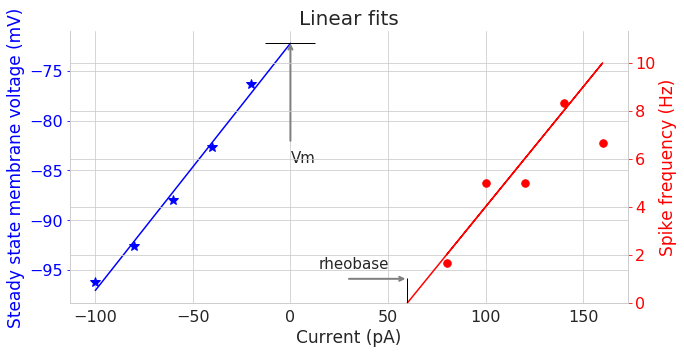

In [21]:
Cell_Features = get_cell_features(df, df_related_features, current_hold_list[116])

In [22]:
Cell_Features

,Vm (mV),R_input (MOhm),tau (ms),AP threshold (mV),AP amplitude (mV),AP width (ms),AHP (mV),ADP (mV),AI (%),MAX # spikes,rheobase (pA),sag ratio,latency (ms)
0,-72.224322,248.449192,23.865424,-33.436123,85.795511,1.6,-5.050242,0,149.086604,10,60.0,1.005515,134.24


In [24]:
def cell_features(data_tuple, names, current_hold_list, current_stim_start_list, el_num = 2, current_step = 20):
    """ Analyses a stream of cell dictionaries and outputs all the cell's features in a concatenated DataFrame
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    current_hold_list : list of current injection magnitudes with which every experiment started
    current_stim_start_list : list of current injection magnitudes with which every stimulation started
    
    Returns
    -------
    All_Cells_Features : DataFrame with values for all required features mentioned in get_cell_features
    """
    All_Cells_Features = pd.DataFrame()
    for (data, name, current_hold, current_start) in zip(data_tuple, names, current_hold_list, current_stim_start_list):
        print('Processing: ', name)
        time, current, voltage = data_preparation(data, name, current_start, el_num = el_num, \
                                                                current_step = current_step)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage, current_hold, fil = filter_)
        Cell_Features = get_cell_features(df, df_related_features, current_hold)
        plt.savefig('../L4 Neurolucida/Figures/RegressionAnalysis/{}.png'.format(name.split('/')[-1].split('.')[0]))
        plt.close()
        All_Cells_Features = pd.concat([All_Cells_Features, Cell_Features], sort = True)
    All_Cells_Features.insert(0, 'name sample', names)
    return All_Cells_Features.fillna(0)       # Nan values can be considered as 0 for AHP, ADP, ... (rheobase??!!)

In [25]:
All_Cells_Features_L4_Neurolucida = cell_features(L4_Neurolucida, L4_names_Neurolucida, \
                                                  current_hold_list, current_stim_start_list)

Processing:  ../L4 Neurolucida/L4 morph/SC/04 28 2017 slice 1 cell 3.mat
Rm:  -77.82736810058356
Ri:  201.11396576464182
Processing:  ../L4 Neurolucida/L4 morph/SC/09 12 2017 slice 1 cell 7.mat
Rm:  -74.94083481371402
Ri:  139.6371870040894
Processing:  ../L4 Neurolucida/L4 morph/SC/03 17 2017 slice 3 cell 3.mat
Rm:  -75.6740398427844
Ri:  257.24355150759226
Processing:  ../L4 Neurolucida/L4 morph/SC/06 27 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.97400209188461
Ri:  182.28213003277776
Processing:  ../L4 Neurolucida/L4 morph/SC/04 17 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.8850598603487
Ri:  202.3848200440407
Processing:  ../L4 Neurolucida/L4 morph/SC/06 16 2017 slice 1 cell 3.mat
Rm:  -74.46510272085668
Ri:  269.7313144505024
Processing:  ../L4 Neurolucida/L4 morph/SC/10 09 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.89345121264458
Ri:  135.33910632133484
Processing:  ../L4 Neurolucida/L4 morph/SC/01 19 2017 slice 1 cell 2.mat
Rm:  -66.73809511139989
Ri:  200.71331678330898
Processing:  ../L4 Neurolucida/L4 morph/SC/01 23 2017 slice 3 cell 2.mat
Rm:  -61.656903460025795
Ri:  175.66290992498392
Processing:  ../L4 Neurolucida/L4 morph/SC/06 28 2017 slice 3 cell 2.mat
Rm:  -67.04044105887414
Ri:  120.00932973623277
Processing:  ../L4 Neurolucida/L4 morph/SC/06 28 2017 slice 3 cell 6.mat
Rm:  -68.36793078422548
Ri:  163.81928461790076
Processing:  ../L4 Neurolucida/L4 morph/SC/03 29 2017 slice 4 cell 2.mat
Rm:  -64.3074025309086
Ri:  208.30894923210133
Processing:  ../L4 Neurolucida/L4 morph/SC/03 28 2017 slice 6 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.44010016530751
Ri:  178.19112785160544
Processing:  ../L4 Neurolucida/L4 morph/SC/08 31 2017 slice 1 cell 2.mat
Rm:  -72.51967525184155
Ri:  187.0639917254449
Processing:  ../L4 Neurolucida/L4 morph/SC/02 10 2017 slice 4 cell 3.mat
Rm:  -75.10689304530621
Ri:  151.19890648126596
Processing:  ../L4 Neurolucida/L4 morph/SC/03 06 2017 slice 6 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.04730843394994
Ri:  245.22515438497066
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.07671859949826
Ri:  91.64598242938519
Processing:  ../L4 Neurolucida/L4 morph/NMC/07 27 2018 slice 3 cell 2.mat
Rm:  -66.21794014513492
Ri:  163.2967685461044
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 17 2018 slice 9 cell 2.mat
Rm:  -56.310860281884665
Ri:  228.99851951003086
Processing:  ../L4 Neurolucida/L4 morph/NMC/07 27 2018 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.75912441045045
Ri:  204.93256746232524
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 17 2018 slice 10 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.26485139636695
Ri:  128.37860746681685
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.83149082034825
Ri:  104.44507242739209
Processing:  ../L4 Neurolucida/L4 morph/NMC/05 07 2018 slice 2 cell 2.mat
Rm:  -43.17927850037814
Ri:  317.31115962564945
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 13 2018 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.788319328576335
Ri:  129.66406606137755
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 4 cell 7.mat
Rm:  -77.39104143828153
Ri:  115.76087008416665
Processing:  ../L4 Neurolucida/L4 morph/NMC/07 27 2018 slice 2 cell 2.mat
Rm:  -57.26252582296729
Ri:  110.26990399509673
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 17 2018 slice 9 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.79135710678995
Ri:  184.27241839468473
Processing:  ../L4 Neurolucida/L4 morph/NMC/12 15 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.27405074596405
Ri:  151.17265950143346
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 3 cell 2.mat
Rm:  -64.70021021723747
Ri:  139.81832686066625
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.4642357480526
Ri:  126.35534563660619
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 17 2018 slice 10 cell 2.mat
Rm:  -69.44086382538082
Ri:  190.18567068874842
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 17 2018 slice 10 cell 3.mat
Rm:  -74.10467975169419
Ri:  184.45099700987348
Processing:  ../L4 Neurolucida/L4 morph/NMC/12 15 2017 slice 2 cell 2.mat
Rm:  -61.41221240743994
Ri:  264.7317544072866
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 1 cell 2.mat
Rm:  -56.13944931149482
Ri:  154.98181416094295
Processing:  ../L4 Neurolucida/L4 morph/NMC/07 27 2018 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.28427356749772
Ri:  244.95537798106682
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.93952033340932
Ri:  336.45379149913765
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 19 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.86804725825787
Ri:  356.3207323849199
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 17 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.101099614053965
Ri:  160.66533739864826
Processing:  ../L4 Neurolucida/L4 morph/BPC/10 19 2016 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.67093878865242
Ri:  317.48552507162094
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 06 2017 slice 5 cell 2.mat
Rm:  -79.13670042037963
Ri:  304.4199016094208
Processing:  ../L4 Neurolucida/L4 morph/BPC/06 22 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.55689591795206
Ri:  290.04578515887266
Processing:  ../L4 Neurolucida/L4 morph/BPC/01 30 2017 slice 4 cell 7.mat
Rm:  -56.28868888795377
Ri:  382.17636263370514
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 3 cell 7.mat
Rm:  -72.25941976070405
Ri:  286.1609266549349
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.89263139426707
Ri:  407.4922988712789
Processing:  ../L4 Neurolucida/L4 morph/BPC/06 07 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.24377530559899
Ri:  305.69832845032215
Processing:  ../L4 Neurolucida/L4 morph/BPC/04 05 2017 slice 1 cell 2.mat
Rm:  -81.72399976670744
Ri:  319.19177834689606
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 11 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.54880906373262
Ri:  273.14803554117685
Processing:  ../L4 Neurolucida/L4 morph/BPC/04 05 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.12615000680089
Ri:  291.73563207685953
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 03 2017 slice 2 cell 7.mat
Rm:  -69.26795950710772
Ri:  258.37220609188086
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 5 cell 2.mat
Rm:  -68.73928315222264
Ri:  437.51224808394915
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 15 2017 slice 2 cell 3.mat
Rm:  -73.9059895080328
Ri:  222.62214198708534
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 17 2017 slice 4 cell 3.mat
Rm:  -66.46181458890439
Ri:  393.4156975597144
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 11 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -85.50852206349371
Ri:  283.93452075123787
Processing:  ../L4 Neurolucida/L4 morph/BPC/08 06 2017 slice 1 cell 2.mat
Rm:  -75.05154946923257
Ri:  262.12274417281145
Processing:  ../L4 Neurolucida/L4 morph/BPC/08 06 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.62914426743983
Ri:  217.3583673238754
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 19 2017 slice 2 cell 2.mat
Rm:  -78.27745651602746
Ri:  226.01543690264236
Processing:  ../L4 Neurolucida/L4 morph/BPC/02 24 2017 slice 3 cell 2.mat
Rm:  -63.759399041533484
Ri:  338.1702662408351
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 29 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.02015067845585
Ri:  315.46597377955914
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 18 2017 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -80.88766046881676
Ri:  413.93450400233274
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.83803762257098
Ri:  286.97878506779676
Processing:  ../L4 Neurolucida/L4 morph/BPC/04 28 2017 slice 3 cell 3.mat
Rm:  -80.61727136552335
Ri:  382.9484563767909
Processing:  ../L4 Neurolucida/L4 morph/BPC/02 10 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.0143410474062
Ri:  442.78033041954046
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 05 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.79834214389325
Ri:  393.77344542741764
Processing:  ../L4 Neurolucida/L4 morph/BPC/05 08 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.38117140740157
Ri:  291.836709573865
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 17 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.50533892691135
Ri:  259.5194514691831
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 29 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.04537636026738
Ri:  334.2955034524203
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 03 2017 slice 3 cell 2.mat
Rm:  -73.58335884034635
Ri:  360.99893204867834
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 11 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.88374993234874
Ri:  346.8724140077828
Processing:  ../L4 Neurolucida/L4 morph/BPC/04 28 2017 slice 5 cell 2.mat
Rm:  -72.01739747166633
Ri:  347.26351904869085
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 1 cell 7.mat
Rm:  -77.10399270534515
Ri:  258.4503163695335
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 1 cell 2.mat
Rm:  -77.25474007308483
Ri:  254.47696721553814
Processing:  ../L4 Neurolucida/L4 morph/DBC/11 29 2016 slice 4 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.923451808094974
Ri:  203.90059643983835
Processing:  ../L4 Neurolucida/L4 morph/DBC/12 05 2016 slice 1 cell 2.mat
Rm:  -73.25217131376266
Ri:  192.10413581132886
Processing:  ../L4 Neurolucida/L4 morph/DBC/02 12 2017 slice 5 cell 7.mat
Rm:  -63.84769646018743
Ri:  123.78808595240123
Processing:  ../L4 Neurolucida/L4 morph/DBC/02 12 2017 slice 2 cell 7.mat
Rm:  -72.25713749825954
Ri:  138.1653878390789
Processing:  ../L4 Neurolucida/L4 morph/DBC/03 28 2017 slice 5 cell 2.mat
Rm:  -74.62534954577684
Ri:  139.68624962866312
Processing:  ../L4 Neurolucida/L4 morph/DBC/10 18 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.77216246545314
Ri:  121.06566900014883
Processing:  ../L4 Neurolucida/L4 morph/DBC/08 22 2017 slice 5 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.06474300831557
Ri:  128.87615691125396
Processing:  ../L4 Neurolucida/L4 morph/DBC/07 19 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.45402196586132
Ri:  119.96104407310486
Processing:  ../L4 Neurolucida/L4 morph/DBC/05 16 2017 slice 1 cell 6.mat
Rm:  -69.06664327859878
Ri:  110.40655970573421
Processing:  ../L4 Neurolucida/L4 morph/DBC/11 29 2016 slice 4 cell 7.mat
Rm:  -60.26671855777503
Ri:  158.09846599400043
Processing:  ../L4 Neurolucida/L4 morph/DBC/05 10 2017 slice 3 cell 2.mat
Rm:  -79.80243541449309
Ri:  130.10515417158604
Processing:  ../L4 Neurolucida/L4 morph/DBC/04 03 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.35984535589814
Ri:  105.50503031909466
Processing:  ../L4 Neurolucida/L4 morph/DBC/05 10 2017 slice 3 cell 6.mat
Rm:  -70.4628205960989
Ri:  138.39764940738678
Processing:  ../L4 Neurolucida/L4 morph/DBC/01 12 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.56777225762605
Ri:  226.42902524769295
Processing:  ../L4 Neurolucida/L4 morph/DBC/09 12 2017 slice 3 cell 3.mat
Rm:  -72.5702996736765
Ri:  150.18625219166282
Processing:  ../L4 Neurolucida/L4 morph/DBC/11 29 2016 slice 3 cell 7.mat
Rm:  -68.72780725747346
Ri:  132.1641672700645
Processing:  ../L4 Neurolucida/L4 morph/DBC/07 17 2017 slice 4 cell 3.mat
Rm:  -75.5097038412094
Ri:  136.3081696629525
Processing:  ../L4 Neurolucida/L4 morph/DBC/03 17 2017 slice 1 cell 2.mat
Rm:  -64.620883923769
Ri:  165.22173175215732
Processing:  ../L4 Neurolucida/L4 morph/DBC/02 13 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.25449693411589
Ri:  158.61107239127162
Processing:  ../L4 Neurolucida/L4 morph/DBC/08 24 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.43973845601082
Ri:  117.6521617472173
Processing:  ../L4 Neurolucida/L4 morph/DBC/07 04 2017 slice 2 cell 6.mat
Rm:  -73.1996134096384
Ri:  150.0266809314489
Processing:  ../L4 Neurolucida/L4 morph/HEC/07 03 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.8759620398283
Ri:  126.00393247604374
Processing:  ../L4 Neurolucida/L4 morph/HEC/07 18 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.19669836640358
Ri:  217.67934095859536
Processing:  ../L4 Neurolucida/L4 morph/HEC/01 31 2017 slice 3 cell 6.mat
Rm:  -67.08568535521627
Ri:  186.4009730666875
Processing:  ../L4 Neurolucida/L4 morph/HEC/07 03 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.73253655046224
Ri:  171.37313540279874
Processing:  ../L4 Neurolucida/L4 morph/HEC/01 30 2017 slice 2 cell 2.mat
Rm:  -67.66989536464214
Ri:  137.74924021959308
Processing:  ../L4 Neurolucida/L4 morph/HEC/09 18 2017 slice 1 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -78.2946981281042
Ri:  195.29339265823359
Processing:  ../L4 Neurolucida/L4 morph/HEC/01 14 2017 slice 2 cell 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.23922800302505
Ri:  296.9104116857052
Processing:  ../L4 Neurolucida/L4 morph/HEC/10 23 2017 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.02408696338534
Ri:  168.89942242205143
Processing:  ../L4 Neurolucida/L4 morph/HEC/07 03 2017 slice 1 cell 2.mat
Rm:  -66.8986079749465
Ri:  117.22212110459816
Processing:  ../L4 Neurolucida/L4 morph/HEC/05 08 2017 slice 4 cell 3.mat
Rm:  -66.42029956549405
Ri:  135.786959514022
Processing:  ../L4 Neurolucida/L4 morph/HEC/03 06 2017 slice 5 cell 7.mat
Rm:  -60.24400263011456
Ri:  237.98802280426028
Processing:  ../L4 Neurolucida/L4 morph/PYR/01 14 2017 slice 2 cell 2.mat
Rm:  -80.16763269960879
Ri:  232.07118543982511
Processing:  ../L4 Neurolucida/L4 morph/PYR/11 23 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.35005479156969
Ri:  151.68605437874794
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 19 2016 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.99185250043867
Ri:  228.08032877743253
Processing:  ../L4 Neurolucida/L4 morph/PYR/01 12 2017 slice 1 cell 2.mat
Rm:  -71.1847576534748
Ri:  307.3492168188096
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 5 cell 2.mat
Rm:  -45.062679633498206
Ri:  302.5860393047331
Processing:  ../L4 Neurolucida/L4 morph/PYR/11 23 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.70568154245613
Ri:  196.33557085692888
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 1 cell 6.mat
Rm:  -83.76968140542508
Ri:  240.29944142699253
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 4 cell 2.mat
Rm:  -47.77506110072137
Ri:  315.29334262013424
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 26 2016 slice 3 cell 7.mat
Rm:  -65.05387715607883
Ri:  174.28348512947557
Processing:  ../L4 Neurolucida/L4 morph/PYR/03 06 2017 slice 2 cell 7.mat
Rm:  -62.77251637041569
Ri:  279.18458840250975
Processing:  ../L4 Neurolucida/L4 morph/PYR/02 12 2017 slice 6 cell 7.mat
Rm:  -77.0854611352086
Ri:  146.12440668046463
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 27 2016 slice 3 cell 3.mat
Rm:  -63.05191592454911
Ri:  252.7237690091132
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 27 2016 slice 5 cell 6.mat
Rm:  -76.70796550124882
Ri:  226.38651181757453
Processing:  ../L4 Neurolucida/L4 morph/PYR/02 24 2017 slice 1 cell 3.mat
Rm:  -72.22432247936725
Ri

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.41377196252346
Ri:  146.27448949217793
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 27 2016 slice 4 cell 3.mat
Rm:  -75.58956754803658
Ri:  203.91062337160105
Processing:  ../L4 Neurolucida/L4 morph/PYR/04 03 2017 slice 4 cell 7.mat
Rm:  -45.91056255862117
Ri:  339.5352401584387
Processing:  ../L4 Neurolucida/L4 morph/PYR/02 12 2017 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.96540016055107
Ri:  259.622387945652
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 1 cell 7.mat
Rm:  -79.96882117271423
Ri:  238.90695640444764
Processing:  ../L4 Neurolucida/L4 morph/PYR/05 10 2017 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.33589838236569
Ri:  287.78583607077604
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 19 2016 slice 4 cell 6.mat
Rm:  -71.2942724454403
Ri:  285.8215798735619
Processing:  ../L4 Neurolucida/L4 morph/PYR/11 23 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.92607806652784
Ri:  209.5158989876509
Processing:  ../L4 Neurolucida/L4 morph/PYR/03 06 2017 slice 3 cell 7.mat
Rm:  -66.57983818620444
Ri:  361.61994080245495
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 4 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.2086921441555
Ri:  308.66701242327684
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 19 2016 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.05463052034378
Ri:  171.0321015119552
Processing:  ../L4 Neurolucida/L4 morph/PYR/01 30 2017 slice 2 cell 7.mat
Rm:  -70.01297527730465
Ri:  275.48490998148924
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 27 2016 slice 1 cell 7.mat
Rm:  -57.38472470730543
Ri:  192.57758839428428
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 20 2016 slice 4 cell 5.mat
Rm:  -76.77708445399999
Ri:  276.78807945549505
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 19 2016 slice 2 cell 7.mat
Rm:  -62.158447022736084
Ri:  256.03173534572124
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.75049727886915
Ri:  345.8871136456728
Processing:  ../L4 Neurolucida/L4 morph/PYR/05 11 2017 slice 2 cell 6.mat
Rm:  -70.46256488442421
Ri:  242.37500438094145
Processing:  ../L4 Neurolucida/L4 morph/PYR/03 15 2017 slice 1 cell 7.mat
Rm:  -79.59851111233233
Ri:  154.6858162283897
Processing:  ../L4 Neurolucida/L4 morph/PYR/01 19 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.62913868024945
Ri:  359.6328573971987
Processing:  ../L4 Neurolucida/L4 morph/PYR/05 11 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.05498592421412
Ri:  242.15643654763704
Processing:  ../L4 Neurolucida/L4 morph/PYR/05 11 2017 slice 1 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.92649952113628
Ri:  296.68597605824476
Processing:  ../L4 Neurolucida/L4 morph/PYR/11 08 2016 slice 1 cell 2.mat
Rm:  -81.22278807044029
Ri:  135.11907774209982
Processing:  ../L4 Neurolucida/L4 morph/MC/09 04 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.63570749759673
Ri:  236.84402379393592
Processing:  ../L4 Neurolucida/L4 morph/MC/05 03 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.25744551181793
Ri:  168.41831091046336
Processing:  ../L4 Neurolucida/L4 morph/MC/11 08 2016 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.401245922744266
Ri:  237.89698578417318
Processing:  ../L4 Neurolucida/L4 morph/MC/07 04 2017 slice 4 cell 7.mat
Rm:  -65.21278348684311
Ri:  111.79631309211254
Processing:  ../L4 Neurolucida/L4 morph/MC/09 04 2017 slice 4 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.21494390010832
Ri:  219.75274670124048
Processing:  ../L4 Neurolucida/L4 morph/MC/01 30 2017 slice 4 cell 3.mat
Rm:  -54.07868984103202
Ri:  114.40176072716716
Processing:  ../L4 Neurolucida/L4 morph/MC/07 28 2017 slice 2 cell 3.mat
Rm:  -53.958891753107316
Ri:  211.68496362864968
Processing:  ../L4 Neurolucida/L4 morph/MC/07 18 2017 slice 2 cell 7.mat
Rm:  -75.0033060157299
Ri:  262.782413840294
Processing:  ../L4 Neurolucida/L4 morph/MC/08 01 2017 slice 2 cell 2.mat
Rm:  -60.44541807442904
Ri:  247.19136324524874
Processing:  ../L4 Neurolucida/L4 morph/MC/05 03 2017 slice 1 cell 7.mat
Rm:  -61.01479805037379
Ri:  251.99859492480758
Processing:  ../L4 Neurolucida/L4 morph/MC/10 26 2016 slice 4 cell 2.mat
Rm:  -58.17610278606416
Ri:  163.3808439671993
Processing:  ../L4 Neurolucida/L4 morph/MC/06 07 2017 slice 4 cell 6.mat
Rm:  -75.0833885654807
Ri:  167.10641756653786
Processing:  ../L4 Neurolucida/L4 morph/MC/10 27 2016 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.494158580899224
Ri:  163.4370724409818
Processing:  ../L4 Neurolucida/L4 morph/MC/11 30 2016 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.17289459258318
Ri:  298.9081900566817
Processing:  ../L4 Neurolucida/L4 morph/MC/09 11 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.84867594897747
Ri:  235.9756315946579
Processing:  ../L4 Neurolucida/L4 morph/MC/05 08 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.35342295154928
Ri:  238.1832095533609
Processing:  ../L4 Neurolucida/L4 morph/MC/10 03 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.87656277060508
Ri:  294.49685826897604
Processing:  ../L4 Neurolucida/L4 morph/MC/10 10 2017 slice 4 cell 2.mat
Rm:  -68.99153336316347
Ri:  234.69170404970643
Processing:  ../L4 Neurolucida/L4 morph/MC/08 22 2017 slice 2 cell 7.mat
Rm:  -76.14359728634358
Ri:  229.66419357061383
Processing:  ../L4 Neurolucida/L4 morph/MC/12 05 2016 slice 5 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.878009954094885
Ri:  260.330624550581
Processing:  ../L4 Neurolucida/L4 morph/MC/08 22 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.40748499572277
Ri:  276.79321205615986
Processing:  ../L4 Neurolucida/L4 morph/MC/04 05 2017 slice 5 cell 2.mat
Rm:  -58.44759209752082
Ri:  256.6518550217152
Processing:  ../L4 Neurolucida/L4 morph/MC/08 21 2017 slice 1 cell 7.mat
Rm:  -68.42430733174086
Ri:  307.41995766758924
Processing:  ../L4 Neurolucida/L4 morph/MC/08 21 2017 slice 3 cell 2.mat
Rm:  -59.256378877758976
Ri:  222.09048837423333
Processing:  ../L4 Neurolucida/L4 morph/MC/08 01 2017 slice 2 cell 7.mat
Rm:  -55.93651669666171
Ri:  202.88480646908297
Processing:  ../L4 Neurolucida/L4 morph/MC/10 27 2016 slice 2 cell 6.mat
Rm:  -56.606809581518164
Ri:  163.03044387698174
Processing:  ../L4 Neurolucida/L4 morph/MC/06 16 2017 slice 2 cell 7.mat
Rm:  -65.21894706144928
Ri:  205.65534333884713
Processing:  ../L4 Neurolucida/L4 morph/MC/04 17 2017 slice 1 cell 7.mat
Rm:  -67.94498068243266
Ri:  151.0761127024888
Processing:  ../L4 Neurolucida/L4 morph/MC/07 06 2017 slice 1 cell 7.mat
Rm:  -62.93965027511122
Ri:  212

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.63584570974112
Ri:  247.3051657527686
Processing:  ../L4 Neurolucida/L4 morph/MC/07 04 2017 slice 4 cell 2.mat
Rm:  -70.46391982674598
Ri:  180.05467589199537
Processing:  ../L4 Neurolucida/L4 morph/MC/06 15 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.53161632031201
Ri:  124.9037515372038
Processing:  ../L4 Neurolucida/L4 morph/MC/07 05 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.88993292868138
Ri:  260.7371889948844
Processing:  ../L4 Neurolucida/L4 morph/MC/10 10 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.90096818447114
Ri:  250.36038643121722
Processing:  ../L4 Neurolucida/L4 morph/MC/08 21 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.37871603220702
Ri:  329.3067199736833
Processing:  ../L4 Neurolucida/L4 morph/MC/06 15 2017 slice 2 cell 2.mat
Rm:  -65.6358227312565
Ri:  207.9963041543961
Processing:  ../L4 Neurolucida/L4 morph/MC/05 08 2017 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.95828299373387
Ri:  201.4179862886668
Processing:  ../L4 Neurolucida/L4 morph/MC/05 03 2017 slice 1 cell 5.mat
Rm:  -60.39477384358646
Ri:  613.0403204411267
Processing:  ../L4 Neurolucida/L4 morph/MC/07 04 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.17031153768299
Ri:  183.544461414218
Processing:  ../L4 Neurolucida/L4 morph/MC/07 04 2017 slice 2 cell 2.mat
Rm:  -68.98678398251535
Ri:  211.342884004116
Processing:  ../L4 Neurolucida/L4 morph/MC/04 17 2017 slice 4 cell 7.mat
Rm:  -77.81024493813513
Ri:  202.27695882320404
Processing:  ../L4 Neurolucida/L4 morph/MC/07 12 2017 slice 1 cell 2.mat
Rm:  -69.29589329481125
Ri:  280.5564840734005
Processing:  ../L4 Neurolucida/L4 morph/MC/07 04 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.04506243646146
Ri:  172.75514319539064
Processing:  ../L4 Neurolucida/L4 morph/MC/11 01 2016 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -37.23789593398571
Ri:  189.27152648568148
Processing:  ../L4 Neurolucida/L4 morph/MC/03 28 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.7617708438635
Ri:  175.37822979688633
Processing:  ../L4 Neurolucida/L4 morph/MC/02 09 2017 slice 3 cell 5.mat
Rm:  -57.222943785488596
Ri:  276.4229195863009
Processing:  ../L4 Neurolucida/L4 morph/MC/10 27 2016 slice 2 cell 2.mat
Rm:  -50.0160731559992
Ri:  225.48140329122535
Processing:  ../L4 Neurolucida/L4 morph/MC/03 23 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.6824128177762
Ri:  305.94148464500904
Processing:  ../L4 Neurolucida/L4 morph/MC/06 23 2017 slice 2 cell 2.mat
Rm:  -67.82110871493818
Ri:  190.87062245607373
Processing:  ../L4 Neurolucida/L4 morph/MC/01 30 2017 slice 4 cell 2.mat
Rm:  -64.82971778064967
Ri:  293.9851730018854
Processing:  ../L4 Neurolucida/L4 morph/MC/08 22 2017 slice 3 cell 2.mat
Rm:  -63.4477064180374
Ri:  196.94052058458334
Processing:  ../L4 Neurolucida/L4 morph/MC/03 29 2017 slice 2 cell 2.mat
Rm:  -62.743913758099076
Ri:  197.90035574138176
Processing:  ../L4 Neurolucida/L4 morph/BC/02 12 2017 slice 3 cell 7.mat
Rm:  -69.64522740721704
Ri:  149.34723135828966
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.17783396527171
Ri:  194.87009001523262
Processing:  ../L4 Neurolucida/L4 morph/BC/06 15 2017 slice 2 cell 7.mat
Rm:  -76.18835350483656
Ri:  161.23593924939638
Processing:  ../L4 Neurolucida/L4 morph/BC/06 16 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.98060680180788
Ri:  104.12241302430628
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 2 cell 2.mat
Rm:  -64.48896332114934
Ri:  104.53596837818631
Processing:  ../L4 Neurolucida/L4 morph/BC/09 04 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.20844296455383
Ri:  410.44953083992004
Processing:  ../L4 Neurolucida/L4 morph/BC/05 16 2017 slice 1 cell 7.mat
Rm:  -59.12680636793376
Ri:  126.21155104041095
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 1 cell 7.mat
Rm:  -68.36691669747235
Ri:  125.66525401175019
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 4 cell 2.mat
Rm:  -72.04343699127435
Ri:  123.66165281832231
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 4 cell 3.mat
Rm:  -75.07532825633884
Ri:  142.23765923082829
Processing:  ../L4 Neurolucida/L4 morph/BC/04 03 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.26675873756409
Ri:  165.72824537754045
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.2507039898634
Ri:  104.17135936021809
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 3 cell 2.mat
Rm:  -62.820596116483216
Ri:  158.23307922482493
Processing:  ../L4 Neurolucida/L4 morph/BC/07 05 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.57749874472617
Ri:  190.32977673411384
Processing:  ../L4 Neurolucida/L4 morph/BC/03 17 2017 slice 4 cell 7.mat
Rm:  -73.85710947275162
Ri:  173.4650851786136
Processing:  ../L4 Neurolucida/L4 morph/BC/08 22 2017 slice 3 cell 6.mat
Rm:  -55.10604658365251
Ri:  184.65572336316114
Processing:  ../L4 Neurolucida/L4 morph/BC/01 31 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.902856371104725
Ri:  133.41284023225307
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.46822464525698
Ri:  166.39559730887422
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 1 cell 7.mat
Rm:  -65.67448130816221
Ri:  92.21075274050241
Processing:  ../L4 Neurolucida/L4 morph/BC/03 06 2017 slice 1 cell 2.mat
Rm:  -58.09969629645347
Ri:  114.0666926950216
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 1 cell 2.mat
Rm:  -67.7531131118536
Ri:  101.41454400122163
Processing:  ../L4 Neurolucida/L4 morph/BC/05 16 2017 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.20286083191633
Ri:  164.05941043794155
Processing:  ../L4 Neurolucida/L4 morph/BC/07 28 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.868926783502104
Ri:  221.07897497713557
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 2 cell 4.mat
Rm:  -74.3660563352704
Ri:  135.88131140172487
Processing:  ../L4 Neurolucida/L4 morph/BC/02 24 2017 slice 1 cell 2.mat
Rm:  -66.48828937262297
Ri:  189.00650046765801
Processing:  ../L4 Neurolucida/L4 morph/BC/05 16 2017 slice 1 cell 2.mat
Rm:  -65.16057269632816
Ri:  134.26543170213694
Processing:  ../L4 Neurolucida/L4 morph/BC/04 28 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.95278296828269
Ri:  157.38703116774565
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 2 cell 4.mat
Rm:  -74.961872549057
Ri:  101.64706157147883
Processing:  ../L4 Neurolucida/L4 morph/BC/10 31 2016 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.18262166947127
Ri:  227.7568504661321
Processing:  ../L4 Neurolucida/L4 morph/BC/01 14 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.93644682168961
Ri:  224.20534048974514
Processing:  ../L4 Neurolucida/L4 morph/BC/08 02 2017 slice 2 cell 2.mat
Rm:  -69.83100884854792
Ri:  158.0444498062135
Processing:  ../L4 Neurolucida/L4 morph/BC/07 19 2017 slice 4 cell 6.mat
Rm:  -73.55761284023524
Ri:  151.62730570137498
Processing:  ../L4 Neurolucida/L4 morph/BC/05 16 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.50375490695238
Ri:  107.87486775219443
Processing:  ../L4 Neurolucida/L4 morph/BC/01 23 2017 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.24249844014645
Ri:  251.10617411136627
Processing:  ../L4 Neurolucida/L4 morph/BC/07 05 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.48804307818413
Ri:  117.78470826148993
Processing:  ../L4 Neurolucida/L4 morph/BC/04 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.4842335243523
Ri:  134.00499849021435
Processing:  ../L4 Neurolucida/L4 morph/BC/01 14 2017 slice 2 cell 7.mat
Rm:  -67.23698836296796
Ri:  122.42854161560543
Processing:  ../L4 Neurolucida/L4 morph/BC/08 31 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.48246837079525
Ri:  95.34217068552974
Processing:  ../L4 Neurolucida/L4 morph/BC/11 01 2016 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.54080001890658
Ri:  160.78850638866425
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 4 cell 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.9923074477911
Ri:  196.77025151252747
Processing:  ../L4 Neurolucida/L4 morph/BC/07 19 2017 slice 1 cell 2.mat
Rm:  -67.55818583190441
Ri:  106.97461874783032
Processing:  ../L4 Neurolucida/L4 morph/BC/07 19 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.43867860168218
Ri:  99.58202047646054
Processing:  ../L4 Neurolucida/L4 morph/BC/07 06 2017 slice 3 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.05472723037006
Ri:  170.89468340575692
Processing:  ../L4 Neurolucida/L4 morph/BC/01 27 2017 slice 4 cell 7.mat
Rm:  -72.44041175007821
Ri:  213.69639435410505
Processing:  ../L4 Neurolucida/L4 morph/NFC/04 28 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.68198823720216
Ri:  178.16638727486136
Processing:  ../L4 Neurolucida/L4 morph/NFC/07 19 2017 slice 2 cell 7.mat
Rm:  -58.35633181273938
Ri:  330.0645270645619
Processing:  ../L4 Neurolucida/L4 morph/NFC/09 06 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.31219434082509
Ri:  189.40399669110772
Processing:  ../L4 Neurolucida/L4 morph/NFC/02 24 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.90822674483061
Ri:  181.44595132768148
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 21 2017 slice 4 cell 2.mat
Rm:  -74.9625868152082
Ri:  185.8660820871593
Processing:  ../L4 Neurolucida/L4 morph/NFC/02 24 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.12009237110614
Ri:  241.13056683540344
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 06 2017 slice 1 cell 7.mat
Rm:  -59.328099202215675
Ri:  157.5957555621861
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 21 2017 slice 1 cell 2.mat
Rm:  -69.51643863886595
Ri:  273.28337821364397
Processing:  ../L4 Neurolucida/L4 morph/NFC/06 29 2017 slice 1 cell 7.mat
Rm:  -67.2739293654263
Ri:  208.0064051002264
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 15 2017 slice 5 cell 2.mat
Rm:  -67.30594783067703
Ri:  132.9983281195164
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 29 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.4336488494277
Ri:  210.68554778397092
Processing:  ../L4 Neurolucida/L4 morph/NFC/09 06 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.43307151556016
Ri:  169.87017679214475
Processing:  ../L4 Neurolucida/L4 morph/NFC/04 28 2017 slice 5 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.56518715769053
Ri:  202.2188562303781
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 21 2017 slice 5 cell 2.mat
Rm:  -73.60219377130271
Ri:  169.42920151352874
Processing:  ../L4 Neurolucida/L4 morph/NFC/09 05 2017 slice 1 cell 7.mat
Rm:  -67.25366806060076
Ri:  121.79237046837797
Processing:  ../L4 Neurolucida/L4 morph/NFC/06 15 2017 slice 1 cell 2.mat
Rm:  -71.51255515307187
Ri:  241.33655147254476
Processing:  ../L4 Neurolucida/L4 morph/NFC/06 15 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.83824575126171
Ri:  167.18714073300364
Processing:  ../L4 Neurolucida/L4 morph/NFC/07 05 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:990: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.35973936021328
Ri:  192.54857438802716


In [26]:
All_Cells_Features_L4_Neurolucida.to_csv('../L4 Neurolucida/L4 Neurolucida Data/Cell_Features_L4_Neurolucida.csv')

# Producing file used by patch-seq-analysis on GitHub

In [30]:
L4_Neurolucida_df = All_Cells_Features_L4_Neurolucida.copy()
ephysProperties = ['ADP (mV)', 'AHP (mV)', 'AI', 'AP amplitude (mV)', 'AP threshold (mV)', 'AP width (ms)', \
                   'Max number of spikes', 'Input R (MOhm)',\
                   'Vm (mV)', 'Latency (ms)', 'Rheobase (pA)', 'Sag ratio', 'Tau (ms)']
# Cells for which ephys properties are available:
cells_w_ephys = ['{}'.format(g.split('/')[-1].split('.')[0]) for g in L4_Neurolucida_df['name sample'].tolist()]
L4_Neurolucida_df['name sample'] = cells_w_ephys
L4_Neurolucida_df = L4_Neurolucida_df.set_index('name sample')
L4_Neurolucida_df.columns = ephysProperties

In [31]:
CurrStarts = pd.read_csv('../L4 Neurolucida/L4 Neurolucida Data/CurrentAndLabelInfo.csv')
CurrStarts = CurrStarts.set_index('Cell ID')
CurrStarts = CurrStarts.reindex(cells_w_ephys)
labels = CurrStarts['type'].tolist()
L4_Neurolucida_df['Cell type'] = labels

# Deleting some cells
L4_Neurolucida_df = L4_Neurolucida_df.drop('03 21 2017 slice 4 cell 2', axis = 0) # Sag ratio could not be reliably calculated
CurrStarts = CurrStarts.drop('03 21 2017 slice 4 cell 2', axis = 0) # Sag ratio could not be reliably calculated
L4_Neurolucida_df.loc[L4_Neurolucida_df['Cell type'] == 'sBC', 'Cell type'] = 'SC' # Change the name of this type

In [32]:
L4_Neurolucida_df.to_csv('../L4 Neurolucida/L4 Neurolucida Data/L4_Neurolucida.csv') # Original data (no log transform)

# Plotting information as a sanity check

In [24]:
import random

In [25]:
def prel_inspection(data, data_name, current_start, axis = None):
    """ Plots the voltage traces for some current steps ment for quality checks and preliminary inspection
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    data_name : String, name of the cell we are investigating
    axis : axis you'd like to plot information on (optional, None by default)
        
    Returns
    -------
    ax : figure object
    
    """
    time, current, voltage = data_preparation(data, data_name, current_start)
    if axis:
        ax = axis
    else: f, ax = plt.subplots(figsize = (10, 10))
    grey_colors = np.array([[0, 0, 0], [49, 79, 79], [105, 105, 105], [112, 138, 144], [119, 136, 153], [190, 190, 190], \
                   [211, 211, 211]]) / 256
    for i in np.arange(0, voltage.shape[1], 1):
        ax.plot(time, voltage[:, i], color = grey_colors[random.randint(0, 6)])
    ax.set_title('All traces', fontsize = 20)
    ax.set_xlabel('Time (s)', fontsize = 17)
    ax.set_ylabel('Membrane voltage (mV)', fontsize = 17)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    
    return ax

In [49]:
def prel_inspection_all(data_tuple, names, current_stim_start_list, directory):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name, current_start) in zip(data_tuple, names, current_stim_start_list):
        print('Processing: ', name)
        time, current, voltage = data_preparation(data, name, current_start)
        ax = prel_inspection(data, name, current_start)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

In [18]:
L4_names_Neurolucida.index('../L4 Neurolucida/L4 morph/MC/01 30 2017 slice 4 cell 3.mat')

146

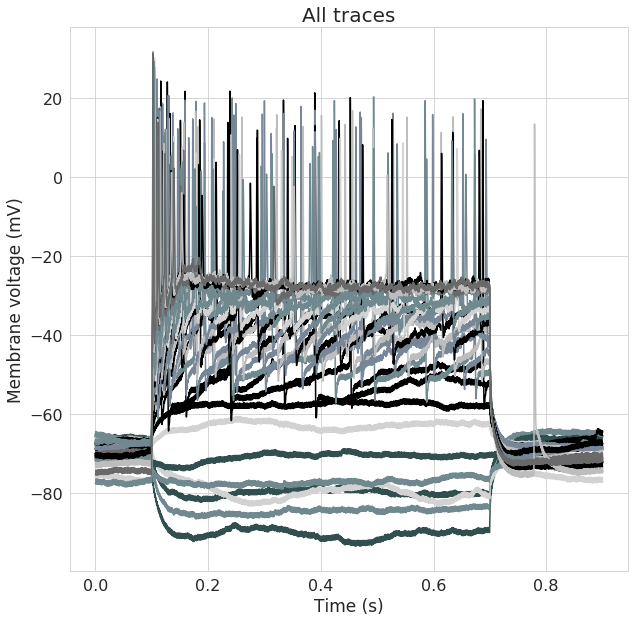

In [26]:
prel_inspection(L4_Neurolucida[146], L4_names_Neurolucida[146], current_stim_start_list[146])

In [180]:
directory = '../L4 Neurolucida/Figures/PrelInspection/'
prel_inspection_all(L4_Neurolucida, L4_names_Neurolucida, current_stim_start_list, directory)

Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 3 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 19 2017 slice 1 cell 3.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 17 2017 slice 1 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/10 19 2016 slice 3 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 06 2017 slice 5 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/06 22 2017 slice 3 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/01 30 2017 slice 4 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 3 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 4 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/06 07 2017 slice 1 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/04 05 2017 slice 1 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 11 2017 slice 3 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/BPC/04 05 2017 slice 1 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adul

Processing:  ../L4 Neurolucida/V1 adult/DBC/02 13 2017 slice 2 cell 3.mat
Processing:  ../L4 Neurolucida/V1 adult/DBC/08 24 2017 slice 1 cell 3.mat
Processing:  ../L4 Neurolucida/V1 adult/DBC/07 04 2017 slice 2 cell 6.mat
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 03 2017 slice 1 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 25 2017 slice 1 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 18 2017 slice 1 cell 3.mat
Processing:  ../L4 Neurolucida/V1 adult/HEC/01 31 2017 slice 3 cell 6.mat
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 03 2017 slice 2 cell 3.mat
Processing:  ../L4 Neurolucida/V1 adult/HEC/01 30 2017 slice 2 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/HEC/01 14 2017 slice 2 cell 5.mat
Processing:  ../L4 Neurolucida/V1 adult/HEC/10 23 2017 slice 3 cell 6.mat
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 03 2017 slice 1 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/HEC/05 08 2017 slice 4 cell 3.mat
Processing:  ../L4 Neurolucida/V1 adul

Processing:  ../L4 Neurolucida/V1 adult/NFC/03 21 2017 slice 5 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/NFC/09 05 2017 slice 1 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/NFC/06 15 2017 slice 1 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/NFC/06 15 2017 slice 3 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/NFC/07 05 2017 slice 3 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/sBC/04 28 2017 slice 1 cell 3.mat
Processing:  ../L4 Neurolucida/V1 adult/sBC/09 12 2017 slice 1 cell 7.mat
Processing:  ../L4 Neurolucida/V1 adult/sBC/03 17 2017 slice 3 cell 3.mat
Processing:  ../L4 Neurolucida/V1 adult/sBC/06 27 2017 slice 1 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/sBC/04 17 2017 slice 1 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/sBC/06 16 2017 slice 1 cell 3.mat
Processing:  ../L4 Neurolucida/V1 adult/sBC/10 09 2017 slice 2 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adult/sBC/01 19 2017 slice 1 cell 2.mat
Processing:  ../L4 Neurolucida/V1 adul

In [61]:
def plot_info(data, data_name, curr_hold, curr_start, el_num = 2, start = 0.1, end = 0.7, current_step = 20, axis = None):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on a particular
    trace of how certain features have been calculated.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    data_name : name/ID of the cell you are investigating
    curr_hold : current clamp (pA) before stimulation
    curr_start : current clamp (pA) for first hyperpolarising trace
    el_num : integer, from which electrode number you think has been measured (optional, 2 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    axis : axis you'd like to plot information on (optional, None by default)
    
    Returns
    -------
    ax : figure object
    """
    time, current, voltage = data_preparation(data, data_name, curr_start, el_num = el_num, current_step = current_step)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage, curr_hold, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features, curr_hold)
    plt.close()
    
    # First current magnitude (starting from the lowest absolute current stimulation magnitude value) where we find more than
    # three spikes
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=3)[0]
    if axis:
        ax = axis
    else: f, ax = plt.subplots(figsize = (10, 10))
    ax.plot(time, voltage[:, current_first], color = np.array([0, 0, 0]), label = None)
    
    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]
    
    
    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0]
    index_end_df = np.flatnonzero(df['threshold_i'].values >= current_first_magn)[0] + spike_count
    # When last spike is clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 1)
    # When the spike before the last spike is also clipped
    if df['clipped'].values[index_end_df-1]:
        index_end_df = np.flatnonzero(df['threshold_i'].values >= \
                                        current_first_magn)[0] + (spike_count - 2)
    
    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df : index_end_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df : index_end_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df : index_end_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df : index_end_df], dtype = int)
    fast_trough_index = np.array(fast_trough_index[~np.isnan(fast_trough_index)], dtype = int)
    slow_trough_index = df['slow_trough_index'].values[index_start_df : index_end_df]
    slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)
    
    start_index = (np.abs(time - start/10)).argmin() # Find closest index where the injection current starts (quite a bit before now)
    end_index = (np.abs(time - end)).argmin() # Find closest index where the injection current ends
    
    #ax.plot(time[np.abs(time - start/2).argmin()], Cell_Features['Rm (mV)'], 'C0.', ms = 15, label = None)
    ax.plot(time[thresh_index], voltage[thresh_index, current_first], 'b.', ms = 15, label = 'AP threshold')
    ax.plot(time[upstroke_index], voltage[upstroke_index, current_first], 'r.', ms = 15, label = 'AP upstroke')
    ax.plot(time[peak_index], voltage[peak_index, current_first], 'g.', ms = 15, label = 'AP peak')
    ax.plot(time[downstroke_index], voltage[downstroke_index, current_first], 'k.', ms = 15, label = 'AP downstroke')
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], 'y.', ms = 15, label = 'AP fast trough')
    ax.plot(time[slow_trough_index], voltage[slow_trough_index, current_first], 'm.', ms = 15, \
            label = 'AP slow trough\n(if applicable)')
    ax.set_xlim([time[start_index], time[end_index]])
    ax.set_xlabel('Time (s)', fontsize = 17)
    ax.set_ylabel('Membrane voltage (mV)', fontsize = 17)
    ax.set_title('Trace annotations', fontsize = 20)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    #ax.legend(['Resting Vm', 'Threshold', 'Upstroke', 'Peak', 'Downstroke', 'Fast trough', \
    #           'Slow trough (if applicable)'], fontsize = 15, loc='upper left', bbox_to_anchor=(1, 1))
    ax.legend(fontsize = 15, loc = 'upper right')
    
    # Nice annotations
    if len(thresh_index) > 2 :
        ax.plot(time[thresh_index[0:3]], voltage[thresh_index[0:3], current_first], '|', color = 'black', ms = 200)
        ax.annotate('', xy = (time[thresh_index[0]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'ec': 'grey', \
                                                   'connectionstyle': 'arc3', 'lw': 2, 'shrinkA': 0})
        ax.annotate('', xy = (time[thresh_index[1]], voltage[thresh_index[0], current_first] - 10), \
                xycoords = 'data', xytext = (time[thresh_index[2]], voltage[thresh_index[0], current_first] - 10), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'ec': 'grey', \
                                                   'connectionstyle': 'arc3', 'lw': 2, 'shrinkA': 0})
        ax.annotate('AI = (2e ISI / 1e ISI)*100', xy=(time[thresh_index[1]], voltage[thresh_index[1], current_first]-30), \
                 xycoords='data', xytext=(5, 0), textcoords='offset points', fontsize = 15)
    return ax

In [51]:
def plot_info_all(data_tuple, names, curr_hold_list, curr_start_list, directory, el_num = 2, \
                  start = 0.1, end = 0.7, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name, curr_hold, curr_start) in zip(data_tuple, names, curr_hold_list, curr_start_list):
        print('Processing: ', name)
        time, current, voltage = data_preparation(data, name, curr_start, el_num = el_num, \
                                                  current_step = current_step)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage, curr_hold, fil = filter_)
        if ~np.any(df_related_features['spike_count'] >= 3):         # There might be no traces with more than 3 spikes
                                                                     # whatsoever
            continue
        ax = plot_info(data, name, curr_hold, curr_start, el_num = el_num, start = start, end = end)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.86804725825787
Ri:  356.3207323849199


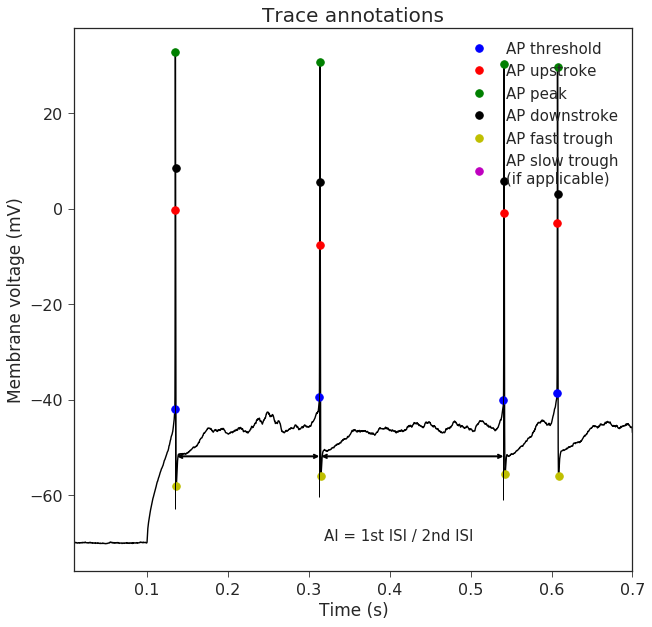

In [450]:
plot_info(L4_Neurolucida[1], L4_names_Neurolucida[1], current_hold_list[1], current_stim_start_list[1])

In [461]:
directory = '../L4 Neurolucida/Figures/TraceAnnotations/'
plot_info_all(L4_Neurolucida, L4_names_Neurolucida, current_hold_list, current_stim_start_list, directory)

Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.93952033340932
Ri:  336.45379149913765
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 19 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.86804725825787
Ri:  356.3207323849199
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 17 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.101099614053965
Ri:  160.66533739864826
Processing:  ../L4 Neurolucida/V1 adult/BPC/10 19 2016 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.67093878865242
Ri:  317.48552507162094
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 06 2017 slice 5 cell 2.mat
Rm:  -79.13670042037963
Ri:  304.4199016094208
Processing:  ../L4 Neurolucida/V1 adult/BPC/06 22 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.55689591795206
Ri:  290.04578515887266
Processing:  ../L4 Neurolucida/V1 adult/BPC/01 30 2017 slice 4 cell 7.mat
Rm:  -56.28868888795377
Ri:  382.17636263370514
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 3 cell 7.mat
Rm:  -72.25941976070405
Ri:  286.1609266549349
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.89263139426707
Ri:  407.4922988712789
Processing:  ../L4 Neurolucida/V1 adult/BPC/06 07 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.24377530559899
Ri:  305.69832845032215
Processing:  ../L4 Neurolucida/V1 adult/BPC/04 05 2017 slice 1 cell 2.mat
Rm:  -81.72399976670744
Ri:  319.19177834689606
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 11 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.54880906373262
Ri:  273.14803554117685
Processing:  ../L4 Neurolucida/V1 adult/BPC/04 05 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.12615000680089
Ri:  291.73563207685953
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 03 2017 slice 2 cell 7.mat
Rm:  -69.26795950710772
Ri:  258.37220609188086
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 5 cell 2.mat
Rm:  -68.73928315222264
Ri:  437.51224808394915
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 15 2017 slice 2 cell 3.mat
Rm:  -73.9059895080328
Ri:  222.62214198708534
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 17 2017 slice 4 cell 3.mat
Rm:  -66.46181458890439
Ri:  393.4156975597144
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 11 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -85.50852206349371
Ri:  283.93452075123787
Processing:  ../L4 Neurolucida/V1 adult/BPC/08 06 2017 slice 1 cell 2.mat
Rm:  -75.05154946923257
Ri:  262.12274417281145
Processing:  ../L4 Neurolucida/V1 adult/BPC/08 06 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.62914426743983
Ri:  217.3583673238754
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 19 2017 slice 2 cell 2.mat
Rm:  -78.27745651602746
Ri:  226.01543690264236
Processing:  ../L4 Neurolucida/V1 adult/BPC/02 24 2017 slice 3 cell 2.mat
Rm:  -63.759399041533484
Ri:  338.1702662408351
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 29 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.02015067845585
Ri:  315.46597377955914
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 18 2017 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -80.88766046881676
Ri:  413.93450400233274
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.83803762257098
Ri:  286.97878506779676
Processing:  ../L4 Neurolucida/V1 adult/BPC/04 28 2017 slice 3 cell 3.mat
Rm:  -80.61727136552335
Ri:  382.9484563767909
Processing:  ../L4 Neurolucida/V1 adult/BPC/02 10 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.0143410474062
Ri:  442.78033041954046
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 05 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.79834214389325
Ri:  393.77344542741764
Processing:  ../L4 Neurolucida/V1 adult/BPC/05 08 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.38117140740157
Ri:  291.836709573865
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 17 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.50533892691135
Ri:  259.5194514691831
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 29 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.04537636026738
Ri:  334.2955034524203
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 03 2017 slice 3 cell 2.mat
Rm:  -73.58335884034635
Ri:  360.99893204867834
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 11 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.88374993234874
Ri:  346.8724140077828
Processing:  ../L4 Neurolucida/V1 adult/BPC/04 28 2017 slice 5 cell 2.mat
Rm:  -72.01739747166633
Ri:  347.26351904869085
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 1 cell 7.mat
Rm:  -77.10399270534515
Ri:  258.4503163695335
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 1 cell 2.mat
Rm:  -77.25474007308483
Ri:  254.47696721553814
Processing:  ../L4 Neurolucida/V1 adult/martinotti/09 04 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.63570749759673
Ri:  236.84402379393592
Processing:  ../L4 Neurolucida/V1 adult/martinotti/05 03 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.25744551181793
Ri:  168.41831091046336
Processing:  ../L4 Neurolucida/V1 adult/martinotti/11 08 2016 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.401245922744266
Ri:  237.89698578417318
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 04 2017 slice 4 cell 7.mat
Rm:  -65.21278348684311
Ri:  111.79631309211254
Processing:  ../L4 Neurolucida/V1 adult/martinotti/09 04 2017 slice 4 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.21494390010832
Ri:  219.75274670124048
Processing:  ../L4 Neurolucida/V1 adult/martinotti/01 30 2017 slice 4 cell 3.mat
Rm:  -54.07868984103202
Ri:  114.40176072716716
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 28 2017 slice 2 cell 3.mat
Rm:  -53.958891753107316
Ri:  211.68496362864968
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 18 2017 slice 2 cell 7.mat
Rm:  -75.0033060157299
Ri:  262.782413840294
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 01 2017 slice 2 cell 2.mat
Rm:  -60.44541807442904
Ri:  247.19136324524874
Processing:  ../L4 Neurolucida/V1 adult/martinotti/05 03 2017 slice 1 cell 7.mat
Rm:  -61.01479805037379
Ri:  251.99859492480758
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 26 2016 slice 4 cell 2.mat
Rm:  -58.17610278606416
Ri:  163.3808439671993
Processing:  ../L4 Neurolucida/V1 adult/martinotti/06 07 2017 slice 4 cell 6.mat
Rm:  -75.0833885654807
Ri:  167.10641756653786
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.494158580899224
Ri:  163.4370724409818
Processing:  ../L4 Neurolucida/V1 adult/martinotti/11 30 2016 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.17289459258318
Ri:  298.9081900566817
Processing:  ../L4 Neurolucida/V1 adult/martinotti/09 11 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.84867594897747
Ri:  235.9756315946579
Processing:  ../L4 Neurolucida/V1 adult/martinotti/05 08 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.35342295154928
Ri:  238.1832095533609
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 03 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.87656277060508
Ri:  294.49685826897604
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 10 2017 slice 4 cell 2.mat
Rm:  -68.99153336316347
Ri:  234.69170404970643
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 22 2017 slice 2 cell 7.mat
Rm:  -76.14359728634358
Ri:  229.66419357061383
Processing:  ../L4 Neurolucida/V1 adult/martinotti/12 05 2016 slice 5 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.878009954094885
Ri:  260.330624550581
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 22 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.40748499572277
Ri:  276.79321205615986
Processing:  ../L4 Neurolucida/V1 adult/martinotti/04 05 2017 slice 5 cell 2.mat
Rm:  -58.44759209752082
Ri:  256.6518550217152
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 21 2017 slice 1 cell 7.mat
Rm:  -68.42430733174086
Ri:  307.41995766758924
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 21 2017 slice 3 cell 2.mat
Rm:  -59.256378877758976
Ri:  222.09048837423333
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 01 2017 slice 2 cell 7.mat
Rm:  -55.93651669666171
Ri:  202.88480646908297
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 27 2016 slice 2 cell 6.mat
Rm:  -56.606809581518164
Ri:  163.03044387698174
Processing:  ../L4 Neurolucida/V1 adult/martinotti/06 16 2017 slice 2 cell 7.mat
Rm:  -65.21894706144928
Ri:  205.65534333884713
Processing:  ../L4 Neurolucida/V1 adult/martinotti/04 17 2017 slice 1 cell 7.mat
Rm:  -67.94498068243266
Ri:  151.0761127024888
Processing:  ../L4 Neurolucida/V1 adult/martinott

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.63584570974112
Ri:  247.3051657527686
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 04 2017 slice 4 cell 2.mat
Rm:  -70.46391982674598
Ri:  180.05467589199537
Processing:  ../L4 Neurolucida/V1 adult/martinotti/06 15 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.53161632031201
Ri:  124.9037515372038
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 05 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.88993292868138
Ri:  260.7371889948844
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 10 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.90096818447114
Ri:  250.36038643121722
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 21 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.37871603220702
Ri:  329.3067199736833
Processing:  ../L4 Neurolucida/V1 adult/martinotti/06 15 2017 slice 2 cell 2.mat
Rm:  -65.6358227312565
Ri:  207.9963041543961
Processing:  ../L4 Neurolucida/V1 adult/martinotti/05 08 2017 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.95828299373387
Ri:  201.4179862886668
Processing:  ../L4 Neurolucida/V1 adult/martinotti/05 03 2017 slice 1 cell 5.mat
Rm:  -60.39477384358646
Ri:  613.0403204411267
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 04 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.17031153768299
Ri:  183.544461414218
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 04 2017 slice 2 cell 2.mat
Rm:  -68.98678398251535
Ri:  211.342884004116
Processing:  ../L4 Neurolucida/V1 adult/martinotti/04 17 2017 slice 4 cell 7.mat
Rm:  -77.81024493813513
Ri:  202.27695882320404
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 12 2017 slice 1 cell 2.mat
Rm:  -69.29589329481125
Ri:  280.5564840734005
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 04 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.04506243646146
Ri:  172.75514319539064
Processing:  ../L4 Neurolucida/V1 adult/martinotti/11 01 2016 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -37.23789593398571
Ri:  189.27152648568148
Processing:  ../L4 Neurolucida/V1 adult/martinotti/03 28 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.7617708438635
Ri:  175.37822979688633
Processing:  ../L4 Neurolucida/V1 adult/martinotti/02 09 2017 slice 3 cell 5.mat
Rm:  -57.222943785488596
Ri:  276.4229195863009
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 27 2016 slice 2 cell 2.mat
Rm:  -50.0160731559992
Ri:  225.48140329122535
Processing:  ../L4 Neurolucida/V1 adult/martinotti/03 23 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.6824128177762
Ri:  305.94148464500904
Processing:  ../L4 Neurolucida/V1 adult/martinotti/06 23 2017 slice 2 cell 2.mat
Rm:  -67.82110871493818
Ri:  190.87062245607373
Processing:  ../L4 Neurolucida/V1 adult/martinotti/01 30 2017 slice 4 cell 2.mat
Rm:  -64.82971778064967
Ri:  293.9851730018854
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 22 2017 slice 3 cell 2.mat
Rm:  -63.4477064180374
Ri:  196.94052058458334
Processing:  ../L4 Neurolucida/V1 adult/martinotti/03 29 2017 slice 2 cell 2.mat
Rm:  -62.743913758099076
Ri:  197.90035574138176
Processing:  ../L4 Neurolucida/V1 adult/DBC/11 29 2016 slice 4 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.923451808094974
Ri:  203.90059643983835
Processing:  ../L4 Neurolucida/V1 adult/DBC/12 05 2016 slice 1 cell 2.mat
Rm:  -73.25217131376266
Ri:  192.10413581132886
Processing:  ../L4 Neurolucida/V1 adult/DBC/02 12 2017 slice 5 cell 7.mat
Rm:  -63.84769646018743
Ri:  123.78808595240123
Processing:  ../L4 Neurolucida/V1 adult/DBC/02 12 2017 slice 2 cell 7.mat
Rm:  -72.25713749825954
Ri:  138.1653878390789
Processing:  ../L4 Neurolucida/V1 adult/DBC/03 28 2017 slice 5 cell 2.mat
Rm:  -74.62534954577684
Ri:  139.68624962866312
Processing:  ../L4 Neurolucida/V1 adult/DBC/10 18 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.77216246545314
Ri:  121.06566900014883
Processing:  ../L4 Neurolucida/V1 adult/DBC/08 22 2017 slice 5 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.06474300831557
Ri:  128.87615691125396
Processing:  ../L4 Neurolucida/V1 adult/DBC/07 19 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.45402196586132
Ri:  119.96104407310486
Processing:  ../L4 Neurolucida/V1 adult/DBC/05 16 2017 slice 1 cell 6.mat
Rm:  -69.06664327859878
Ri:  110.40655970573421
Processing:  ../L4 Neurolucida/V1 adult/DBC/11 29 2016 slice 4 cell 7.mat
Rm:  -60.26671855777503
Ri:  158.09846599400043
Processing:  ../L4 Neurolucida/V1 adult/DBC/05 10 2017 slice 3 cell 2.mat
Rm:  -79.80243541449309
Ri:  130.10515417158604
Processing:  ../L4 Neurolucida/V1 adult/DBC/04 03 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.35984535589814
Ri:  105.50503031909466
Processing:  ../L4 Neurolucida/V1 adult/DBC/05 10 2017 slice 3 cell 6.mat
Rm:  -70.4628205960989
Ri:  138.39764940738678
Processing:  ../L4 Neurolucida/V1 adult/DBC/01 12 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.56777225762605
Ri:  226.42902524769295
Processing:  ../L4 Neurolucida/V1 adult/DBC/09 12 2017 slice 3 cell 3.mat
Rm:  -72.5702996736765
Ri:  150.18625219166282
Processing:  ../L4 Neurolucida/V1 adult/DBC/11 29 2016 slice 3 cell 7.mat
Rm:  -68.72780725747346
Ri:  132.1641672700645
Processing:  ../L4 Neurolucida/V1 adult/DBC/07 17 2017 slice 4 cell 3.mat
Rm:  -75.5097038412094
Ri:  136.3081696629525
Processing:  ../L4 Neurolucida/V1 adult/DBC/03 17 2017 slice 1 cell 2.mat
Rm:  -64.620883923769
Ri:  165.22173175215732
Processing:  ../L4 Neurolucida/V1 adult/DBC/02 13 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.25449693411589
Ri:  158.61107239127162
Processing:  ../L4 Neurolucida/V1 adult/DBC/08 24 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.43973845601082
Ri:  117.6521617472173
Processing:  ../L4 Neurolucida/V1 adult/DBC/07 04 2017 slice 2 cell 6.mat
Rm:  -73.1996134096384
Ri:  150.0266809314489
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 03 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.8759620398283
Ri:  126.00393247604374
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 25 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.86926945179701
Ri:  117.00204817950736
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 18 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.19669836640358
Ri:  217.67934095859536
Processing:  ../L4 Neurolucida/V1 adult/HEC/01 31 2017 slice 3 cell 6.mat
Rm:  -67.08568535521627
Ri:  186.4009730666875
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 03 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.73253655046224
Ri:  171.37313540279874
Processing:  ../L4 Neurolucida/V1 adult/HEC/01 30 2017 slice 2 cell 2.mat
Rm:  -67.66989536464214
Ri:  137.74924021959308
Processing:  ../L4 Neurolucida/V1 adult/HEC/01 14 2017 slice 2 cell 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.23922800302505
Ri:  296.9104116857052
Processing:  ../L4 Neurolucida/V1 adult/HEC/10 23 2017 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.02408696338534
Ri:  168.89942242205143
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 03 2017 slice 1 cell 2.mat
Rm:  -66.8986079749465
Ri:  117.22212110459816
Processing:  ../L4 Neurolucida/V1 adult/HEC/05 08 2017 slice 4 cell 3.mat
Rm:  -66.42029956549405
Ri:  135.786959514022
Processing:  ../L4 Neurolucida/V1 adult/HEC/03 06 2017 slice 5 cell 7.mat
Rm:  -60.24400263011456
Ri:  237.98802280426028
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/01 14 2017 slice 2 cell 2.mat
Rm:  -80.16763269960879
Ri:  232.07118543982511
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/11 23 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.35005479156969
Ri:  151.68605437874794
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 19 2016 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.99185250043867
Ri:  228.08032877743253
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/01 12 2017 slice 1 cell 2.mat
Rm:  -71.1847576534748
Ri:  307.3492168188096
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 5 cell 2.mat
Rm:  -45.062679633498206
Ri:  302.5860393047331
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/11 23 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.70568154245613
Ri:  196.33557085692888
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 1 cell 6.mat
Rm:  -83.76968140542508
Ri:  240.29944142699253
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 4 cell 2.mat
Rm:  -47.77506110072137
Ri:  315.29334262013424
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 26 2016 slice 3 cell 7.mat
Rm:  -65.05387715607883
Ri:  174.28348512947557
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/03 06 2017 slice 2 cell 7.mat
Rm:  -62.77251637041569
Ri:  279.18458840250975
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/02 12 2017 slice 6 cell 7.mat
Rm:  -77.0854611352086
Ri:  146.12440668046463
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 27 2016 slice 3 cell 3.mat
Rm:  -63.05191592454911
Ri:  252.7237690091132
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 27 2016 slice 5 cell 6.mat
Rm:  -76.70796550124882
Ri:  226.38651181757453
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/02 24 20

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.41377196252346
Ri:  146.27448949217793
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 27 2016 slice 4 cell 3.mat
Rm:  -75.58956754803658
Ri:  203.91062337160105
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/04 03 2017 slice 4 cell 7.mat
Rm:  -45.91056255862117
Ri:  339.5352401584387
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/02 12 2017 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.96540016055107
Ri:  259.622387945652
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 1 cell 7.mat
Rm:  -79.96882117271423
Ri:  238.90695640444764
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/05 10 2017 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.33589838236569
Ri:  287.78583607077604
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 19 2016 slice 4 cell 6.mat
Rm:  -71.2942724454403
Ri:  285.8215798735619
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/11 23 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.92607806652784
Ri:  209.5158989876509
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/03 06 2017 slice 3 cell 7.mat
Rm:  -66.57983818620444
Ri:  361.61994080245495
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 4 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.2086921441555
Ri:  308.66701242327684
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 19 2016 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.05463052034378
Ri:  171.0321015119552
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/01 30 2017 slice 2 cell 7.mat
Rm:  -70.01297527730465
Ri:  275.48490998148924
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 27 2016 slice 1 cell 7.mat
Rm:  -57.38472470730543
Ri:  192.57758839428428
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 20 2016 slice 4 cell 5.mat
Rm:  -76.77708445399999
Ri:  276.78807945549505
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 19 2016 slice 2 cell 7.mat
Rm:  -62.158447022736084
Ri:  256.03173534572124
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.75049727886915
Ri:  345.8871136456728
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/05 11 2017 slice 2 cell 6.mat
Rm:  -70.46256488442421
Ri:  242.37500438094145
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/03 15 2017 slice 1 cell 7.mat
Rm:  -79.59851111233233
Ri:  154.6858162283897
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/01 19 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.62913868024945
Ri:  359.6328573971987
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/05 11 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.05498592421412
Ri:  242.15643654763704
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/05 11 2017 slice 1 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.92649952113628
Ri:  296.68597605824476
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/11 08 2016 slice 1 cell 2.mat
Rm:  -81.22278807044029
Ri:  135.11907774209982
Processing:  ../L4 Neurolucida/V1 adult/BC/02 12 2017 slice 3 cell 7.mat
Rm:  -69.64522740721704
Ri:  149.34723135828966
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.17783396527171
Ri:  194.87009001523262
Processing:  ../L4 Neurolucida/V1 adult/BC/06 15 2017 slice 2 cell 7.mat
Rm:  -76.18835350483656
Ri:  161.23593924939638
Processing:  ../L4 Neurolucida/V1 adult/BC/07 25 2017 slice 1 cell 7.mat
Rm:  -56.673555167913435
Ri:  124.38284522294995
Processing:  ../L4 Neurolucida/V1 adult/BC/06 16 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.98060680180788
Ri:  104.12241302430628
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 2 cell 2.mat
Rm:  -64.48896332114934
Ri:  104.53596837818631
Processing:  ../L4 Neurolucida/V1 adult/BC/09 04 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.20844296455383
Ri:  410.44953083992004
Processing:  ../L4 Neurolucida/V1 adult/BC/05 16 2017 slice 1 cell 7.mat
Rm:  -59.12680636793376
Ri:  126.21155104041095
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 1 cell 7.mat
Rm:  -68.36691669747235
Ri:  125.66525401175019
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 4 cell 2.mat
Rm:  -72.04343699127435
Ri:  123.66165281832231
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 4 cell 3.mat
Rm:  -75.07532825633884
Ri:  142.23765923082829
Processing:  ../L4 Neurolucida/V1 adult/BC/04 03 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.26675873756409
Ri:  165.72824537754045
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.2507039898634
Ri:  104.17135936021809
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 3 cell 2.mat
Rm:  -62.820596116483216
Ri:  158.23307922482493
Processing:  ../L4 Neurolucida/V1 adult/BC/07 05 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.57749874472617
Ri:  190.32977673411384
Processing:  ../L4 Neurolucida/V1 adult/BC/03 17 2017 slice 4 cell 7.mat
Rm:  -73.85710947275162
Ri:  173.4650851786136
Processing:  ../L4 Neurolucida/V1 adult/BC/08 22 2017 slice 3 cell 6.mat
Rm:  -55.10604658365251
Ri:  184.65572336316114
Processing:  ../L4 Neurolucida/V1 adult/BC/01 31 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.902856371104725
Ri:  133.41284023225307
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.46822464525698
Ri:  166.39559730887422
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 1 cell 7.mat
Rm:  -65.67448130816221
Ri:  92.21075274050241
Processing:  ../L4 Neurolucida/V1 adult/BC/03 06 2017 slice 1 cell 2.mat
Rm:  -58.09969629645347
Ri:  114.0666926950216
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 1 cell 2.mat
Rm:  -67.7531131118536
Ri:  101.41454400122163
Processing:  ../L4 Neurolucida/V1 adult/BC/05 16 2017 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.20286083191633
Ri:  164.05941043794155
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 2 cell 4.mat
Rm:  -74.3660563352704
Ri:  135.88131140172487
Processing:  ../L4 Neurolucida/V1 adult/BC/02 24 2017 slice 1 cell 2.mat
Rm:  -66.48828937262297
Ri:  189.00650046765801
Processing:  ../L4 Neurolucida/V1 adult/BC/05 16 2017 slice 1 cell 2.mat
Rm:  -65.16057269632816
Ri:  134.26543170213694
Processing:  ../L4 Neurolucida/V1 adult/BC/04 28 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.95278296828269
Ri:  157.38703116774565
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 2 cell 4.mat
Rm:  -74.961872549057
Ri:  101.64706157147883
Processing:  ../L4 Neurolucida/V1 adult/BC/10 31 2016 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.18262166947127
Ri:  227.7568504661321
Processing:  ../L4 Neurolucida/V1 adult/BC/01 14 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.93644682168961
Ri:  224.20534048974514
Processing:  ../L4 Neurolucida/V1 adult/BC/08 02 2017 slice 2 cell 2.mat
Rm:  -69.83100884854792
Ri:  158.0444498062135
Processing:  ../L4 Neurolucida/V1 adult/BC/07 19 2017 slice 4 cell 6.mat
Rm:  -73.55761284023524
Ri:  151.62730570137498
Processing:  ../L4 Neurolucida/V1 adult/BC/05 16 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.50375490695238
Ri:  107.87486775219443
Processing:  ../L4 Neurolucida/V1 adult/BC/01 23 2017 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.24249844014645
Ri:  251.10617411136627
Processing:  ../L4 Neurolucida/V1 adult/BC/07 05 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.48804307818413
Ri:  117.78470826148993
Processing:  ../L4 Neurolucida/V1 adult/BC/04 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.4842335243523
Ri:  134.00499849021435
Processing:  ../L4 Neurolucida/V1 adult/BC/01 14 2017 slice 2 cell 7.mat
Rm:  -67.23698836296796
Ri:  122.42854161560543
Processing:  ../L4 Neurolucida/V1 adult/BC/08 31 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.48246837079525
Ri:  95.34217068552974
Processing:  ../L4 Neurolucida/V1 adult/BC/11 01 2016 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.54080001890658
Ri:  160.78850638866425
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 4 cell 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.9923074477911
Ri:  196.77025151252747
Processing:  ../L4 Neurolucida/V1 adult/BC/07 19 2017 slice 1 cell 2.mat
Rm:  -67.55818583190441
Ri:  106.97461874783032
Processing:  ../L4 Neurolucida/V1 adult/BC/07 19 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.43867860168218
Ri:  99.58202047646054
Processing:  ../L4 Neurolucida/V1 adult/BC/07 06 2017 slice 3 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.05472723037006
Ri:  170.89468340575692
Processing:  ../L4 Neurolucida/V1 adult/BC/01 27 2017 slice 4 cell 7.mat
Rm:  -72.44041175007821
Ri:  213.69639435410505
Processing:  ../L4 Neurolucida/V1 adult/NFC/04 28 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.68198823720216
Ri:  178.16638727486136
Processing:  ../L4 Neurolucida/V1 adult/NFC/07 19 2017 slice 2 cell 7.mat
Rm:  -58.35633181273938
Ri:  330.0645270645619
Processing:  ../L4 Neurolucida/V1 adult/NFC/09 06 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.31219434082509
Ri:  189.40399669110772
Processing:  ../L4 Neurolucida/V1 adult/NFC/02 24 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.90822674483061
Ri:  181.44595132768148
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 21 2017 slice 4 cell 2.mat
Rm:  -74.9625868152082
Ri:  185.8660820871593
Processing:  ../L4 Neurolucida/V1 adult/NFC/02 24 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.12009237110614
Ri:  241.13056683540344
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 06 2017 slice 1 cell 7.mat
Rm:  -59.328099202215675
Ri:  157.5957555621861
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 21 2017 slice 1 cell 2.mat
Rm:  -69.51643863886595
Ri:  273.28337821364397
Processing:  ../L4 Neurolucida/V1 adult/NFC/06 29 2017 slice 1 cell 7.mat
Rm:  -67.2739293654263
Ri:  208.0064051002264
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 15 2017 slice 5 cell 2.mat
Rm:  -67.30594783067703
Ri:  132.9983281195164
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 29 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.4336488494277
Ri:  210.68554778397092
Processing:  ../L4 Neurolucida/V1 adult/NFC/09 06 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.43307151556016
Ri:  169.87017679214475
Processing:  ../L4 Neurolucida/V1 adult/NFC/04 28 2017 slice 5 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.56518715769053
Ri:  202.2188562303781
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 21 2017 slice 5 cell 2.mat
Rm:  -73.60219377130271
Ri:  169.42920151352874
Processing:  ../L4 Neurolucida/V1 adult/NFC/09 05 2017 slice 1 cell 7.mat
Rm:  -67.25366806060076
Ri:  121.79237046837797
Processing:  ../L4 Neurolucida/V1 adult/NFC/06 15 2017 slice 1 cell 2.mat
Rm:  -71.51255515307187
Ri:  241.33655147254476
Processing:  ../L4 Neurolucida/V1 adult/NFC/06 15 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.83824575126171
Ri:  167.18714073300364
Processing:  ../L4 Neurolucida/V1 adult/NFC/07 05 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.35973936021328
Ri:  192.54857438802716
Processing:  ../L4 Neurolucida/V1 adult/sBC/04 28 2017 slice 1 cell 3.mat
Rm:  -77.82736810058356
Ri:  201.11396576464182
Processing:  ../L4 Neurolucida/V1 adult/sBC/09 12 2017 slice 1 cell 7.mat
Rm:  -74.94083481371402
Ri:  139.6371870040894
Processing:  ../L4 Neurolucida/V1 adult/sBC/03 17 2017 slice 3 cell 3.mat
Rm:  -75.6740398427844
Ri:  257.24355150759226
Processing:  ../L4 Neurolucida/V1 adult/sBC/06 27 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.97400209188461
Ri:  182.28213003277776
Processing:  ../L4 Neurolucida/V1 adult/sBC/04 17 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.8850598603487
Ri:  202.3848200440407
Processing:  ../L4 Neurolucida/V1 adult/sBC/06 16 2017 slice 1 cell 3.mat
Rm:  -74.46510272085668
Ri:  269.7313144505024
Processing:  ../L4 Neurolucida/V1 adult/sBC/10 09 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.89345121264458
Ri:  135.33910632133484
Processing:  ../L4 Neurolucida/V1 adult/sBC/01 19 2017 slice 1 cell 2.mat
Rm:  -66.73809511139989
Ri:  200.71331678330898
Processing:  ../L4 Neurolucida/V1 adult/sBC/01 23 2017 slice 3 cell 2.mat
Rm:  -61.656903460025795
Ri:  175.66290992498392
Processing:  ../L4 Neurolucida/V1 adult/sBC/06 28 2017 slice 3 cell 2.mat
Rm:  -67.04044105887414
Ri:  120.00932973623277
Processing:  ../L4 Neurolucida/V1 adult/sBC/06 28 2017 slice 3 cell 6.mat
Rm:  -68.36793078422548
Ri:  163.81928461790076
Processing:  ../L4 Neurolucida/V1 adult/sBC/03 29 2017 slice 4 cell 2.mat
Rm:  -64.3074025309086
Ri:  208.30894923210133
Processing:  ../L4 Neurolucida/V1 adult/sBC/03 28 2017 slice 6 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.44010016530751
Ri:  178.19112785160544
Processing:  ../L4 Neurolucida/V1 adult/sBC/08 31 2017 slice 1 cell 2.mat
Rm:  -72.51967525184155
Ri:  187.0639917254449
Processing:  ../L4 Neurolucida/V1 adult/sBC/02 10 2017 slice 4 cell 3.mat
Rm:  -75.10689304530621
Ri:  151.19890648126596
Processing:  ../L4 Neurolucida/V1 adult/sBC/03 06 2017 slice 6 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.04730843394994
Ri:  245.22515438497066


In [64]:
def plot_info_first_peak(data, data_name, curr_hold, curr_start, el_num = 2, start = 0.1, end = 0.7, current_step = 20, \
                            axis = None):
    """ Analyses a specific data dictionary corresponding to a cell and returns a figure object with annotations on the first
    peak of a particular trace of how certain features have been calculated. Works for data extracted from .mat files, not for
    .asc files.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    data_name : name/ID of the cell you are investigating
    curr_hold : current clamp (pA) before stimulation
    curr_start : current clamp (pA) for first hyperpolarising trace
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    axis : axis you'd like to plot information on (optional, None by default)
    
    Returns
    -------
    ax : figure object
    """
    time, current, voltage = data_preparation(data, data_name, curr_start, el_num = el_num, \
                                                            current_step = current_step)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage, curr_hold, fil = filter_)
    Cell_Features = get_cell_features(df, df_related_features, curr_hold)
    plt.close()
    current_first = np.flatnonzero(df_related_features['spike_count'].values >=1)[0]


    # Actual current there
    current_first_magn = current[current_first]
    # Amount of spikes there
    spike_count = df_related_features['spike_count'].values[current_first]


    # Find start and end indexes in df for all the spikes in that particular train
    index_start_df = np.flatnonzero(df['threshold_i'].values >= \
                        current_first_magn)[0]

    # Get threshold, peak, upstroke and downstroke indexes
    thresh_index = np.array(df['threshold_index'].values[index_start_df], dtype = int)
    upstroke_index = np.array(df['upstroke_index'].values[index_start_df], dtype = int)
    peak_index = np.array(df['peak_index'].values[index_start_df], dtype = int)
    downstroke_index = np.array(df['downstroke_index'].values[index_start_df], dtype = int)
    fast_trough_index = np.array(df['fast_trough_index'].values[index_start_df], dtype = int)
    slow_trough_index = np.array(df['slow_trough_index'].values[index_start_df], dtype = int)
    adp_index = np.array(df['adp_index'].values[index_start_df], dtype = int)
    #slow_trough_index = np.array(slow_trough_index[~np.isnan(slow_trough_index)], dtype = int)

    
    start_index = thresh_index - 50
    if slow_trough_index.size & (adp_index > 0):
        end_index = adp_index + 50 # Plot 50 time indices after the adp index
    else: end_index = fast_trough_index + 50 # Plot 50 time indices after the fast trough index (should always exist)
    
    # When first spike is clipped
    if df['clipped'].values[index_start_df]:
        return
    if axis:
        ax = axis
    else: f, ax = plt.subplots(figsize = (10, 5))
    sns.set_context(rc={'lines.markeredgewidth': 1})
    ax.plot(time[start_index : end_index], voltage[start_index : end_index, current_first], color = np.array([0, 0, 0]), \
                label = None)

    ax.plot(time[thresh_index], voltage[thresh_index, current_first], 'b.', ms = 15, label = 'AP threshold')
    ax.plot(time[upstroke_index], voltage[upstroke_index, current_first], 'r.', ms = 15, label = 'AP upstroke')
    ax.plot(time[peak_index], voltage[peak_index, current_first], 'g.', ms = 15, label = 'AP peak')
    ax.plot(time[downstroke_index], voltage[downstroke_index, current_first], 'k.', ms = 15, label = 'AP downstroke')
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], 'y.', ms = 15, label = 'AP fast trough')
    if slow_trough_index.size & (adp_index > 0):
        ax.plot(time[adp_index], voltage[adp_index, current_first], 'c.', ms = 15, label = 'ADP')
        #ax.plot(time[slow_trough_index], voltage[slow_trough_index, current_first], 'm.', ms = 15, label = \
        #       'AP slow trough\n(if applicable)')
    ax.legend(fontsize = 15, loc = 'upper right')
    ax.set_xlabel('Time (s)', fontsize = 17)
    ax.set_ylabel('Membrane voltage (mV)', fontsize = 17)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.set_title('First peak annotations', fontsize = 20)

    # Nice annotations
    
    # For the AP amplitude
    ax.annotate('', xy = (time[peak_index], voltage[peak_index, current_first]), \
                xycoords = 'data', xytext = (time[peak_index], voltage[thresh_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'ec': 'grey', \
                                                   'connectionstyle': 'arc3', 'lw': 2, 'shrinkB': 0})
    
    ax.plot(time[peak_index], voltage[thresh_index, current_first], marker = '_', color = 'black', ms = 100)
    ax.plot(time[peak_index], voltage[peak_index, current_first], marker = '_', color = 'black', ms = 100)

    # For the AP width
    width_level = (voltage[peak_index, current_first] - voltage[thresh_index, current_first])/2 + \
                   voltage[thresh_index, current_first]
    width_start_index = peak_index - np.flatnonzero(voltage[peak_index : thresh_index:-1, current_first] <= width_level)[0]
    width_end_index = peak_index + np.flatnonzero(voltage[peak_index: fast_trough_index, current_first] <=width_level)[0]
    ax.plot(time[width_start_index], voltage[width_end_index, current_first], '|', color = 'black', ms = 100)
    ax.plot(time[width_end_index], voltage[width_end_index, current_first], '|', color = 'black', ms = 100)

    # The width itself is calculated based on t[width_end_index] - t[width_start_index], but the voltages might be different
    # at the respective indices, thus we choose the arrow to go from v[width_end_index] to v[width_end_index] to make
    # it horizontal (interpretability of the figure improves)
    ax.annotate('', xy = (time[width_start_index], voltage[width_end_index, current_first]), \
                xycoords = 'data', xytext = (time[width_end_index], voltage[width_end_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'ec': 'grey', \
                                                   'connectionstyle': 'arc3', 'lw': 2, 'shrinkA': 0})
    ax.annotate('AP width', xy = (time[width_start_index], \
                 width_level - 5), xycoords='data', xytext = (5, -15), textcoords = 'offset points', fontsize = 15)

    # We still need to annotate the AP amplitude based on the width_level!
    ax.annotate('AP amplitude', xy = (time[peak_index], width_level + 30), \
                 xycoords = 'data', xytext = (5, 0), textcoords = 'offset points', fontsize = 15)
    
    # For the AHP
    ax.plot(time[fast_trough_index], voltage[thresh_index, current_first], marker = "_", color = 'black', ms = 100)
    ax.plot(time[fast_trough_index], voltage[fast_trough_index, current_first], marker = "_", color = 'black', ms = 100)
    ax.annotate('', xy = (time[fast_trough_index], voltage[thresh_index, current_first]), \
                xycoords = 'data', xytext = (time[fast_trough_index], voltage[fast_trough_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'ec': 'grey', \
                                                   'connectionstyle': 'arc3', 'lw': 2, 'shrinkB': 0})
    fast_trough_level = (voltage[thresh_index, current_first] - voltage[fast_trough_index, current_first])/2 + \
                   voltage[fast_trough_index, current_first]
    ax.annotate('AHP', xy = (time[fast_trough_index], fast_trough_level), \
                xycoords = 'data', xytext = (10, -5), textcoords = 'offset points', fontsize = 15)
    
    # For a possible ADP
    if slow_trough_index.size & (adp_index > 0):
        ax.plot(time[adp_index], voltage[adp_index, current_first], marker = "_", color = 'black', ms = 100)
        ax.plot(time[adp_index], voltage[fast_trough_index, current_first], marker = "_", color = 'black', ms = 100)
        ax.annotate('', xy = (time[adp_index], voltage[fast_trough_index, current_first]), \
                xycoords = 'data', xytext = (time[adp_index], voltage[adp_index, current_first]), \
                textcoords = 'data', arrowprops = {'arrowstyle': '<->', 'ec': 'grey', \
                                                   'connectionstyle': 'arc3', 'lw': 2, 'shrinkB': 0})
        adp_level = (voltage[adp_index, current_first] - voltage[fast_trough_index, current_first])/2 + \
                   voltage[fast_trough_index, current_first]
        ax.annotate('ADP', xy = (time[adp_index], adp_level), \
                xycoords = 'data', xytext = (10, -5), textcoords = 'offset points', fontsize = 15)
    
    return ax

In [53]:
def plot_info_first_peak_all(data_tuple, names, curr_hold_list, curr_start_list, directory, el_num = 2, start = 0.1, \
                             end = 0.7, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name, curr_hold, curr_start) in zip(data_tuple, names, curr_hold_list, curr_start_list):
        print('Processing: ', name)
        time, current, voltage = data_preparation(data, name, curr_start, el_num = el_num, \
                                                                current_step = current_step)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage, curr_hold, fil = filter_)
        if ~np.any(df_related_features['spike_count'] >= 1):
            continue
        ax = plot_info_first_peak(data, name, curr_hold, curr_start, start = start, end = end)
        plt.title(name.split('/')[-1].split('.')[0], fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.55689591795206
Ri:  290.04578515887266
4839
5000


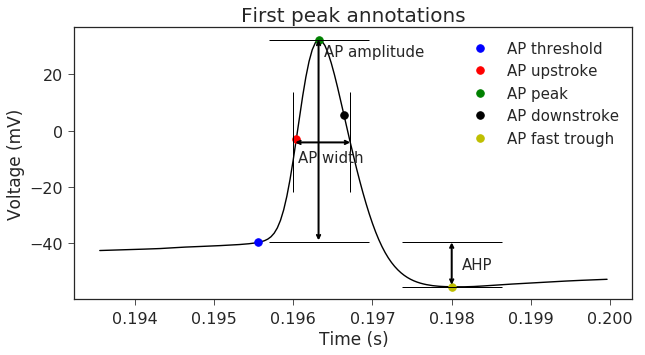

In [429]:
plot_info_first_peak(L4_Neurolucida[5], L4_names_Neurolucida[5], current_hold_list[5], current_stim_start_list[5])

In [462]:
directory = '../L4 Neurolucida/Figures/FirstPeakAnnotations/'
plot_info_first_peak_all(L4_Neurolucida, L4_names_Neurolucida, current_hold_list, current_stim_start_list, directory)

Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.93952033340932
Ri:  336.45379149913765
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 19 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.86804725825787
Ri:  356.3207323849199
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 17 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.101099614053965
Ri:  160.66533739864826
Processing:  ../L4 Neurolucida/V1 adult/BPC/10 19 2016 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.67093878865242
Ri:  317.48552507162094
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 06 2017 slice 5 cell 2.mat
Rm:  -79.13670042037963
Ri:  304.4199016094208
Processing:  ../L4 Neurolucida/V1 adult/BPC/06 22 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.55689591795206
Ri:  290.04578515887266
Processing:  ../L4 Neurolucida/V1 adult/BPC/01 30 2017 slice 4 cell 7.mat
Rm:  -56.28868888795377
Ri:  382.17636263370514
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 3 cell 7.mat
Rm:  -72.25941976070405
Ri:  286.1609266549349
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.89263139426707
Ri:  407.4922988712789
Processing:  ../L4 Neurolucida/V1 adult/BPC/06 07 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.24377530559899
Ri:  305.69832845032215
Processing:  ../L4 Neurolucida/V1 adult/BPC/04 05 2017 slice 1 cell 2.mat
Rm:  -81.72399976670744
Ri:  319.19177834689606
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 11 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.54880906373262
Ri:  273.14803554117685
Processing:  ../L4 Neurolucida/V1 adult/BPC/04 05 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.12615000680089
Ri:  291.73563207685953
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 03 2017 slice 2 cell 7.mat
Rm:  -69.26795950710772
Ri:  258.37220609188086
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 5 cell 2.mat
Rm:  -68.73928315222264
Ri:  437.51224808394915
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 15 2017 slice 2 cell 3.mat
Rm:  -73.9059895080328
Ri:  222.62214198708534
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 17 2017 slice 4 cell 3.mat
Rm:  -66.46181458890439
Ri:  393.4156975597144
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 11 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -85.50852206349371
Ri:  283.93452075123787
Processing:  ../L4 Neurolucida/V1 adult/BPC/08 06 2017 slice 1 cell 2.mat
Rm:  -75.05154946923257
Ri:  262.12274417281145
Processing:  ../L4 Neurolucida/V1 adult/BPC/08 06 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.62914426743983
Ri:  217.3583673238754
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 19 2017 slice 2 cell 2.mat
Rm:  -78.27745651602746
Ri:  226.01543690264236
Processing:  ../L4 Neurolucida/V1 adult/BPC/02 24 2017 slice 3 cell 2.mat
Rm:  -63.759399041533484
Ri:  338.1702662408351
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 29 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.02015067845585
Ri:  315.46597377955914
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 18 2017 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -80.88766046881676
Ri:  413.93450400233274
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.83803762257098
Ri:  286.97878506779676
Processing:  ../L4 Neurolucida/V1 adult/BPC/04 28 2017 slice 3 cell 3.mat
Rm:  -80.61727136552335
Ri:  382.9484563767909
Processing:  ../L4 Neurolucida/V1 adult/BPC/02 10 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.0143410474062
Ri:  442.78033041954046
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 05 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.79834214389325
Ri:  393.77344542741764
Processing:  ../L4 Neurolucida/V1 adult/BPC/05 08 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.38117140740157
Ri:  291.836709573865
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 17 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.50533892691135
Ri:  259.5194514691831
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 29 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.04537636026738
Ri:  334.2955034524203
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 03 2017 slice 3 cell 2.mat
Rm:  -73.58335884034635
Ri:  360.99893204867834
Processing:  ../L4 Neurolucida/V1 adult/BPC/03 11 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.88374993234874
Ri:  346.8724140077828
Processing:  ../L4 Neurolucida/V1 adult/BPC/04 28 2017 slice 5 cell 2.mat
Rm:  -72.01739747166633
Ri:  347.26351904869085
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 1 cell 7.mat
Rm:  -77.10399270534515
Ri:  258.4503163695335
Processing:  ../L4 Neurolucida/V1 adult/BPC/07 17 2017 slice 1 cell 2.mat
Rm:  -77.25474007308483
Ri:  254.47696721553814
Processing:  ../L4 Neurolucida/V1 adult/martinotti/09 04 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.63570749759673
Ri:  236.84402379393592
Processing:  ../L4 Neurolucida/V1 adult/martinotti/05 03 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.25744551181793
Ri:  168.41831091046336
Processing:  ../L4 Neurolucida/V1 adult/martinotti/11 08 2016 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.401245922744266
Ri:  237.89698578417318
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 04 2017 slice 4 cell 7.mat
Rm:  -65.21278348684311
Ri:  111.79631309211254
Processing:  ../L4 Neurolucida/V1 adult/martinotti/09 04 2017 slice 4 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.21494390010832
Ri:  219.75274670124048
Processing:  ../L4 Neurolucida/V1 adult/martinotti/01 30 2017 slice 4 cell 3.mat
Rm:  -54.07868984103202
Ri:  114.40176072716716
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 28 2017 slice 2 cell 3.mat
Rm:  -53.958891753107316
Ri:  211.68496362864968
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 18 2017 slice 2 cell 7.mat
Rm:  -75.0033060157299
Ri:  262.782413840294
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 01 2017 slice 2 cell 2.mat
Rm:  -60.44541807442904
Ri:  247.19136324524874
Processing:  ../L4 Neurolucida/V1 adult/martinotti/05 03 2017 slice 1 cell 7.mat
Rm:  -61.01479805037379
Ri:  251.99859492480758
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 26 2016 slice 4 cell 2.mat
Rm:  -58.17610278606416
Ri:  163.3808439671993
Processing:  ../L4 Neurolucida/V1 adult/martinotti/06 07 2017 slice 4 cell 6.mat
Rm:  -75.0833885654807
Ri:  167.10641756653786
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.494158580899224
Ri:  163.4370724409818
Processing:  ../L4 Neurolucida/V1 adult/martinotti/11 30 2016 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.17289459258318
Ri:  298.9081900566817
Processing:  ../L4 Neurolucida/V1 adult/martinotti/09 11 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.84867594897747
Ri:  235.9756315946579
Processing:  ../L4 Neurolucida/V1 adult/martinotti/05 08 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.35342295154928
Ri:  238.1832095533609
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 03 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.87656277060508
Ri:  294.49685826897604
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 10 2017 slice 4 cell 2.mat
Rm:  -68.99153336316347
Ri:  234.69170404970643
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 22 2017 slice 2 cell 7.mat
Rm:  -76.14359728634358
Ri:  229.66419357061383
Processing:  ../L4 Neurolucida/V1 adult/martinotti/12 05 2016 slice 5 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.878009954094885
Ri:  260.330624550581
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 22 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.40748499572277
Ri:  276.79321205615986
Processing:  ../L4 Neurolucida/V1 adult/martinotti/04 05 2017 slice 5 cell 2.mat
Rm:  -58.44759209752082
Ri:  256.6518550217152
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 21 2017 slice 1 cell 7.mat
Rm:  -68.42430733174086
Ri:  307.41995766758924
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 21 2017 slice 3 cell 2.mat
Rm:  -59.256378877758976
Ri:  222.09048837423333
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 01 2017 slice 2 cell 7.mat
Rm:  -55.93651669666171
Ri:  202.88480646908297
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 27 2016 slice 2 cell 6.mat
Rm:  -56.606809581518164
Ri:  163.03044387698174
Processing:  ../L4 Neurolucida/V1 adult/martinotti/06 16 2017 slice 2 cell 7.mat
Rm:  -65.21894706144928
Ri:  205.65534333884713
Processing:  ../L4 Neurolucida/V1 adult/martinotti/04 17 2017 slice 1 cell 7.mat
Rm:  -67.94498068243266
Ri:  151.0761127024888
Processing:  ../L4 Neurolucida/V1 adult/martinott

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.63584570974112
Ri:  247.3051657527686
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 04 2017 slice 4 cell 2.mat
Rm:  -70.46391982674598
Ri:  180.05467589199537
Processing:  ../L4 Neurolucida/V1 adult/martinotti/06 15 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.53161632031201
Ri:  124.9037515372038
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 05 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.88993292868138
Ri:  260.7371889948844
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 10 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.90096818447114
Ri:  250.36038643121722
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 21 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.37871603220702
Ri:  329.3067199736833
Processing:  ../L4 Neurolucida/V1 adult/martinotti/06 15 2017 slice 2 cell 2.mat
Rm:  -65.6358227312565
Ri:  207.9963041543961
Processing:  ../L4 Neurolucida/V1 adult/martinotti/05 08 2017 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.95828299373387
Ri:  201.4179862886668
Processing:  ../L4 Neurolucida/V1 adult/martinotti/05 03 2017 slice 1 cell 5.mat
Rm:  -60.39477384358646
Ri:  613.0403204411267
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 04 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.17031153768299
Ri:  183.544461414218
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 04 2017 slice 2 cell 2.mat
Rm:  -68.98678398251535
Ri:  211.342884004116
Processing:  ../L4 Neurolucida/V1 adult/martinotti/04 17 2017 slice 4 cell 7.mat
Rm:  -77.81024493813513
Ri:  202.27695882320404
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 12 2017 slice 1 cell 2.mat
Rm:  -69.29589329481125
Ri:  280.5564840734005
Processing:  ../L4 Neurolucida/V1 adult/martinotti/07 04 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.04506243646146
Ri:  172.75514319539064
Processing:  ../L4 Neurolucida/V1 adult/martinotti/11 01 2016 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -37.23789593398571
Ri:  189.27152648568148
Processing:  ../L4 Neurolucida/V1 adult/martinotti/03 28 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.7617708438635
Ri:  175.37822979688633
Processing:  ../L4 Neurolucida/V1 adult/martinotti/02 09 2017 slice 3 cell 5.mat
Rm:  -57.222943785488596
Ri:  276.4229195863009
Processing:  ../L4 Neurolucida/V1 adult/martinotti/10 27 2016 slice 2 cell 2.mat
Rm:  -50.0160731559992
Ri:  225.48140329122535
Processing:  ../L4 Neurolucida/V1 adult/martinotti/03 23 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.6824128177762
Ri:  305.94148464500904
Processing:  ../L4 Neurolucida/V1 adult/martinotti/06 23 2017 slice 2 cell 2.mat
Rm:  -67.82110871493818
Ri:  190.87062245607373
Processing:  ../L4 Neurolucida/V1 adult/martinotti/01 30 2017 slice 4 cell 2.mat
Rm:  -64.82971778064967
Ri:  293.9851730018854
Processing:  ../L4 Neurolucida/V1 adult/martinotti/08 22 2017 slice 3 cell 2.mat
Rm:  -63.4477064180374
Ri:  196.94052058458334
Processing:  ../L4 Neurolucida/V1 adult/martinotti/03 29 2017 slice 2 cell 2.mat
Rm:  -62.743913758099076
Ri:  197.90035574138176
Processing:  ../L4 Neurolucida/V1 adult/DBC/11 29 2016 slice 4 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.923451808094974
Ri:  203.90059643983835
Processing:  ../L4 Neurolucida/V1 adult/DBC/12 05 2016 slice 1 cell 2.mat
Rm:  -73.25217131376266
Ri:  192.10413581132886
Processing:  ../L4 Neurolucida/V1 adult/DBC/02 12 2017 slice 5 cell 7.mat
Rm:  -63.84769646018743
Ri:  123.78808595240123
Processing:  ../L4 Neurolucida/V1 adult/DBC/02 12 2017 slice 2 cell 7.mat
Rm:  -72.25713749825954
Ri:  138.1653878390789
Processing:  ../L4 Neurolucida/V1 adult/DBC/03 28 2017 slice 5 cell 2.mat
Rm:  -74.62534954577684
Ri:  139.68624962866312
Processing:  ../L4 Neurolucida/V1 adult/DBC/10 18 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.77216246545314
Ri:  121.06566900014883
Processing:  ../L4 Neurolucida/V1 adult/DBC/08 22 2017 slice 5 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.06474300831557
Ri:  128.87615691125396
Processing:  ../L4 Neurolucida/V1 adult/DBC/07 19 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.45402196586132
Ri:  119.96104407310486
Processing:  ../L4 Neurolucida/V1 adult/DBC/05 16 2017 slice 1 cell 6.mat
Rm:  -69.06664327859878
Ri:  110.40655970573421
Processing:  ../L4 Neurolucida/V1 adult/DBC/11 29 2016 slice 4 cell 7.mat
Rm:  -60.26671855777503
Ri:  158.09846599400043
Processing:  ../L4 Neurolucida/V1 adult/DBC/05 10 2017 slice 3 cell 2.mat
Rm:  -79.80243541449309
Ri:  130.10515417158604
Processing:  ../L4 Neurolucida/V1 adult/DBC/04 03 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.35984535589814
Ri:  105.50503031909466
Processing:  ../L4 Neurolucida/V1 adult/DBC/05 10 2017 slice 3 cell 6.mat
Rm:  -70.4628205960989
Ri:  138.39764940738678
Processing:  ../L4 Neurolucida/V1 adult/DBC/01 12 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.56777225762605
Ri:  226.42902524769295
Processing:  ../L4 Neurolucida/V1 adult/DBC/09 12 2017 slice 3 cell 3.mat
Rm:  -72.5702996736765
Ri:  150.18625219166282
Processing:  ../L4 Neurolucida/V1 adult/DBC/11 29 2016 slice 3 cell 7.mat
Rm:  -68.72780725747346
Ri:  132.1641672700645
Processing:  ../L4 Neurolucida/V1 adult/DBC/07 17 2017 slice 4 cell 3.mat
Rm:  -75.5097038412094
Ri:  136.3081696629525
Processing:  ../L4 Neurolucida/V1 adult/DBC/03 17 2017 slice 1 cell 2.mat
Rm:  -64.620883923769
Ri:  165.22173175215732
Processing:  ../L4 Neurolucida/V1 adult/DBC/02 13 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.25449693411589
Ri:  158.61107239127162
Processing:  ../L4 Neurolucida/V1 adult/DBC/08 24 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.43973845601082
Ri:  117.6521617472173
Processing:  ../L4 Neurolucida/V1 adult/DBC/07 04 2017 slice 2 cell 6.mat
Rm:  -73.1996134096384
Ri:  150.0266809314489
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 03 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.8759620398283
Ri:  126.00393247604374
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 25 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.86926945179701
Ri:  117.00204817950736
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 18 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.19669836640358
Ri:  217.67934095859536
Processing:  ../L4 Neurolucida/V1 adult/HEC/01 31 2017 slice 3 cell 6.mat
Rm:  -67.08568535521627
Ri:  186.4009730666875
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 03 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.73253655046224
Ri:  171.37313540279874
Processing:  ../L4 Neurolucida/V1 adult/HEC/01 30 2017 slice 2 cell 2.mat
Rm:  -67.66989536464214
Ri:  137.74924021959308
Processing:  ../L4 Neurolucida/V1 adult/HEC/01 14 2017 slice 2 cell 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.23922800302505
Ri:  296.9104116857052
Processing:  ../L4 Neurolucida/V1 adult/HEC/10 23 2017 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.02408696338534
Ri:  168.89942242205143
Processing:  ../L4 Neurolucida/V1 adult/HEC/07 03 2017 slice 1 cell 2.mat
Rm:  -66.8986079749465
Ri:  117.22212110459816
Processing:  ../L4 Neurolucida/V1 adult/HEC/05 08 2017 slice 4 cell 3.mat
Rm:  -66.42029956549405
Ri:  135.786959514022
Processing:  ../L4 Neurolucida/V1 adult/HEC/03 06 2017 slice 5 cell 7.mat
Rm:  -60.24400263011456
Ri:  237.98802280426028
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/01 14 2017 slice 2 cell 2.mat
Rm:  -80.16763269960879
Ri:  232.07118543982511
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/11 23 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.35005479156969
Ri:  151.68605437874794
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 19 2016 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.99185250043867
Ri:  228.08032877743253
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/01 12 2017 slice 1 cell 2.mat
Rm:  -71.1847576534748
Ri:  307.3492168188096
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 5 cell 2.mat
Rm:  -45.062679633498206
Ri:  302.5860393047331
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/11 23 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.70568154245613
Ri:  196.33557085692888
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 1 cell 6.mat
Rm:  -83.76968140542508
Ri:  240.29944142699253
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 4 cell 2.mat
Rm:  -47.77506110072137
Ri:  315.29334262013424
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 26 2016 slice 3 cell 7.mat
Rm:  -65.05387715607883
Ri:  174.28348512947557
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/03 06 2017 slice 2 cell 7.mat
Rm:  -62.77251637041569
Ri:  279.18458840250975
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/02 12 2017 slice 6 cell 7.mat
Rm:  -77.0854611352086
Ri:  146.12440668046463
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 27 2016 slice 3 cell 3.mat
Rm:  -63.05191592454911
Ri:  252.7237690091132
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 27 2016 slice 5 cell 6.mat
Rm:  -76.70796550124882
Ri:  226.38651181757453
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/02 24 20

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.41377196252346
Ri:  146.27448949217793
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 27 2016 slice 4 cell 3.mat
Rm:  -75.58956754803658
Ri:  203.91062337160105
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/04 03 2017 slice 4 cell 7.mat
Rm:  -45.91056255862117
Ri:  339.5352401584387
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/02 12 2017 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.96540016055107
Ri:  259.622387945652
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 1 cell 7.mat
Rm:  -79.96882117271423
Ri:  238.90695640444764
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/05 10 2017 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.33589838236569
Ri:  287.78583607077604
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 19 2016 slice 4 cell 6.mat
Rm:  -71.2942724454403
Ri:  285.8215798735619
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/11 23 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.92607806652784
Ri:  209.5158989876509
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/03 06 2017 slice 3 cell 7.mat
Rm:  -66.57983818620444
Ri:  361.61994080245495
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 4 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.2086921441555
Ri:  308.66701242327684
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 19 2016 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.05463052034378
Ri:  171.0321015119552
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/01 30 2017 slice 2 cell 7.mat
Rm:  -70.01297527730465
Ri:  275.48490998148924
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 27 2016 slice 1 cell 7.mat
Rm:  -57.38472470730543
Ri:  192.57758839428428
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 20 2016 slice 4 cell 5.mat
Rm:  -76.77708445399999
Ri:  276.78807945549505
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/10 19 2016 slice 2 cell 7.mat
Rm:  -62.158447022736084
Ri:  256.03173534572124
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/12 05 2016 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.75049727886915
Ri:  345.8871136456728
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/05 11 2017 slice 2 cell 6.mat
Rm:  -70.46256488442421
Ri:  242.37500438094145
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/03 15 2017 slice 1 cell 7.mat
Rm:  -79.59851111233233
Ri:  154.6858162283897
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/01 19 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.62913868024945
Ri:  359.6328573971987
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/05 11 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.05498592421412
Ri:  242.15643654763704
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/05 11 2017 slice 1 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.92649952113628
Ri:  296.68597605824476
Processing:  ../L4 Neurolucida/V1 adult/pyramidal/11 08 2016 slice 1 cell 2.mat
Rm:  -81.22278807044029
Ri:  135.11907774209982
Processing:  ../L4 Neurolucida/V1 adult/BC/02 12 2017 slice 3 cell 7.mat
Rm:  -69.64522740721704
Ri:  149.34723135828966
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.17783396527171
Ri:  194.87009001523262
Processing:  ../L4 Neurolucida/V1 adult/BC/06 15 2017 slice 2 cell 7.mat
Rm:  -76.18835350483656
Ri:  161.23593924939638
Processing:  ../L4 Neurolucida/V1 adult/BC/07 25 2017 slice 1 cell 7.mat
Rm:  -56.673555167913435
Ri:  124.38284522294995
Processing:  ../L4 Neurolucida/V1 adult/BC/06 16 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.98060680180788
Ri:  104.12241302430628
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 2 cell 2.mat
Rm:  -64.48896332114934
Ri:  104.53596837818631
Processing:  ../L4 Neurolucida/V1 adult/BC/09 04 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.20844296455383
Ri:  410.44953083992004
Processing:  ../L4 Neurolucida/V1 adult/BC/05 16 2017 slice 1 cell 7.mat
Rm:  -59.12680636793376
Ri:  126.21155104041095
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 1 cell 7.mat
Rm:  -68.36691669747235
Ri:  125.66525401175019
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 4 cell 2.mat
Rm:  -72.04343699127435
Ri:  123.66165281832231
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 4 cell 3.mat
Rm:  -75.07532825633884
Ri:  142.23765923082829
Processing:  ../L4 Neurolucida/V1 adult/BC/04 03 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.26675873756409
Ri:  165.72824537754045
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.2507039898634
Ri:  104.17135936021809
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 3 cell 2.mat
Rm:  -62.820596116483216
Ri:  158.23307922482493
Processing:  ../L4 Neurolucida/V1 adult/BC/07 05 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.57749874472617
Ri:  190.32977673411384
Processing:  ../L4 Neurolucida/V1 adult/BC/03 17 2017 slice 4 cell 7.mat
Rm:  -73.85710947275162
Ri:  173.4650851786136
Processing:  ../L4 Neurolucida/V1 adult/BC/08 22 2017 slice 3 cell 6.mat
Rm:  -55.10604658365251
Ri:  184.65572336316114
Processing:  ../L4 Neurolucida/V1 adult/BC/01 31 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.902856371104725
Ri:  133.41284023225307
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.46822464525698
Ri:  166.39559730887422
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 1 cell 7.mat
Rm:  -65.67448130816221
Ri:  92.21075274050241
Processing:  ../L4 Neurolucida/V1 adult/BC/03 06 2017 slice 1 cell 2.mat
Rm:  -58.09969629645347
Ri:  114.0666926950216
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 1 cell 2.mat
Rm:  -67.7531131118536
Ri:  101.41454400122163
Processing:  ../L4 Neurolucida/V1 adult/BC/05 16 2017 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.20286083191633
Ri:  164.05941043794155
Processing:  ../L4 Neurolucida/V1 adult/BC/05 10 2017 slice 2 cell 4.mat
Rm:  -74.3660563352704
Ri:  135.88131140172487
Processing:  ../L4 Neurolucida/V1 adult/BC/02 24 2017 slice 1 cell 2.mat
Rm:  -66.48828937262297
Ri:  189.00650046765801
Processing:  ../L4 Neurolucida/V1 adult/BC/05 16 2017 slice 1 cell 2.mat
Rm:  -65.16057269632816
Ri:  134.26543170213694
Processing:  ../L4 Neurolucida/V1 adult/BC/04 28 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.95278296828269
Ri:  157.38703116774565
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 2 cell 4.mat
Rm:  -74.961872549057
Ri:  101.64706157147883
Processing:  ../L4 Neurolucida/V1 adult/BC/10 31 2016 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.18262166947127
Ri:  227.7568504661321
Processing:  ../L4 Neurolucida/V1 adult/BC/01 14 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.93644682168961
Ri:  224.20534048974514
Processing:  ../L4 Neurolucida/V1 adult/BC/08 02 2017 slice 2 cell 2.mat
Rm:  -69.83100884854792
Ri:  158.0444498062135
Processing:  ../L4 Neurolucida/V1 adult/BC/07 19 2017 slice 4 cell 6.mat
Rm:  -73.55761284023524
Ri:  151.62730570137498
Processing:  ../L4 Neurolucida/V1 adult/BC/05 16 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.50375490695238
Ri:  107.87486775219443
Processing:  ../L4 Neurolucida/V1 adult/BC/01 23 2017 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.24249844014645
Ri:  251.10617411136627
Processing:  ../L4 Neurolucida/V1 adult/BC/07 05 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.48804307818413
Ri:  117.78470826148993
Processing:  ../L4 Neurolucida/V1 adult/BC/04 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.4842335243523
Ri:  134.00499849021435
Processing:  ../L4 Neurolucida/V1 adult/BC/01 14 2017 slice 2 cell 7.mat
Rm:  -67.23698836296796
Ri:  122.42854161560543
Processing:  ../L4 Neurolucida/V1 adult/BC/08 31 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.48246837079525
Ri:  95.34217068552974
Processing:  ../L4 Neurolucida/V1 adult/BC/11 01 2016 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.54080001890658
Ri:  160.78850638866425
Processing:  ../L4 Neurolucida/V1 adult/BC/10 19 2016 slice 4 cell 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.9923074477911
Ri:  196.77025151252747
Processing:  ../L4 Neurolucida/V1 adult/BC/07 19 2017 slice 1 cell 2.mat
Rm:  -67.55818583190441
Ri:  106.97461874783032
Processing:  ../L4 Neurolucida/V1 adult/BC/07 19 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.43867860168218
Ri:  99.58202047646054
Processing:  ../L4 Neurolucida/V1 adult/BC/07 06 2017 slice 3 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.05472723037006
Ri:  170.89468340575692
Processing:  ../L4 Neurolucida/V1 adult/BC/01 27 2017 slice 4 cell 7.mat
Rm:  -72.44041175007821
Ri:  213.69639435410505
Processing:  ../L4 Neurolucida/V1 adult/NFC/04 28 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.68198823720216
Ri:  178.16638727486136
Processing:  ../L4 Neurolucida/V1 adult/NFC/07 19 2017 slice 2 cell 7.mat
Rm:  -58.35633181273938
Ri:  330.0645270645619
Processing:  ../L4 Neurolucida/V1 adult/NFC/09 06 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.31219434082509
Ri:  189.40399669110772
Processing:  ../L4 Neurolucida/V1 adult/NFC/02 24 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.90822674483061
Ri:  181.44595132768148
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 21 2017 slice 4 cell 2.mat
Rm:  -74.9625868152082
Ri:  185.8660820871593
Processing:  ../L4 Neurolucida/V1 adult/NFC/02 24 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.12009237110614
Ri:  241.13056683540344
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 06 2017 slice 1 cell 7.mat
Rm:  -59.328099202215675
Ri:  157.5957555621861
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 21 2017 slice 1 cell 2.mat
Rm:  -69.51643863886595
Ri:  273.28337821364397
Processing:  ../L4 Neurolucida/V1 adult/NFC/06 29 2017 slice 1 cell 7.mat
Rm:  -67.2739293654263
Ri:  208.0064051002264
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 15 2017 slice 5 cell 2.mat
Rm:  -67.30594783067703
Ri:  132.9983281195164
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 29 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.4336488494277
Ri:  210.68554778397092
Processing:  ../L4 Neurolucida/V1 adult/NFC/09 06 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.43307151556016
Ri:  169.87017679214475
Processing:  ../L4 Neurolucida/V1 adult/NFC/04 28 2017 slice 5 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.56518715769053
Ri:  202.2188562303781
Processing:  ../L4 Neurolucida/V1 adult/NFC/03 21 2017 slice 5 cell 2.mat
Rm:  -73.60219377130271
Ri:  169.42920151352874
Processing:  ../L4 Neurolucida/V1 adult/NFC/09 05 2017 slice 1 cell 7.mat
Rm:  -67.25366806060076
Ri:  121.79237046837797
Processing:  ../L4 Neurolucida/V1 adult/NFC/06 15 2017 slice 1 cell 2.mat
Rm:  -71.51255515307187
Ri:  241.33655147254476
Processing:  ../L4 Neurolucida/V1 adult/NFC/06 15 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.83824575126171
Ri:  167.18714073300364
Processing:  ../L4 Neurolucida/V1 adult/NFC/07 05 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.35973936021328
Ri:  192.54857438802716
Processing:  ../L4 Neurolucida/V1 adult/sBC/04 28 2017 slice 1 cell 3.mat
Rm:  -77.82736810058356
Ri:  201.11396576464182
Processing:  ../L4 Neurolucida/V1 adult/sBC/09 12 2017 slice 1 cell 7.mat
Rm:  -74.94083481371402
Ri:  139.6371870040894
Processing:  ../L4 Neurolucida/V1 adult/sBC/03 17 2017 slice 3 cell 3.mat
Rm:  -75.6740398427844
Ri:  257.24355150759226
Processing:  ../L4 Neurolucida/V1 adult/sBC/06 27 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.97400209188461
Ri:  182.28213003277776
Processing:  ../L4 Neurolucida/V1 adult/sBC/04 17 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.8850598603487
Ri:  202.3848200440407
Processing:  ../L4 Neurolucida/V1 adult/sBC/06 16 2017 slice 1 cell 3.mat
Rm:  -74.46510272085668
Ri:  269.7313144505024
Processing:  ../L4 Neurolucida/V1 adult/sBC/10 09 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.89345121264458
Ri:  135.33910632133484
Processing:  ../L4 Neurolucida/V1 adult/sBC/01 19 2017 slice 1 cell 2.mat
Rm:  -66.73809511139989
Ri:  200.71331678330898
Processing:  ../L4 Neurolucida/V1 adult/sBC/01 23 2017 slice 3 cell 2.mat
Rm:  -61.656903460025795
Ri:  175.66290992498392
Processing:  ../L4 Neurolucida/V1 adult/sBC/06 28 2017 slice 3 cell 2.mat
Rm:  -67.04044105887414
Ri:  120.00932973623277
Processing:  ../L4 Neurolucida/V1 adult/sBC/06 28 2017 slice 3 cell 6.mat
Rm:  -68.36793078422548
Ri:  163.81928461790076
Processing:  ../L4 Neurolucida/V1 adult/sBC/03 29 2017 slice 4 cell 2.mat
Rm:  -64.3074025309086
Ri:  208.30894923210133
Processing:  ../L4 Neurolucida/V1 adult/sBC/03 28 2017 slice 6 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.44010016530751
Ri:  178.19112785160544
Processing:  ../L4 Neurolucida/V1 adult/sBC/08 31 2017 slice 1 cell 2.mat
Rm:  -72.51967525184155
Ri:  187.0639917254449
Processing:  ../L4 Neurolucida/V1 adult/sBC/02 10 2017 slice 4 cell 3.mat
Rm:  -75.10689304530621
Ri:  151.19890648126596
Processing:  ../L4 Neurolucida/V1 adult/sBC/03 06 2017 slice 6 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.04730843394994
Ri:  245.22515438497066


In [57]:
def plot_w_style(data, data_name, curr_hold, curr_start, el_num = 2, current_step = 20, start = 0.1, end = 0.7, axes = None):
    """Analyses a specific data dictionary corresponding to a cell and returns axes with traces and annotations.
    Works for data extracted from .mat files, not for.asc files.
    Parameters
    ----------
    data : data full of voltage (V) and time (s) for a particular cell
    data_name : name/ID of the cell you are investigating
    curr_hold : current clamp (pA) before stimulation
    curr_start : current clamp (pA) for first hyperpolarising trace
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    start : start of the stimulation (s) in the voltage trace (optional, default 0.1)
    end : end of the stimulation (s) in the voltage trace (optional, default 0.7)
    #fil : cutoff frequency for 4-pole low-pass Bessel filter in kHz (optional, default 10)
    
    Returns
    -------
    axes : figure objects
    
    """
    time, current, voltage = data_preparation(data, data_name, curr_start, el_num = el_num, \
                                                            current_step = current_step)
    filter_ = 10
    if (1/time[1]-time[0]) < 20e3:
        filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
    df, df_related_features = extract_spike_features(time, current, voltage, curr_hold, fil = filter_)
    
    sns.set_style('ticks')
    sns.set_context('paper', font_scale=.85)
    if axes.any():
        axes = axes
    else: fig, axes = plt.subplots(2, 2, figsize = (20, 10))
    prel_inspection(data, data_name, curr_start, axis = axes[0, 0])
    plot_info(data, data_name, curr_hold, curr_start, el_num = el_num, start = start, end = end, axis = axes[0, 1])
    plot_info_first_peak(data, data_name, curr_hold, curr_start, start = start, end = end, axis = axes[1, 0])
    Cell_Features = get_cell_features(df, df_related_features, curr_hold, axis = axes[1, 1])
    plt.tight_layout()
    for axis in axes.reshape(-1)[:]:
        sns.despine(ax = axis)
    #sns.set_context(rc={'lines.markeredgewidth': 3})
    plt.text(-0.05, 1.02, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=25, fontweight='bold')
    plt.text(-0.05, 1.02, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=25, fontweight='bold')
    plt.text(-0.05, 1.02, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=25, fontweight='bold')
    plt.text(-0.05, 1.02, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=25, fontweight='bold')
    return axes

In [79]:
def plot_w_style_all(data_tuple, names, current_hold_list, current_stim_start_list, directory, el_num = 2, current_step = 20):
    """ Plots info of the first spike train (with more than 3 peaks)
    Parameters
    ----------
    data_tuple : tuple of dictionaries of data full of voltage (V) and time (s) traces for different cells
    names : tuple of names of the samples
    curr_hold_list : current clamp (pA) list before stimulation
    curr_start_list : current clamp (pA) list for first hyperpolarising trace
    directory : directory where to output the figures
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Saves
    -------
    Figures in specified directory
    """
    for (data, name, curr_hold, curr_start) in zip(data_tuple, names, current_hold_list, current_stim_start_list):
        print('Processing: ', name)
        time, current, voltage = data_preparation(data, name, curr_start, el_num = el_num, \
                                                                   current_step = current_step)
        filter_ = 10
        if (1/time[1]-time[0]) < 20e3:
            filter_ = (1/time[1]-time[0])/(1e3*2)-0.5
        df, df_related_features = extract_spike_features(time, current, voltage, curr_hold, fil = filter_)
        if ~np.any(df_related_features['spike_count'] >= 1):
            continue
        fig, axes = plt.subplots(2, 2, figsize = (20, 10))
        axes = plot_w_style(data, name, curr_hold, curr_start, el_num = el_num, current_step = current_step, axes = axes)
        fig.suptitle(name.split('/')[-1].split('.')[0], y = 1.1, fontsize = 25)
        plt.savefig('{}{}.png'.format(directory, name.split('/')[-1].split('.')[0]), bbox_inches = 'tight', \
                                                                                     pad_inches = 0.5)
        plt.close()

Rm:  -73.9059895080328
Ri:  222.62214198708534
Rm:  -73.9059895080328
Ri:  222.62214198708534
Rm:  -73.9059895080328
Ri:  222.62214198708534


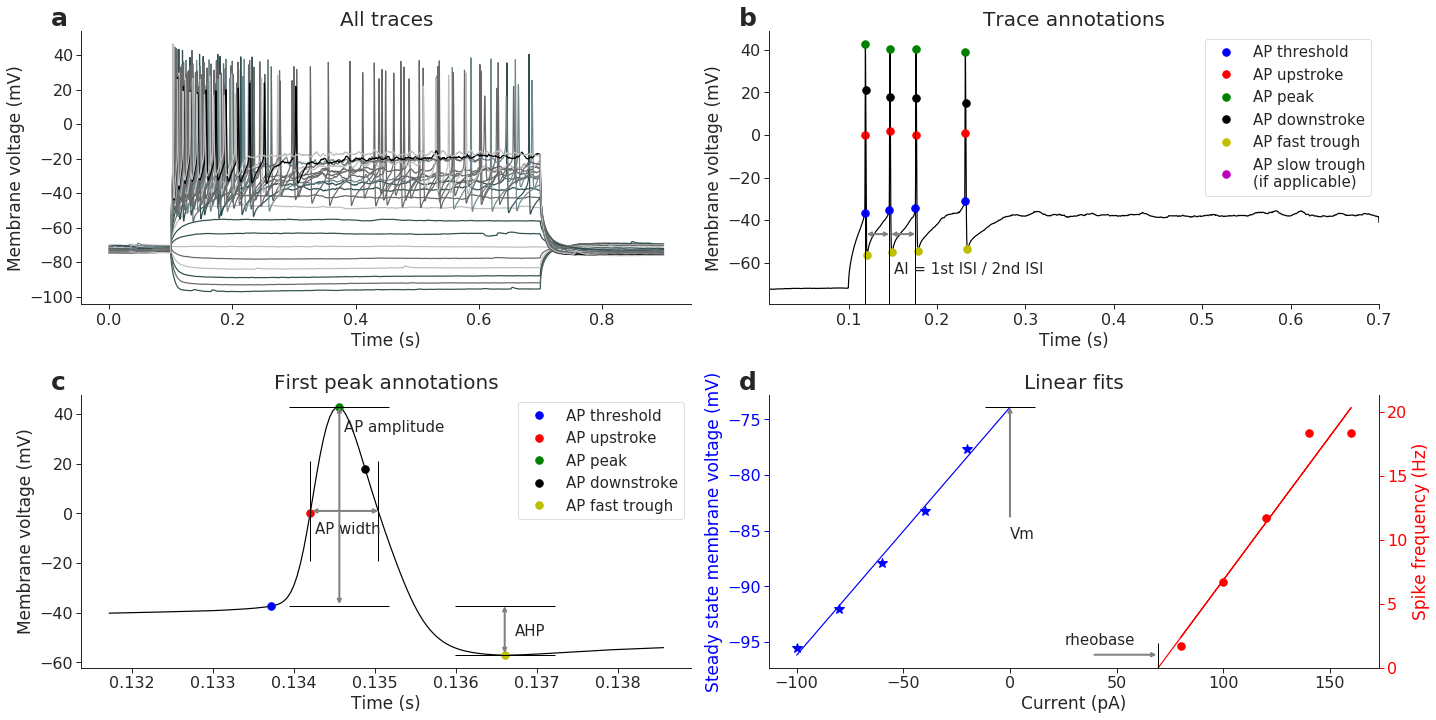

In [80]:
fig, axes = plt.subplots(2, 2, figsize = (20, 10))
axes = plot_w_style(L4_Neurolucida[50], L4_names_Neurolucida[50], current_hold_list[50], current_stim_start_list[50], \
                    axes = axes)
plt.savefig('../L4 Neurolucida/Figures/EphysIllustration.png', bbox_inches = 'tight', pad_inches = 0.5, dpi = 200)
plt.savefig('../L4 Neurolucida/Figures/EphysIllustration.pdf', bbox_inches = 'tight', pad_inches = 0.5)

In [81]:
# Again, change the directory accordingly
plot_w_style_all(L4_Neurolucida, L4_names_Neurolucida, current_hold_list, current_stim_start_list, '../L4 Neurolucida/Figures/StylePlot/')

Processing:  ../L4 Neurolucida/L4 morph/SC/04 28 2017 slice 1 cell 3.mat
Rm:  -77.82736810058356
Ri:  201.11396576464182
Rm:  -77.82736810058356
Ri:  201.11396576464182
Rm:  -77.82736810058356
Ri:  201.11396576464182
Processing:  ../L4 Neurolucida/L4 morph/SC/09 12 2017 slice 1 cell 7.mat
Rm:  -74.94083481371402
Ri:  139.6371870040894
Rm:  -74.94083481371402
Ri:  139.6371870040894
Rm:  -74.94083481371402
Ri:  139.6371870040894
Processing:  ../L4 Neurolucida/L4 morph/SC/03 17 2017 slice 3 cell 3.mat
Rm:  -75.6740398427844
Ri:  257.24355150759226
Rm:  -75.6740398427844
Ri:  257.24355150759226
Rm:  -75.6740398427844
Ri:  257.24355150759226
Processing:  ../L4 Neurolucida/L4 morph/SC/06 27 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.97400209188461
Ri:  182.28213003277776


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.97400209188461
Ri:  182.28213003277776
Rm:  -67.97400209188461
Ri:  182.28213003277776
Processing:  ../L4 Neurolucida/L4 morph/SC/04 17 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.8850598603487
Ri:  202.3848200440407


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.8850598603487
Ri:  202.3848200440407
Rm:  -68.8850598603487
Ri:  202.3848200440407
Processing:  ../L4 Neurolucida/L4 morph/SC/06 16 2017 slice 1 cell 3.mat
Rm:  -79.16628602206708
Ri:  210.96652318537244
Rm:  -74.46510272085668
Ri:  269.7313144505024
Rm:  -74.46510272085668
Ri:  269.7313144505024
Processing:  ../L4 Neurolucida/L4 morph/SC/10 09 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.89345121264458
Ri:  135.33910632133484


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.89345121264458
Ri:  135.33910632133484
Rm:  -64.89345121264458
Ri:  135.33910632133484
Processing:  ../L4 Neurolucida/L4 morph/SC/01 19 2017 slice 1 cell 2.mat
Rm:  -66.73809511139989
Ri:  200.71331678330898
Rm:  -66.73809511139989
Ri:  200.71331678330898
Rm:  -66.73809511139989
Ri:  200.71331678330898
Processing:  ../L4 Neurolucida/L4 morph/SC/01 23 2017 slice 3 cell 2.mat
Rm:  -61.656903460025795
Ri:  175.66290992498392
Rm:  -61.656903460025795
Ri:  175.66290992498392
Rm:  -61.656903460025795
Ri:  175.66290992498392
Processing:  ../L4 Neurolucida/L4 morph/SC/06 28 2017 slice 3 cell 2.mat
Rm:  -67.04044105887414
Ri:  120.00932973623277
Rm:  -67.04044105887414
Ri:  120.00932973623277
Rm:  -67.04044105887414
Ri:  120.00932973623277
Processing:  ../L4 Neurolucida/L4 morph/SC/06 28 2017 slice 3 cell 6.mat
Rm:  -68.36793078422548
Ri:  163.81928461790076
Rm:  -68.36793078422548
Ri:  163.81928461790076
Rm:  -68.36793078422548
Ri:  163.81928461790076
Processing:  ../L4 Neurolucida/L4

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.44010016530751
Ri:  178.19112785160544


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.44010016530751
Ri:  178.19112785160544
Rm:  -72.44010016530751
Ri:  178.19112785160544
Processing:  ../L4 Neurolucida/L4 morph/SC/08 31 2017 slice 1 cell 2.mat
Rm:  -72.51967525184155
Ri:  187.0639917254449
Rm:  -72.51967525184155
Ri:  187.0639917254449
Rm:  -72.51967525184155
Ri:  187.0639917254449
Processing:  ../L4 Neurolucida/L4 morph/SC/02 10 2017 slice 4 cell 3.mat
Rm:  -75.10689304530621
Ri:  151.19890648126596
Rm:  -75.10689304530621
Ri:  151.19890648126596
Rm:  -75.10689304530621
Ri:  151.19890648126596
Processing:  ../L4 Neurolucida/L4 morph/SC/03 06 2017 slice 6 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.04730843394994
Ri:  245.22515438497066


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.04730843394994
Ri:  245.22515438497066
Rm:  -66.04730843394994
Ri:  245.22515438497066
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.07671859949826
Ri:  91.64598242938519


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.07671859949826
Ri:  91.64598242938519
Rm:  -68.07671859949826
Ri:  91.64598242938519
Processing:  ../L4 Neurolucida/L4 morph/NMC/07 27 2018 slice 3 cell 2.mat
Rm:  -66.21794014513492
Ri:  163.2967685461044
Rm:  -66.21794014513492
Ri:  163.2967685461044
Rm:  -66.21794014513492
Ri:  163.2967685461044
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 17 2018 slice 9 cell 2.mat
Rm:  -56.310860281884665
Ri:  228.99851951003086
Rm:  -56.310860281884665
Ri:  228.99851951003086
Rm:  -56.310860281884665
Ri:  228.99851951003086
Processing:  ../L4 Neurolucida/L4 morph/NMC/07 27 2018 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.75912441045045
Ri:  204.93256746232524


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.75912441045045
Ri:  204.93256746232524
Rm:  -66.75912441045045
Ri:  204.93256746232524
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 17 2018 slice 10 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.26485139636695
Ri:  128.37860746681685


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.26485139636695
Ri:  128.37860746681685
Rm:  -63.26485139636695
Ri:  128.37860746681685
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.83149082034825
Ri:  104.44507242739209


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.83149082034825
Ri:  104.44507242739209
Rm:  -74.83149082034825
Ri:  104.44507242739209
Processing:  ../L4 Neurolucida/L4 morph/NMC/05 07 2018 slice 2 cell 2.mat
Rm:  -43.17927850037814
Ri:  317.31115962564945
Rm:  -43.17927850037814
Ri:  317.31115962564945
Rm:  -43.17927850037814
Ri:  317.31115962564945
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 13 2018 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.788319328576335
Ri:  129.66406606137755


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.788319328576335
Ri:  129.66406606137755
Rm:  -60.788319328576335
Ri:  129.66406606137755
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 4 cell 7.mat
Rm:  -77.39104143828153
Ri:  115.76087008416665
Rm:  -77.39104143828153
Ri:  115.76087008416665
Rm:  -77.39104143828153
Ri:  115.76087008416665
Processing:  ../L4 Neurolucida/L4 morph/NMC/07 27 2018 slice 2 cell 2.mat
Rm:  -57.26252582296729
Ri:  110.26990399509673
Rm:  -57.26252582296729
Ri:  110.26990399509673
Rm:  -57.26252582296729
Ri:  110.26990399509673
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 17 2018 slice 9 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.79135710678995
Ri:  184.27241839468473


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.79135710678995
Ri:  184.27241839468473
Rm:  -70.79135710678995
Ri:  184.27241839468473
Processing:  ../L4 Neurolucida/L4 morph/NMC/12 15 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.27405074596405
Ri:  151.17265950143346


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.27405074596405
Ri:  151.17265950143346
Rm:  -65.27405074596405
Ri:  151.17265950143346
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 3 cell 2.mat
Rm:  -64.70021021723747
Ri:  139.81832686066625
Rm:  -64.70021021723747
Ri:  139.81832686066625
Rm:  -64.70021021723747
Ri:  139.81832686066625
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.4642357480526
Ri:  126.35534563660619


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.4642357480526
Ri:  126.35534563660619
Rm:  -64.4642357480526
Ri:  126.35534563660619
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 17 2018 slice 10 cell 2.mat
Rm:  -69.44086382538082
Ri:  190.18567068874842
Rm:  -69.44086382538082
Ri:  190.18567068874842
Rm:  -69.44086382538082
Ri:  190.18567068874842
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 17 2018 slice 10 cell 3.mat
Rm:  -74.10467975169419
Ri:  184.45099700987348
Rm:  -74.10467975169419
Ri:  184.45099700987348
Rm:  -74.10467975169419
Ri:  184.45099700987348
Processing:  ../L4 Neurolucida/L4 morph/NMC/12 15 2017 slice 2 cell 2.mat
Rm:  -61.41221240743994
Ri:  264.7317544072866
Rm:  -61.41221240743994
Ri:  264.7317544072866
Rm:  -61.41221240743994
Ri:  264.7317544072866
Processing:  ../L4 Neurolucida/L4 morph/NMC/09 18 2018 slice 1 cell 2.mat
Rm:  -56.13944931149482
Ri:  154.98181416094295
Rm:  -56.13944931149482
Ri:  154.98181416094295
Rm:  -56.13944931149482
Ri:  154.98181416094295
Processing:  ../L4 Neurolucida/L4 m

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.28427356749772
Ri:  244.95537798106682


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.28427356749772
Ri:  244.95537798106682
Rm:  -65.28427356749772
Ri:  244.95537798106682
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.93952033340932
Ri:  336.45379149913765


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.93952033340932
Ri:  336.45379149913765
Rm:  -68.93952033340932
Ri:  336.45379149913765
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 19 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.86804725825787
Ri:  356.3207323849199


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.86804725825787
Ri:  356.3207323849199
Rm:  -70.86804725825787
Ri:  356.3207323849199
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 17 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.101099614053965
Ri:  160.66533739864826


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.101099614053965
Ri:  160.66533739864826
Rm:  -60.101099614053965
Ri:  160.66533739864826
Processing:  ../L4 Neurolucida/L4 morph/BPC/10 19 2016 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.67093878865242
Ri:  317.48552507162094


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.67093878865242
Ri:  317.48552507162094
Rm:  -69.67093878865242
Ri:  317.48552507162094
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 06 2017 slice 5 cell 2.mat
Rm:  -79.13670042037963
Ri:  304.4199016094208
Rm:  -79.13670042037963
Ri:  304.4199016094208
Rm:  -79.13670042037963
Ri:  304.4199016094208
Processing:  ../L4 Neurolucida/L4 morph/BPC/06 22 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.55689591795206
Ri:  290.04578515887266


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.55689591795206
Ri:  290.04578515887266
Rm:  -73.55689591795206
Ri:  290.04578515887266
Processing:  ../L4 Neurolucida/L4 morph/BPC/01 30 2017 slice 4 cell 7.mat
Rm:  -56.28868888795377
Ri:  382.17636263370514
Rm:  -56.28868888795377
Ri:  382.17636263370514
Rm:  -56.28868888795377
Ri:  382.17636263370514
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 3 cell 7.mat
Rm:  -72.25941976070405
Ri:  286.1609266549349
Rm:  -72.25941976070405
Ri:  286.1609266549349
Rm:  -72.25941976070405
Ri:  286.1609266549349
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.89263139426707
Ri:  407.4922988712789


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.89263139426707
Ri:  407.4922988712789
Rm:  -71.89263139426707
Ri:  407.4922988712789
Processing:  ../L4 Neurolucida/L4 morph/BPC/06 07 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.24377530559899
Ri:  305.69832845032215


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.24377530559899
Ri:  305.69832845032215
Rm:  -79.24377530559899
Ri:  305.69832845032215
Processing:  ../L4 Neurolucida/L4 morph/BPC/04 05 2017 slice 1 cell 2.mat
Rm:  -81.72399976670744
Ri:  319.19177834689606
Rm:  -81.72399976670744
Ri:  319.19177834689606
Rm:  -81.72399976670744
Ri:  319.19177834689606
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 11 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.54880906373262
Ri:  273.14803554117685


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.54880906373262
Ri:  273.14803554117685
Rm:  -75.54880906373262
Ri:  273.14803554117685
Processing:  ../L4 Neurolucida/L4 morph/BPC/04 05 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.12615000680089
Ri:  291.73563207685953


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.12615000680089
Ri:  291.73563207685953
Rm:  -63.12615000680089
Ri:  291.73563207685953
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 03 2017 slice 2 cell 7.mat
Rm:  -69.26795950710772
Ri:  258.37220609188086
Rm:  -69.26795950710772
Ri:  258.37220609188086
Rm:  -69.26795950710772
Ri:  258.37220609188086
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 5 cell 2.mat
Rm:  -68.73928315222264
Ri:  437.51224808394915
Rm:  -68.73928315222264
Ri:  437.51224808394915
Rm:  -68.73928315222264
Ri:  437.51224808394915
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 15 2017 slice 2 cell 3.mat
Rm:  -73.9059895080328
Ri:  222.62214198708534
Rm:  -73.9059895080328
Ri:  222.62214198708534
Rm:  -73.9059895080328
Ri:  222.62214198708534
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 17 2017 slice 4 cell 3.mat
Rm:  -66.46181458890439
Ri:  393.4156975597144
Rm:  -66.46181458890439
Ri:  393.4156975597144
Rm:  -66.46181458890439
Ri:  393.4156975597144
Processing:  ../L4 Neurolucida/L4 morp

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -85.50852206349371
Ri:  283.93452075123787


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -85.50852206349371
Ri:  283.93452075123787
Rm:  -85.50852206349371
Ri:  283.93452075123787
Processing:  ../L4 Neurolucida/L4 morph/BPC/08 06 2017 slice 1 cell 2.mat
Rm:  -75.05154946923257
Ri:  262.12274417281145
Rm:  -75.05154946923257
Ri:  262.12274417281145
Rm:  -75.05154946923257
Ri:  262.12274417281145
Processing:  ../L4 Neurolucida/L4 morph/BPC/08 06 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.62914426743983
Ri:  217.3583673238754


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.62914426743983
Ri:  217.3583673238754
Rm:  -66.62914426743983
Ri:  217.3583673238754
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 19 2017 slice 2 cell 2.mat
Rm:  -78.27745651602746
Ri:  226.01543690264236
Rm:  -78.27745651602746
Ri:  226.01543690264236
Rm:  -78.27745651602746
Ri:  226.01543690264236
Processing:  ../L4 Neurolucida/L4 morph/BPC/02 24 2017 slice 3 cell 2.mat
Rm:  -63.759399041533484
Ri:  338.1702662408351
Rm:  -63.759399041533484
Ri:  338.1702662408351
Rm:  -63.759399041533484
Ri:  338.1702662408351
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 29 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.02015067845585
Ri:  315.46597377955914


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.02015067845585
Ri:  315.46597377955914
Rm:  -77.02015067845585
Ri:  315.46597377955914
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 18 2017 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -80.88766046881676
Ri:  413.93450400233274


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -80.88766046881676
Ri:  413.93450400233274
Rm:  -80.88766046881676
Ri:  413.93450400233274
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.83803762257098
Ri:  286.97878506779676


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.83803762257098
Ri:  286.97878506779676
Rm:  -70.83803762257098
Ri:  286.97878506779676
Processing:  ../L4 Neurolucida/L4 morph/BPC/04 28 2017 slice 3 cell 3.mat
Rm:  -80.61727136552335
Ri:  382.9484563767909
Rm:  -80.61727136552335
Ri:  382.9484563767909
Rm:  -80.61727136552335
Ri:  382.9484563767909
Processing:  ../L4 Neurolucida/L4 morph/BPC/02 10 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.0143410474062
Ri:  442.78033041954046


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.0143410474062
Ri:  442.78033041954046
Rm:  -75.0143410474062
Ri:  442.78033041954046
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 05 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.79834214389325
Ri:  393.77344542741764


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.79834214389325
Ri:  393.77344542741764
Rm:  -77.79834214389325
Ri:  393.77344542741764
Processing:  ../L4 Neurolucida/L4 morph/BPC/05 08 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.38117140740157
Ri:  291.836709573865


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.38117140740157
Ri:  291.836709573865
Rm:  -74.38117140740157
Ri:  291.836709573865
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 17 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.50533892691135
Ri:  259.5194514691831


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.50533892691135
Ri:  259.5194514691831
Rm:  -77.50533892691135
Ri:  259.5194514691831
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 29 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.04537636026738
Ri:  334.2955034524203


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.04537636026738
Ri:  334.2955034524203
Rm:  -76.04537636026738
Ri:  334.2955034524203
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 03 2017 slice 3 cell 2.mat
Rm:  -73.58335884034635
Ri:  360.99893204867834
Rm:  -73.58335884034635
Ri:  360.99893204867834
Rm:  -73.58335884034635
Ri:  360.99893204867834
Processing:  ../L4 Neurolucida/L4 morph/BPC/03 11 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.88374993234874
Ri:  346.8724140077828


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.88374993234874
Ri:  346.8724140077828
Rm:  -69.88374993234874
Ri:  346.8724140077828
Processing:  ../L4 Neurolucida/L4 morph/BPC/04 28 2017 slice 5 cell 2.mat
Rm:  -72.01739747166633
Ri:  347.26351904869085
Rm:  -72.01739747166633
Ri:  347.26351904869085
Rm:  -72.01739747166633
Ri:  347.26351904869085
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 1 cell 7.mat
Rm:  -77.10399270534515
Ri:  258.4503163695335
Rm:  -77.10399270534515
Ri:  258.4503163695335
Rm:  -77.10399270534515
Ri:  258.4503163695335
Processing:  ../L4 Neurolucida/L4 morph/BPC/07 17 2017 slice 1 cell 2.mat
Rm:  -77.25474007308483
Ri:  254.47696721553814
Rm:  -77.25474007308483
Ri:  254.47696721553814
Rm:  -77.25474007308483
Ri:  254.47696721553814
Processing:  ../L4 Neurolucida/L4 morph/DBC/11 29 2016 slice 4 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.923451808094974
Ri:  203.90059643983835


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -63.923451808094974
Ri:  203.90059643983835
Rm:  -63.923451808094974
Ri:  203.90059643983835
Processing:  ../L4 Neurolucida/L4 morph/DBC/12 05 2016 slice 1 cell 2.mat
Rm:  -73.25217131376266
Ri:  192.10413581132886
Rm:  -73.25217131376266
Ri:  192.10413581132886
Rm:  -73.25217131376266
Ri:  192.10413581132886
Processing:  ../L4 Neurolucida/L4 morph/DBC/02 12 2017 slice 5 cell 7.mat
Rm:  -63.84769646018743
Ri:  123.78808595240123
Rm:  -63.84769646018743
Ri:  123.78808595240123
Rm:  -63.84769646018743
Ri:  123.78808595240123
Processing:  ../L4 Neurolucida/L4 morph/DBC/02 12 2017 slice 2 cell 7.mat
Rm:  -72.25713749825954
Ri:  138.1653878390789
Rm:  -72.25713749825954
Ri:  138.1653878390789
Rm:  -72.25713749825954
Ri:  138.1653878390789
Processing:  ../L4 Neurolucida/L4 morph/DBC/03 28 2017 slice 5 cell 2.mat
Rm:  -74.62534954577684
Ri:  139.68624962866312
Rm:  -74.62534954577684
Ri:  139.68624962866312
Rm:  -74.62534954577684
Ri:  139.68624962866312
Processing:  ../L4 Neurolucida/L4

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.77216246545314
Ri:  121.06566900014883


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.77216246545314
Ri:  121.06566900014883
Rm:  -70.77216246545314
Ri:  121.06566900014883
Processing:  ../L4 Neurolucida/L4 morph/DBC/08 22 2017 slice 5 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.06474300831557
Ri:  128.87615691125396


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.06474300831557
Ri:  128.87615691125396
Rm:  -76.06474300831557
Ri:  128.87615691125396
Processing:  ../L4 Neurolucida/L4 morph/DBC/07 19 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.45402196586132
Ri:  119.96104407310486


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.45402196586132
Ri:  119.96104407310486
Rm:  -73.45402196586132
Ri:  119.96104407310486
Processing:  ../L4 Neurolucida/L4 morph/DBC/05 16 2017 slice 1 cell 6.mat
Rm:  -69.06664327859878
Ri:  110.40655970573421
Rm:  -69.06664327859878
Ri:  110.40655970573421
Rm:  -69.06664327859878
Ri:  110.40655970573421
Processing:  ../L4 Neurolucida/L4 morph/DBC/11 29 2016 slice 4 cell 7.mat
Rm:  -60.26671855777503
Ri:  158.09846599400043
Rm:  -60.26671855777503
Ri:  158.09846599400043
Rm:  -60.26671855777503
Ri:  158.09846599400043
Processing:  ../L4 Neurolucida/L4 morph/DBC/05 10 2017 slice 3 cell 2.mat
Rm:  -79.80243541449309
Ri:  130.10515417158604
Rm:  -79.80243541449309
Ri:  130.10515417158604
Rm:  -79.80243541449309
Ri:  130.10515417158604
Processing:  ../L4 Neurolucida/L4 morph/DBC/04 03 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.35984535589814
Ri:  105.50503031909466


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.35984535589814
Ri:  105.50503031909466
Rm:  -73.35984535589814
Ri:  105.50503031909466
Processing:  ../L4 Neurolucida/L4 morph/DBC/05 10 2017 slice 3 cell 6.mat
Rm:  -70.4628205960989
Ri:  138.39764940738678
Rm:  -70.4628205960989
Ri:  138.39764940738678
Rm:  -70.4628205960989
Ri:  138.39764940738678
Processing:  ../L4 Neurolucida/L4 morph/DBC/01 12 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.56777225762605
Ri:  226.42902524769295


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.56777225762605
Ri:  226.42902524769295
Rm:  -70.56777225762605
Ri:  226.42902524769295
Processing:  ../L4 Neurolucida/L4 morph/DBC/09 12 2017 slice 3 cell 3.mat
Rm:  -72.5702996736765
Ri:  150.18625219166282
Rm:  -72.5702996736765
Ri:  150.18625219166282
Rm:  -72.5702996736765
Ri:  150.18625219166282
Processing:  ../L4 Neurolucida/L4 morph/DBC/11 29 2016 slice 3 cell 7.mat
Rm:  -68.72780725747346
Ri:  132.1641672700645
Rm:  -68.72780725747346
Ri:  132.1641672700645
Rm:  -68.72780725747346
Ri:  132.1641672700645
Processing:  ../L4 Neurolucida/L4 morph/DBC/07 17 2017 slice 4 cell 3.mat
Rm:  -75.5097038412094
Ri:  136.3081696629525
Rm:  -75.5097038412094
Ri:  136.3081696629525
Rm:  -75.5097038412094
Ri:  136.3081696629525
Processing:  ../L4 Neurolucida/L4 morph/DBC/03 17 2017 slice 1 cell 2.mat
Rm:  -64.620883923769
Ri:  165.22173175215732
Rm:  -64.620883923769
Ri:  165.22173175215732
Rm:  -64.620883923769
Ri:  165.22173175215732
Processing:  ../L4 Neurolucida/L4 morph/DBC/02 13 

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.25449693411589
Ri:  158.61107239127162


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.25449693411589
Ri:  158.61107239127162
Rm:  -72.25449693411589
Ri:  158.61107239127162
Processing:  ../L4 Neurolucida/L4 morph/DBC/08 24 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.43973845601082
Ri:  117.6521617472173


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.43973845601082
Ri:  117.6521617472173
Rm:  -69.43973845601082
Ri:  117.6521617472173
Processing:  ../L4 Neurolucida/L4 morph/DBC/07 04 2017 slice 2 cell 6.mat
Rm:  -73.1996134096384
Ri:  150.0266809314489
Rm:  -73.1996134096384
Ri:  150.0266809314489
Rm:  -73.1996134096384
Ri:  150.0266809314489
Processing:  ../L4 Neurolucida/L4 morph/HEC/07 03 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.8759620398283
Ri:  126.00393247604374


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.8759620398283
Ri:  126.00393247604374
Rm:  -70.8759620398283
Ri:  126.00393247604374
Processing:  ../L4 Neurolucida/L4 morph/HEC/07 18 2017 slice 1 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.19669836640358
Ri:  217.67934095859536


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.19669836640358
Ri:  217.67934095859536
Rm:  -75.19669836640358
Ri:  217.67934095859536
Processing:  ../L4 Neurolucida/L4 morph/HEC/01 31 2017 slice 3 cell 6.mat
Rm:  -67.08568535521627
Ri:  186.4009730666875
Rm:  -67.08568535521627
Ri:  186.4009730666875
Rm:  -67.08568535521627
Ri:  186.4009730666875
Processing:  ../L4 Neurolucida/L4 morph/HEC/07 03 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.73253655046224
Ri:  171.37313540279874


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.73253655046224
Ri:  171.37313540279874
Rm:  -60.73253655046224
Ri:  171.37313540279874
Processing:  ../L4 Neurolucida/L4 morph/HEC/01 30 2017 slice 2 cell 2.mat
Rm:  -67.66989536464214
Ri:  137.74924021959308
Rm:  -67.66989536464214
Ri:  137.74924021959308
Rm:  -67.66989536464214
Ri:  137.74924021959308
Processing:  ../L4 Neurolucida/L4 morph/HEC/09 18 2017 slice 1 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -78.2946981281042
Ri:  195.29339265823359


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -78.2946981281042
Ri:  195.29339265823359
Rm:  -78.2946981281042
Ri:  195.29339265823359
Processing:  ../L4 Neurolucida/L4 morph/HEC/01 14 2017 slice 2 cell 5.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.23922800302505
Ri:  296.9104116857052


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.23922800302505
Ri:  296.9104116857052
Rm:  -66.23922800302505
Ri:  296.9104116857052
Processing:  ../L4 Neurolucida/L4 morph/HEC/10 23 2017 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.02408696338534
Ri:  168.89942242205143


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.02408696338534
Ri:  168.89942242205143
Rm:  -75.02408696338534
Ri:  168.89942242205143
Processing:  ../L4 Neurolucida/L4 morph/HEC/07 03 2017 slice 1 cell 2.mat
Rm:  -66.8986079749465
Ri:  117.22212110459816
Rm:  -66.8986079749465
Ri:  117.22212110459816
Rm:  -66.8986079749465
Ri:  117.22212110459816
Processing:  ../L4 Neurolucida/L4 morph/HEC/05 08 2017 slice 4 cell 3.mat
Rm:  -66.42029956549405
Ri:  135.786959514022
Rm:  -66.42029956549405
Ri:  135.786959514022
Rm:  -66.42029956549405
Ri:  135.786959514022
Processing:  ../L4 Neurolucida/L4 morph/HEC/03 06 2017 slice 5 cell 7.mat
Rm:  -60.24400263011456
Ri:  237.98802280426028
Rm:  -60.24400263011456
Ri:  237.98802280426028
Rm:  -60.24400263011456
Ri:  237.98802280426028
Processing:  ../L4 Neurolucida/L4 morph/PYR/01 14 2017 slice 2 cell 2.mat
Rm:  -80.16763269960879
Ri:  232.07118543982511
Rm:  -80.16763269960879
Ri:  232.07118543982511
Rm:  -80.16763269960879
Ri:  232.07118543982511
Processing:  ../L4 Neurolucida/L4 morph/P

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.35005479156969
Ri:  151.68605437874794


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.35005479156969
Ri:  151.68605437874794
Rm:  -73.35005479156969
Ri:  151.68605437874794
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 19 2016 slice 3 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.99185250043867
Ri:  228.08032877743253


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.99185250043867
Ri:  228.08032877743253
Rm:  -72.99185250043867
Ri:  228.08032877743253
Processing:  ../L4 Neurolucida/L4 morph/PYR/01 12 2017 slice 1 cell 2.mat
Rm:  -71.1847576534748
Ri:  307.3492168188096
Rm:  -71.1847576534748
Ri:  307.3492168188096
Rm:  -71.1847576534748
Ri:  307.3492168188096
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 5 cell 2.mat
Rm:  -45.062679633498206
Ri:  302.5860393047331
Rm:  -45.062679633498206
Ri:  302.5860393047331
Rm:  -45.062679633498206
Ri:  302.5860393047331
Processing:  ../L4 Neurolucida/L4 morph/PYR/11 23 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.70568154245613
Ri:  196.33557085692888


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.70568154245613
Ri:  196.33557085692888
Rm:  -76.70568154245613
Ri:  196.33557085692888
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 1 cell 6.mat
Rm:  -83.76968140542508
Ri:  240.29944142699253
Rm:  -83.76968140542508
Ri:  240.29944142699253
Rm:  -83.76968140542508
Ri:  240.29944142699253
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 4 cell 2.mat
Rm:  -47.77506110072137
Ri:  315.29334262013424
Rm:  -47.77506110072137
Ri:  315.29334262013424
Rm:  -47.77506110072137
Ri:  315.29334262013424
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 26 2016 slice 3 cell 7.mat
Rm:  -65.05387715607883
Ri:  174.28348512947557
Rm:  -65.05387715607883
Ri:  174.28348512947557
Rm:  -65.05387715607883
Ri:  174.28348512947557
Processing:  ../L4 Neurolucida/L4 morph/PYR/03 06 2017 slice 2 cell 7.mat
Rm:  -62.77251637041569
Ri:  279.18458840250975
Rm:  -62.77251637041569
Ri:  279.18458840250975
Rm:  -62.77251637041569
Ri:  279.18458840250975
Processing:  ../L4 Neurolucida/L

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.41377196252346
Ri:  146.27448949217793


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.41377196252346
Ri:  146.27448949217793
Rm:  -79.41377196252346
Ri:  146.27448949217793
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 27 2016 slice 4 cell 3.mat
Rm:  -75.58956754803658
Ri:  203.91062337160105
Rm:  -75.58956754803658
Ri:  203.91062337160105
Rm:  -75.58956754803658
Ri:  203.91062337160105
Processing:  ../L4 Neurolucida/L4 morph/PYR/04 03 2017 slice 4 cell 7.mat
Rm:  -45.91056255862117
Ri:  339.5352401584387
Rm:  -45.91056255862117
Ri:  339.5352401584387
Rm:  -45.91056255862117
Ri:  339.5352401584387
Processing:  ../L4 Neurolucida/L4 morph/PYR/02 12 2017 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.96540016055107
Ri:  259.622387945652


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.96540016055107
Ri:  259.622387945652
Rm:  -73.96540016055107
Ri:  259.622387945652
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 1 cell 7.mat
Rm:  -79.96882117271423
Ri:  238.90695640444764
Rm:  -79.96882117271423
Ri:  238.90695640444764
Rm:  -79.96882117271423
Ri:  238.90695640444764
Processing:  ../L4 Neurolucida/L4 morph/PYR/05 10 2017 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.33589838236569
Ri:  287.78583607077604


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.33589838236569
Ri:  287.78583607077604
Rm:  -62.33589838236569
Ri:  287.78583607077604
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 19 2016 slice 4 cell 6.mat
Rm:  -71.2942724454403
Ri:  285.8215798735619
Rm:  -71.2942724454403
Ri:  285.8215798735619
Rm:  -71.2942724454403
Ri:  285.8215798735619
Processing:  ../L4 Neurolucida/L4 morph/PYR/11 23 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.92607806652784
Ri:  209.5158989876509


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.92607806652784
Ri:  209.5158989876509
Rm:  -74.92607806652784
Ri:  209.5158989876509
Processing:  ../L4 Neurolucida/L4 morph/PYR/03 06 2017 slice 3 cell 7.mat
Rm:  -66.57983818620444
Ri:  361.61994080245495
Rm:  -66.57983818620444
Ri:  361.61994080245495
Rm:  -66.57983818620444
Ri:  361.61994080245495
Processing:  ../L4 Neurolucida/L4 morph/PYR/12 05 2016 slice 4 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.2086921441555
Ri:  308.66701242327684


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.2086921441555
Ri:  308.66701242327684
Rm:  -65.2086921441555
Ri:  308.66701242327684
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 19 2016 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.05463052034378
Ri:  171.0321015119552


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.05463052034378
Ri:  171.0321015119552
Rm:  -66.05463052034378
Ri:  171.0321015119552
Processing:  ../L4 Neurolucida/L4 morph/PYR/01 30 2017 slice 2 cell 7.mat
Rm:  -70.01297527730465
Ri:  275.48490998148924
Rm:  -70.01297527730465
Ri:  275.48490998148924
Rm:  -70.01297527730465
Ri:  275.48490998148924
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 27 2016 slice 1 cell 7.mat
Rm:  -57.38472470730543
Ri:  192.57758839428428
Rm:  -57.38472470730543
Ri:  192.57758839428428
Rm:  -57.38472470730543
Ri:  192.57758839428428
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 20 2016 slice 4 cell 5.mat
Rm:  -76.77708445399999
Ri:  276.78807945549505
Rm:  -76.77708445399999
Ri:  276.78807945549505
Rm:  -76.77708445399999
Ri:  276.78807945549505
Processing:  ../L4 Neurolucida/L4 morph/PYR/10 19 2016 slice 2 cell 7.mat
Rm:  -62.158447022736084
Ri:  256.03173534572124
Rm:  -62.158447022736084
Ri:  256.03173534572124
Rm:  -62.158447022736084
Ri:  256.03173534572124
Processing:  ../L4 Neurolucida/

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.75049727886915
Ri:  345.8871136456728


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.75049727886915
Ri:  345.8871136456728
Rm:  -76.75049727886915
Ri:  345.8871136456728
Processing:  ../L4 Neurolucida/L4 morph/PYR/05 11 2017 slice 2 cell 6.mat
Rm:  -70.46256488442421
Ri:  242.37500438094145
Rm:  -70.46256488442421
Ri:  242.37500438094145
Rm:  -70.46256488442421
Ri:  242.37500438094145
Processing:  ../L4 Neurolucida/L4 morph/PYR/03 15 2017 slice 1 cell 7.mat
Rm:  -79.59851111233233
Ri:  154.6858162283897
Rm:  -79.59851111233233
Ri:  154.6858162283897
Rm:  -79.59851111233233
Ri:  154.6858162283897
Processing:  ../L4 Neurolucida/L4 morph/PYR/01 19 2017 slice 2 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.62913868024945
Ri:  359.6328573971987


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.62913868024945
Ri:  359.6328573971987
Rm:  -70.62913868024945
Ri:  359.6328573971987
Processing:  ../L4 Neurolucida/L4 morph/PYR/05 11 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.05498592421412
Ri:  242.15643654763704


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.05498592421412
Ri:  242.15643654763704
Rm:  -65.05498592421412
Ri:  242.15643654763704
Processing:  ../L4 Neurolucida/L4 morph/PYR/05 11 2017 slice 1 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.92649952113628
Ri:  296.68597605824476


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.92649952113628
Ri:  296.68597605824476
Rm:  -69.92649952113628
Ri:  296.68597605824476
Processing:  ../L4 Neurolucida/L4 morph/PYR/11 08 2016 slice 1 cell 2.mat
Rm:  -81.22278807044029
Ri:  135.11907774209982
Rm:  -81.22278807044029
Ri:  135.11907774209982
Rm:  -81.22278807044029
Ri:  135.11907774209982
Processing:  ../L4 Neurolucida/L4 morph/MC/09 04 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.63570749759673
Ri:  236.84402379393592


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.63570749759673
Ri:  236.84402379393592
Rm:  -68.63570749759673
Ri:  236.84402379393592
Processing:  ../L4 Neurolucida/L4 morph/MC/05 03 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.25744551181793
Ri:  168.41831091046336


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.25744551181793
Ri:  168.41831091046336
Rm:  -65.25744551181793
Ri:  168.41831091046336
Processing:  ../L4 Neurolucida/L4 morph/MC/11 08 2016 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.401245922744266
Ri:  237.89698578417318


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.401245922744266
Ri:  237.89698578417318
Rm:  -60.401245922744266
Ri:  237.89698578417318
Processing:  ../L4 Neurolucida/L4 morph/MC/07 04 2017 slice 4 cell 7.mat
Rm:  -65.21278348684311
Ri:  111.79631309211254
Rm:  -65.21278348684311
Ri:  111.79631309211254
Rm:  -65.21278348684311
Ri:  111.79631309211254
Processing:  ../L4 Neurolucida/L4 morph/MC/09 04 2017 slice 4 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.21494390010832
Ri:  219.75274670124048


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.21494390010832
Ri:  219.75274670124048
Rm:  -69.21494390010832
Ri:  219.75274670124048
Processing:  ../L4 Neurolucida/L4 morph/MC/01 30 2017 slice 4 cell 3.mat
Rm:  -54.07868984103202
Ri:  114.40176072716716
Rm:  -54.07868984103202
Ri:  114.40176072716716
Rm:  -45.58788608431818
Ri:  152.99632325768468
Processing:  ../L4 Neurolucida/L4 morph/MC/07 28 2017 slice 2 cell 3.mat
Rm:  -53.958891753107316
Ri:  211.68496362864968
Rm:  -53.958891753107316
Ri:  211.68496362864968
Rm:  -53.958891753107316
Ri:  211.68496362864968
Processing:  ../L4 Neurolucida/L4 morph/MC/07 18 2017 slice 2 cell 7.mat
Rm:  -75.0033060157299
Ri:  262.782413840294
Rm:  -75.0033060157299
Ri:  262.782413840294
Rm:  -75.0033060157299
Ri:  262.782413840294
Processing:  ../L4 Neurolucida/L4 morph/MC/08 01 2017 slice 2 cell 2.mat
Rm:  -60.44541807442904
Ri:  247.19136324524874
Rm:  -60.44541807442904
Ri:  247.19136324524874
Rm:  -60.44541807442904
Ri:  247.19136324524874
Processing:  ../L4 Neurolucida/L4 morph/MC

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.494158580899224
Ri:  163.4370724409818


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -59.494158580899224
Ri:  163.4370724409818
Rm:  -59.494158580899224
Ri:  163.4370724409818
Processing:  ../L4 Neurolucida/L4 morph/MC/11 30 2016 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.17289459258318
Ri:  298.9081900566817


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.17289459258318
Ri:  298.9081900566817
Rm:  -46.17289459258318
Ri:  298.9081900566817
Processing:  ../L4 Neurolucida/L4 morph/MC/09 11 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.84867594897747
Ri:  235.9756315946579


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -58.84867594897747
Ri:  235.9756315946579
Rm:  -58.84867594897747
Ri:  235.9756315946579
Processing:  ../L4 Neurolucida/L4 morph/MC/05 08 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.35342295154928
Ri:  238.1832095533609


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.35342295154928
Ri:  238.1832095533609
Rm:  -77.35342295154928
Ri:  238.1832095533609
Processing:  ../L4 Neurolucida/L4 morph/MC/10 03 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.87656277060508
Ri:  294.49685826897604


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.87656277060508
Ri:  294.49685826897604
Rm:  -73.87656277060508
Ri:  294.49685826897604
Processing:  ../L4 Neurolucida/L4 morph/MC/10 10 2017 slice 4 cell 2.mat
Rm:  -68.99153336316347
Ri:  234.69170404970643
Rm:  -68.99153336316347
Ri:  234.69170404970643
Rm:  -68.99153336316347
Ri:  234.69170404970643
Processing:  ../L4 Neurolucida/L4 morph/MC/08 22 2017 slice 2 cell 7.mat
Rm:  -76.14359728634358
Ri:  229.66419357061383
Rm:  -76.14359728634358
Ri:  229.66419357061383
Rm:  -76.14359728634358
Ri:  229.66419357061383
Processing:  ../L4 Neurolucida/L4 morph/MC/12 05 2016 slice 5 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.878009954094885
Ri:  260.330624550581


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -46.878009954094885
Ri:  260.330624550581
Rm:  -46.878009954094885
Ri:  260.330624550581
Processing:  ../L4 Neurolucida/L4 morph/MC/08 22 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.40748499572277
Ri:  276.79321205615986


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -52.40748499572277
Ri:  276.79321205615986
Rm:  -52.40748499572277
Ri:  276.79321205615986
Processing:  ../L4 Neurolucida/L4 morph/MC/04 05 2017 slice 5 cell 2.mat
Rm:  -58.44759209752082
Ri:  256.6518550217152
Rm:  -58.44759209752082
Ri:  256.6518550217152
Rm:  -58.44759209752082
Ri:  256.6518550217152
Processing:  ../L4 Neurolucida/L4 morph/MC/08 21 2017 slice 1 cell 7.mat
Rm:  -68.42430733174086
Ri:  307.41995766758924
Rm:  -68.42430733174086
Ri:  307.41995766758924
Rm:  -68.42430733174086
Ri:  307.41995766758924
Processing:  ../L4 Neurolucida/L4 morph/MC/08 21 2017 slice 3 cell 2.mat
Rm:  -59.256378877758976
Ri:  222.09048837423333
Rm:  -59.256378877758976
Ri:  222.09048837423333
Rm:  -59.256378877758976
Ri:  222.09048837423333
Processing:  ../L4 Neurolucida/L4 morph/MC/08 01 2017 slice 2 cell 7.mat
Rm:  -55.93651669666171
Ri:  202.88480646908297
Rm:  -55.93651669666171
Ri:  202.88480646908297
Rm:  -55.93651669666171
Ri:  202.88480646908297
Processing:  ../L4 Neurolucida/L4 mo

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.63584570974112
Ri:  247.3051657527686


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.63584570974112
Ri:  247.3051657527686
Rm:  -69.63584570974112
Ri:  247.3051657527686
Processing:  ../L4 Neurolucida/L4 morph/MC/07 04 2017 slice 4 cell 2.mat
Rm:  -70.46391982674598
Ri:  180.05467589199537
Rm:  -70.46391982674598
Ri:  180.05467589199537
Rm:  -70.46391982674598
Ri:  180.05467589199537
Processing:  ../L4 Neurolucida/L4 morph/MC/06 15 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.53161632031201
Ri:  124.9037515372038


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -69.53161632031201
Ri:  124.9037515372038
Rm:  -69.53161632031201
Ri:  124.9037515372038
Processing:  ../L4 Neurolucida/L4 morph/MC/07 05 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.88993292868138
Ri:  260.7371889948844


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.88993292868138
Ri:  260.7371889948844
Rm:  -65.88993292868138
Ri:  260.7371889948844
Processing:  ../L4 Neurolucida/L4 morph/MC/10 10 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.90096818447114
Ri:  250.36038643121722


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -60.90096818447114
Ri:  250.36038643121722
Rm:  -60.90096818447114
Ri:  250.36038643121722
Processing:  ../L4 Neurolucida/L4 morph/MC/08 21 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.37871603220702
Ri:  329.3067199736833


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.37871603220702
Ri:  329.3067199736833
Rm:  -67.37871603220702
Ri:  329.3067199736833
Processing:  ../L4 Neurolucida/L4 morph/MC/06 15 2017 slice 2 cell 2.mat
Rm:  -65.6358227312565
Ri:  207.9963041543961
Rm:  -65.6358227312565
Ri:  207.9963041543961
Rm:  -65.6358227312565
Ri:  207.9963041543961
Processing:  ../L4 Neurolucida/L4 morph/MC/05 08 2017 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.95828299373387
Ri:  201.4179862886668


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.95828299373387
Ri:  201.4179862886668
Rm:  -64.95828299373387
Ri:  201.4179862886668
Processing:  ../L4 Neurolucida/L4 morph/MC/05 03 2017 slice 1 cell 5.mat
Rm:  -60.39477384358646
Ri:  613.0403204411267
Rm:  -60.39477384358646
Ri:  613.0403204411267
Rm:  -60.39477384358646
Ri:  613.0403204411267
Processing:  ../L4 Neurolucida/L4 morph/MC/07 04 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.17031153768299
Ri:  183.544461414218


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.17031153768299
Ri:  183.544461414218
Rm:  -64.17031153768299
Ri:  183.544461414218
Processing:  ../L4 Neurolucida/L4 morph/MC/07 04 2017 slice 2 cell 2.mat
Rm:  -68.98678398251535
Ri:  211.342884004116
Rm:  -68.98678398251535
Ri:  211.342884004116
Rm:  -68.98678398251535
Ri:  211.342884004116
Processing:  ../L4 Neurolucida/L4 morph/MC/04 17 2017 slice 4 cell 7.mat
Rm:  -77.81024493813513
Ri:  202.27695882320404
Rm:  -77.81024493813513
Ri:  202.27695882320404
Rm:  -77.81024493813513
Ri:  202.27695882320404
Processing:  ../L4 Neurolucida/L4 morph/MC/07 12 2017 slice 1 cell 2.mat
Rm:  -69.29589329481125
Ri:  280.5564840734005
Rm:  -69.29589329481125
Ri:  280.5564840734005
Rm:  -69.29589329481125
Ri:  280.5564840734005
Processing:  ../L4 Neurolucida/L4 morph/MC/07 04 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.04506243646146
Ri:  172.75514319539064


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -66.04506243646146
Ri:  172.75514319539064
Rm:  -66.04506243646146
Ri:  172.75514319539064
Processing:  ../L4 Neurolucida/L4 morph/MC/11 01 2016 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -37.23789593398571
Ri:  189.27152648568148


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -37.23789593398571
Ri:  189.27152648568148
Rm:  -37.23789593398571
Ri:  189.27152648568148
Processing:  ../L4 Neurolucida/L4 morph/MC/03 28 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.7617708438635
Ri:  175.37822979688633


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.7617708438635
Ri:  175.37822979688633
Rm:  -67.7617708438635
Ri:  175.37822979688633
Processing:  ../L4 Neurolucida/L4 morph/MC/02 09 2017 slice 3 cell 5.mat
Rm:  -57.222943785488596
Ri:  276.4229195863009
Rm:  -57.222943785488596
Ri:  276.4229195863009
Rm:  -57.222943785488596
Ri:  276.4229195863009
Processing:  ../L4 Neurolucida/L4 morph/MC/10 27 2016 slice 2 cell 2.mat
Rm:  -50.0160731559992
Ri:  225.48140329122535
Rm:  -50.0160731559992
Ri:  225.48140329122535
Rm:  -50.0160731559992
Ri:  225.48140329122535
Processing:  ../L4 Neurolucida/L4 morph/MC/03 23 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.6824128177762
Ri:  305.94148464500904


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -62.6824128177762
Ri:  305.94148464500904
Rm:  -62.6824128177762
Ri:  305.94148464500904
Processing:  ../L4 Neurolucida/L4 morph/MC/06 23 2017 slice 2 cell 2.mat
Rm:  -67.82110871493818
Ri:  190.87062245607373
Rm:  -67.82110871493818
Ri:  190.87062245607373
Rm:  -67.82110871493818
Ri:  190.87062245607373
Processing:  ../L4 Neurolucida/L4 morph/MC/01 30 2017 slice 4 cell 2.mat
Rm:  -64.82971778064967
Ri:  293.9851730018854
Rm:  -64.82971778064967
Ri:  293.9851730018854
Rm:  -64.82971778064967
Ri:  293.9851730018854
Processing:  ../L4 Neurolucida/L4 morph/MC/08 22 2017 slice 3 cell 2.mat
Rm:  -63.4477064180374
Ri:  196.94052058458334
Rm:  -63.4477064180374
Ri:  196.94052058458334
Rm:  -63.4477064180374
Ri:  196.94052058458334
Processing:  ../L4 Neurolucida/L4 morph/MC/03 29 2017 slice 2 cell 2.mat
Rm:  -62.743913758099076
Ri:  197.90035574138176
Rm:  -62.743913758099076
Ri:  197.90035574138176
Rm:  -62.743913758099076
Ri:  197.90035574138176
Processing:  ../L4 Neurolucida/L4 morph/B

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.17783396527171
Ri:  194.87009001523262


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -51.17783396527171
Ri:  194.87009001523262
Rm:  -51.17783396527171
Ri:  194.87009001523262
Processing:  ../L4 Neurolucida/L4 morph/BC/06 15 2017 slice 2 cell 7.mat
Rm:  -76.18835350483656
Ri:  161.23593924939638
Rm:  -76.18835350483656
Ri:  161.23593924939638
Rm:  -76.18835350483656
Ri:  161.23593924939638
Processing:  ../L4 Neurolucida/L4 morph/BC/06 16 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.98060680180788
Ri:  104.12241302430628


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.98060680180788
Ri:  104.12241302430628
Rm:  -77.98060680180788
Ri:  104.12241302430628
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 2 cell 2.mat
Rm:  -64.48896332114934
Ri:  104.53596837818631
Rm:  -64.48896332114934
Ri:  104.53596837818631
Rm:  -64.48896332114934
Ri:  104.53596837818631
Processing:  ../L4 Neurolucida/L4 morph/BC/09 04 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.20844296455383
Ri:  410.44953083992004


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -79.20844296455383
Ri:  410.44953083992004
Rm:  -79.20844296455383
Ri:  410.44953083992004
Processing:  ../L4 Neurolucida/L4 morph/BC/05 16 2017 slice 1 cell 7.mat
Rm:  -59.12680636793376
Ri:  126.21155104041095
Rm:  -59.12680636793376
Ri:  126.21155104041095
Rm:  -59.12680636793376
Ri:  126.21155104041095
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 1 cell 7.mat
Rm:  -68.36691669747235
Ri:  125.66525401175019
Rm:  -68.36691669747235
Ri:  125.66525401175019
Rm:  -68.36691669747235
Ri:  125.66525401175019
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 4 cell 2.mat
Rm:  -72.04343699127435
Ri:  123.66165281832231
Rm:  -72.04343699127435
Ri:  123.66165281832231
Rm:  -72.04343699127435
Ri:  123.66165281832231
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 4 cell 3.mat
Rm:  -75.07532825633884
Ri:  142.23765923082829
Rm:  -75.07532825633884
Ri:  142.23765923082829
Rm:  -75.07532825633884
Ri:  142.23765923082829
Processing:  ../L4 Neurolucida/L4 mo

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.26675873756409
Ri:  165.72824537754045


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.26675873756409
Ri:  165.72824537754045
Rm:  -70.26675873756409
Ri:  165.72824537754045
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 4 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.2507039898634
Ri:  104.17135936021809


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.2507039898634
Ri:  104.17135936021809
Rm:  -65.2507039898634
Ri:  104.17135936021809
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 3 cell 2.mat
Rm:  -62.820596116483216
Ri:  158.23307922482493
Rm:  -62.820596116483216
Ri:  158.23307922482493
Rm:  -62.820596116483216
Ri:  158.23307922482493
Processing:  ../L4 Neurolucida/L4 morph/BC/07 05 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.57749874472617
Ri:  190.32977673411384


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.57749874472617
Ri:  190.32977673411384
Rm:  -68.57749874472617
Ri:  190.32977673411384
Processing:  ../L4 Neurolucida/L4 morph/BC/03 17 2017 slice 4 cell 7.mat
Rm:  -73.85710947275162
Ri:  173.4650851786136
Rm:  -73.85710947275162
Ri:  173.4650851786136
Rm:  -73.85710947275162
Ri:  173.4650851786136
Processing:  ../L4 Neurolucida/L4 morph/BC/08 22 2017 slice 3 cell 6.mat
Rm:  -55.10604658365251
Ri:  184.65572336316114
Rm:  -55.10604658365251
Ri:  184.65572336316114
Rm:  -55.10604658365251
Ri:  184.65572336316114
Processing:  ../L4 Neurolucida/L4 morph/BC/01 31 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.902856371104725
Ri:  133.41284023225307


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.902856371104725
Ri:  133.41284023225307
Rm:  -61.902856371104725
Ri:  133.41284023225307
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.46822464525698
Ri:  166.39559730887422


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.46822464525698
Ri:  166.39559730887422
Rm:  -68.46822464525698
Ri:  166.39559730887422
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 1 cell 7.mat
Rm:  -65.67448130816221
Ri:  92.21075274050241
Rm:  -65.67448130816221
Ri:  92.21075274050241
Rm:  -65.67448130816221
Ri:  92.21075274050241
Processing:  ../L4 Neurolucida/L4 morph/BC/03 06 2017 slice 1 cell 2.mat
Rm:  -58.09969629645347
Ri:  114.0666926950216
Rm:  -58.09969629645347
Ri:  114.0666926950216
Rm:  -58.09969629645347
Ri:  114.0666926950216
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 1 cell 2.mat
Rm:  -67.7531131118536
Ri:  101.41454400122163
Rm:  -67.7531131118536
Ri:  101.41454400122163
Rm:  -67.7531131118536
Ri:  101.41454400122163
Processing:  ../L4 Neurolucida/L4 morph/BC/05 16 2017 slice 5 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.20286083191633
Ri:  164.05941043794155


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.20286083191633
Ri:  164.05941043794155
Rm:  -73.20286083191633
Ri:  164.05941043794155
Processing:  ../L4 Neurolucida/L4 morph/BC/07 28 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.868926783502104
Ri:  221.07897497713557


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.868926783502104
Ri:  221.07897497713557
Rm:  -61.868926783502104
Ri:  221.07897497713557
Processing:  ../L4 Neurolucida/L4 morph/BC/05 10 2017 slice 2 cell 4.mat
Rm:  -74.3660563352704
Ri:  135.88131140172487
Rm:  -74.3660563352704
Ri:  135.88131140172487
Rm:  -74.3660563352704
Ri:  135.88131140172487
Processing:  ../L4 Neurolucida/L4 morph/BC/02 24 2017 slice 1 cell 2.mat
Rm:  -66.48828937262297
Ri:  189.00650046765801
Rm:  -66.48828937262297
Ri:  189.00650046765801
Rm:  -66.48828937262297
Ri:  189.00650046765801
Processing:  ../L4 Neurolucida/L4 morph/BC/05 16 2017 slice 1 cell 2.mat
Rm:  -65.16057269632816
Ri:  134.26543170213694
Rm:  -65.16057269632816
Ri:  134.26543170213694
Rm:  -65.16057269632816
Ri:  134.26543170213694
Processing:  ../L4 Neurolucida/L4 morph/BC/04 28 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.95278296828269
Ri:  157.38703116774565


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.95278296828269
Ri:  157.38703116774565
Rm:  -72.95278296828269
Ri:  157.38703116774565
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 2 cell 4.mat
Rm:  -74.961872549057
Ri:  101.64706157147883
Rm:  -74.961872549057
Ri:  101.64706157147883
Rm:  -74.961872549057
Ri:  101.64706157147883
Processing:  ../L4 Neurolucida/L4 morph/BC/10 31 2016 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.18262166947127
Ri:  227.7568504661321


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.18262166947127
Ri:  227.7568504661321
Rm:  -73.18262166947127
Ri:  227.7568504661321
Processing:  ../L4 Neurolucida/L4 morph/BC/01 14 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.93644682168961
Ri:  224.20534048974514


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -68.93644682168961
Ri:  224.20534048974514
Rm:  -68.93644682168961
Ri:  224.20534048974514
Processing:  ../L4 Neurolucida/L4 morph/BC/08 02 2017 slice 2 cell 2.mat
Rm:  -69.83100884854792
Ri:  158.0444498062135
Rm:  -69.83100884854792
Ri:  158.0444498062135
Rm:  -69.83100884854792
Ri:  158.0444498062135
Processing:  ../L4 Neurolucida/L4 morph/BC/07 19 2017 slice 4 cell 6.mat
Rm:  -73.55761284023524
Ri:  151.62730570137498
Rm:  -73.55761284023524
Ri:  151.62730570137498
Rm:  -73.55761284023524
Ri:  151.62730570137498
Processing:  ../L4 Neurolucida/L4 morph/BC/05 16 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.50375490695238
Ri:  107.87486775219443


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.50375490695238
Ri:  107.87486775219443
Rm:  -74.50375490695238
Ri:  107.87486775219443
Processing:  ../L4 Neurolucida/L4 morph/BC/01 23 2017 slice 2 cell 6.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.24249844014645
Ri:  251.10617411136627


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.24249844014645
Ri:  251.10617411136627
Rm:  -67.24249844014645
Ri:  251.10617411136627
Processing:  ../L4 Neurolucida/L4 morph/BC/07 05 2017 slice 2 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.48804307818413
Ri:  117.78470826148993


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -71.48804307818413
Ri:  117.78470826148993
Rm:  -71.48804307818413
Ri:  117.78470826148993
Processing:  ../L4 Neurolucida/L4 morph/BC/04 17 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.4842335243523
Ri:  134.00499849021435


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -76.4842335243523
Ri:  134.00499849021435
Rm:  -76.4842335243523
Ri:  134.00499849021435
Processing:  ../L4 Neurolucida/L4 morph/BC/01 14 2017 slice 2 cell 7.mat
Rm:  -67.23698836296796
Ri:  122.42854161560543
Rm:  -67.23698836296796
Ri:  122.42854161560543
Rm:  -67.23698836296796
Ri:  122.42854161560543
Processing:  ../L4 Neurolucida/L4 morph/BC/08 31 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.48246837079525
Ri:  95.34217068552974


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -64.48246837079525
Ri:  95.34217068552974
Rm:  -64.48246837079525
Ri:  95.34217068552974
Processing:  ../L4 Neurolucida/L4 morph/BC/11 01 2016 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.54080001890658
Ri:  160.78850638866425


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -61.54080001890658
Ri:  160.78850638866425
Rm:  -61.54080001890658
Ri:  160.78850638866425
Processing:  ../L4 Neurolucida/L4 morph/BC/10 19 2016 slice 4 cell 4.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.9923074477911
Ri:  196.77025151252747


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.9923074477911
Ri:  196.77025151252747
Rm:  -74.9923074477911
Ri:  196.77025151252747
Processing:  ../L4 Neurolucida/L4 morph/BC/07 19 2017 slice 1 cell 2.mat
Rm:  -67.55818583190441
Ri:  106.97461874783032
Rm:  -67.55818583190441
Ri:  106.97461874783032
Rm:  -67.55818583190441
Ri:  106.97461874783032
Processing:  ../L4 Neurolucida/L4 morph/BC/07 19 2017 slice 4 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.43867860168218
Ri:  99.58202047646054


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.43867860168218
Ri:  99.58202047646054
Rm:  -72.43867860168218
Ri:  99.58202047646054
Processing:  ../L4 Neurolucida/L4 morph/BC/07 06 2017 slice 3 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.05472723037006
Ri:  170.89468340575692


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.05472723037006
Ri:  170.89468340575692
Rm:  -65.05472723037006
Ri:  170.89468340575692
Processing:  ../L4 Neurolucida/L4 morph/BC/01 27 2017 slice 4 cell 7.mat
Rm:  -72.44041175007821
Ri:  213.69639435410505
Rm:  -72.44041175007821
Ri:  213.69639435410505
Rm:  -72.44041175007821
Ri:  213.69639435410505
Processing:  ../L4 Neurolucida/L4 morph/NFC/04 28 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.68198823720216
Ri:  178.16638727486136


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -67.68198823720216
Ri:  178.16638727486136
Rm:  -67.68198823720216
Ri:  178.16638727486136
Processing:  ../L4 Neurolucida/L4 morph/NFC/07 19 2017 slice 2 cell 7.mat
Rm:  -58.35633181273938
Ri:  330.0645270645619
Rm:  -58.35633181273938
Ri:  330.0645270645619
Rm:  -58.35633181273938
Ri:  330.0645270645619
Processing:  ../L4 Neurolucida/L4 morph/NFC/09 06 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.31219434082509
Ri:  189.40399669110772


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -65.31219434082509
Ri:  189.40399669110772
Rm:  -65.31219434082509
Ri:  189.40399669110772
Processing:  ../L4 Neurolucida/L4 morph/NFC/02 24 2017 slice 2 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.90822674483061
Ri:  181.44595132768148


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -73.90822674483061
Ri:  181.44595132768148
Rm:  -73.90822674483061
Ri:  181.44595132768148
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 21 2017 slice 4 cell 2.mat
Rm:  -74.9625868152082
Ri:  185.8660820871593
Rm:  -74.9625868152082
Ri:  185.8660820871593
Rm:  -74.9625868152082
Ri:  185.8660820871593
Processing:  ../L4 Neurolucida/L4 morph/NFC/02 24 2017 slice 1 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.12009237110614
Ri:  241.13056683540344


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.12009237110614
Ri:  241.13056683540344
Rm:  -72.12009237110614
Ri:  241.13056683540344
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 06 2017 slice 1 cell 7.mat
Rm:  -59.328099202215675
Ri:  157.5957555621861
Rm:  -59.328099202215675
Ri:  157.5957555621861
Rm:  -59.328099202215675
Ri:  157.5957555621861
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 21 2017 slice 1 cell 2.mat
Rm:  -69.51643863886595
Ri:  273.28337821364397
Rm:  -69.51643863886595
Ri:  273.28337821364397
Rm:  -69.51643863886595
Ri:  273.28337821364397
Processing:  ../L4 Neurolucida/L4 morph/NFC/06 29 2017 slice 1 cell 7.mat
Rm:  -67.2739293654263
Ri:  208.0064051002264
Rm:  -67.2739293654263
Ri:  208.0064051002264
Rm:  -67.2739293654263
Ri:  208.0064051002264
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 15 2017 slice 5 cell 2.mat
Rm:  -67.30594783067703
Ri:  132.9983281195164
Rm:  -67.30594783067703
Ri:  132.9983281195164
Rm:  -67.30594783067703
Ri:  132.9983281195164
Processing:  ../L4 Neurolucida/L4 morph/N

/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.4336488494277
Ri:  210.68554778397092


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -77.4336488494277
Ri:  210.68554778397092
Rm:  -77.4336488494277
Ri:  210.68554778397092
Processing:  ../L4 Neurolucida/L4 morph/NFC/09 06 2017 slice 1 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.43307151556016
Ri:  169.87017679214475


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -70.43307151556016
Ri:  169.87017679214475
Rm:  -70.43307151556016
Ri:  169.87017679214475
Processing:  ../L4 Neurolucida/L4 morph/NFC/04 28 2017 slice 5 cell 3.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.56518715769053
Ri:  202.2188562303781


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -74.56518715769053
Ri:  202.2188562303781
Rm:  -74.56518715769053
Ri:  202.2188562303781
Processing:  ../L4 Neurolucida/L4 morph/NFC/03 21 2017 slice 5 cell 2.mat
Rm:  -73.60219377130271
Ri:  169.42920151352874
Rm:  -73.60219377130271
Ri:  169.42920151352874
Rm:  -73.60219377130271
Ri:  169.42920151352874
Processing:  ../L4 Neurolucida/L4 morph/NFC/09 05 2017 slice 1 cell 7.mat
Rm:  -67.25366806060076
Ri:  121.79237046837797
Rm:  -67.25366806060076
Ri:  121.79237046837797
Rm:  -67.25366806060076
Ri:  121.79237046837797
Processing:  ../L4 Neurolucida/L4 morph/NFC/06 15 2017 slice 1 cell 2.mat
Rm:  -71.51255515307187
Ri:  241.33655147254476
Rm:  -71.51255515307187
Ri:  241.33655147254476
Rm:  -71.51255515307187
Ri:  241.33655147254476
Processing:  ../L4 Neurolucida/L4 morph/NFC/06 15 2017 slice 3 cell 2.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.83824575126171
Ri:  167.18714073300364


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -72.83824575126171
Ri:  167.18714073300364
Rm:  -72.83824575126171
Ri:  167.18714073300364
Processing:  ../L4 Neurolucida/L4 morph/NFC/07 05 2017 slice 3 cell 7.mat


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))
/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.35973936021328
Ri:  192.54857438802716


/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/code/ephys_features.py:981: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Rm:  -75.35973936021328
Ri:  192.54857438802716
Rm:  -75.35973936021328
Ri:  192.54857438802716
